In [1]:
# Falls einzelne Pakete schon vorhanden sind, werden sie einfach übersprungen.

!pip install -q \
    kagglehub[pandas-datasets] \
    scikit-image \
    scikit-learn \
    matplotlib \
    seaborn \
    pandas \
    numpy \
    tqdm \
    pillow  # für PIL.Image

# PyTorch + CUDA 12.1 (für GPU); falls nur CPU: --index-url weglassen
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# ggf. CPU: --index-url weglassen
#test

In [1]:
# === Imports & Setup ===
import os, random, json, time, shutil, math, pathlib
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

# Reproduzierbarkeit
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Projektpfade
PROJECT_DIR = Path.cwd() / "covid19_radiography_project"
DATA_DIR = PROJECT_DIR / "data"
SPLIT_DIR = PROJECT_DIR / "splits"
RESULTS_DIR = PROJECT_DIR / "results"
MODELS_DIR = PROJECT_DIR / "models"

for d in [DATA_DIR, SPLIT_DIR, RESULTS_DIR, MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)


In [2]:
# Installation der erforderlichen Abhängigkeiten:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter
from pathlib import Path

# Optionaler Pfad zu einer spezifischen CSV-Datei innerhalb des Datensatzes
file_path = ""  # Beispiel: "COVID-19_Radiography_Dataset/COVID.metadata.csv"

# Laden des Datensatzes oder der angegebenen CSV-Datei
try:
    if file_path:
        df = kagglehub.load_dataset(
            KaggleDatasetAdapter.PANDAS,
            "tawsifurrahman/covid19-radiography-database",
            file_path,
        )
        print("Erste 5 Zeilen:", df.head())
    else:
        # Herunterladen des vollständigen Datensatzes
        local_root = kagglehub.dataset_download(
            "tawsifurrahman/covid19-radiography-database"
        )
        print("Datensatzverzeichnis:", local_root)
except Exception as e:
    print("Fehler beim Herunterladen des Datensatzes:", e)
    local_root = None

# Fallback: Überprüfung, ob der Datensatz bereits lokal verfügbar ist
if not local_root:
    mögliche_pfade = [
        Path.cwd() / "COVID-19_Radiography_Dataset",
        Path.cwd() / "data" / "COVID-19_Radiography_Dataset",
    ]
    for pfad in mögliche_pfade:
        if pfad.exists():
            local_root = str(pfad)
            print("Lokaler Datensatz gefunden:", local_root)
            break

assert local_root is not None, "Datensatz konnte nicht gefunden werden. Bitte sicherstellen, dass der Download erfolgreich war oder der Ordner lokal vorhanden ist."


Datensatzverzeichnis: /home/lupan001/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5


In [3]:
from pathlib import Path
import pandas as pd

# === Einstellungen ===
PROJECT_DIR = Path.cwd()
DATA_DIR = PROJECT_DIR / "data"
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Kaggle-Layout (Version ggf. anpassen)
LOCAL_ROOT = Path.home() / ".cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset"
assert LOCAL_ROOT.exists(), f"Nicht gefunden: {LOCAL_ROOT}"

CLASS_DIRS = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]
IMG_EXTS = {".png", ".jpg", ".jpeg"}

def build_df_paths(local_root: Path, class_dirs) -> pd.DataFrame:
    records = []
    for cls in class_dirs:
        # Ordner-Varianten: Leerzeichen/Unterstriche
        candidates = [
            local_root / cls / "images",
            local_root / cls.replace(" ", "_") / "images",
            local_root / cls.replace("_", " ") / "images",
        ]
        img_dir = next((d for d in candidates if d.exists()), None)
        if img_dir is None:
            print(f"Warnung: {cls}/images nicht gefunden unter {local_root}")
            continue
        for p in img_dir.rglob("*"):
            if p.suffix.lower() in IMG_EXTS:
                records.append({"path": str(p.resolve()), "label": cls})
    df = pd.DataFrame(records).sort_values("label").reset_index(drop=True)
    # Schreibweisen vereinheitlichen
    df["label"] = df["label"].str.replace("_", " ", regex=False)
    return df

df_paths = build_df_paths(LOCAL_ROOT, CLASS_DIRS)
print("Gefundene Bilder:", len(df_paths))
print(df_paths.groupby("label").size())

(df_paths).to_csv(DATA_DIR / "all_images.csv", index=False)


Gefundene Bilder: 21165
label
COVID               3616
Lung Opacity        6012
Normal             10192
Viral Pneumonia     1345
dtype: int64


In [4]:
# 02_split.py (übersichtlichere Ausgabe)
from pathlib import Path
import json
import pandas as pd
from sklearn.model_selection import train_test_split

# ---------------- Config ----------------
PROJECT_DIR = Path.cwd()
DATA_DIR   = PROJECT_DIR / "data"
SPLIT_DIR  = PROJECT_DIR / "splits"
SPLIT_DIR.mkdir(parents=True, exist_ok=True)

SEED = 42
TEST_SIZE = 0.15
VAL_SIZE  = 0.15
# ----------------------------------------

df_paths = pd.read_csv(DATA_DIR / "all_images.csv")

train_val_df, test_df = train_test_split(
    df_paths, test_size=TEST_SIZE, stratify=df_paths["label"], random_state=SEED
)
val_rel = VAL_SIZE / (1 - TEST_SIZE)
train_df, val_df = train_test_split(
    train_val_df, test_size=val_rel, stratify=train_val_df["label"], random_state=SEED
)

# Speichern
train_df.to_csv(SPLIT_DIR / "train.csv", index=False)
val_df.to_csv(SPLIT_DIR / "val.csv", index=False)
test_df.to_csv(SPLIT_DIR / "test.csv", index=False)

CLASS_NAMES = sorted(df_paths["label"].unique().tolist())
json.dump(CLASS_NAMES, open(SPLIT_DIR / "classes.json", "w"))

# ---------- Hübsche Zusammenfassung ----------
def _counts_and_perc(df, classes):
    cnt = df["label"].value_counts().reindex(classes, fill_value=0)
    pct = (cnt / max(1, cnt.sum()) * 100).round(2)
    return cnt, pct

def _summary_table(train_df, val_df, test_df, classes):
    t_cnt, t_pct = _counts_and_perc(train_df, classes)
    v_cnt, v_pct = _counts_and_perc(val_df,   classes)
    s_cnt, s_pct = _counts_and_perc(test_df,  classes)

    summary = pd.DataFrame({
        "Train (n)": t_cnt, "Train (%)": t_pct.astype(str) + "%",
        "Val (n)":   v_cnt, "Val (%)":   v_pct.astype(str) + "%",
        "Test (n)":  s_cnt, "Test (%)":  s_pct.astype(str) + "%",
    }, index=classes)

    # Totals-Zeile
    total = pd.Series({
        "Train (n)": t_cnt.sum(), "Train (%)": "100.00%",
        "Val (n)":   v_cnt.sum(), "Val (%)":   "100.00%",
        "Test (n)":  s_cnt.sum(), "Test (%)":  "100.00%",
    }, name="TOTAL")
    summary = pd.concat([summary, total.to_frame().T])
    return summary

summary = _summary_table(train_df, val_df, test_df, CLASS_NAMES)

print("\n================= Datensatz-Split (stratifiziert) =================")
print(f"Seed: {SEED} | TEST_SIZE: {TEST_SIZE:.2f} | VAL_SIZE: {VAL_SIZE:.2f} (relativ: {val_rel:.4f})")
print(f"Gesamtbilder: {len(df_paths)}  →  Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print("Klassennamen:", CLASS_NAMES)
print("\nVerteilung je Split (Anzahl & Prozent):\n")
print(summary.to_string())
print("\nDateien gespeichert unter:")
print(f"  - {SPLIT_DIR/'train.csv'}")
print(f"  - {SPLIT_DIR/'val.csv'}")
print(f"  - {SPLIT_DIR/'test.csv'}")
print(f"  - {SPLIT_DIR/'classes.json'}")
print("===================================================================\n")



================= Datensatz-Split (stratifiziert) =================
Seed: 42 | TEST_SIZE: 0.15 | VAL_SIZE: 0.15 (relativ: 0.1765)
Gesamtbilder: 21165  →  Train: 14815 | Val: 3175 | Test: 3175
Klassennamen: ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']

Verteilung je Split (Anzahl & Prozent):

                Train (n) Train (%) Val (n)  Val (%) Test (n) Test (%)
COVID                2532    17.09%     542   17.07%      542   17.07%
Lung Opacity         4208     28.4%     902   28.41%      902   28.41%
Normal               7134    48.15%    1529   48.16%     1529   48.16%
Viral Pneumonia       941     6.35%     202    6.36%      202    6.36%
TOTAL               14815   100.00%    3175  100.00%     3175  100.00%

Dateien gespeichert unter:
  - /home/lupan001/ML/splits/train.csv
  - /home/lupan001/ML/splits/val.csv
  - /home/lupan001/ML/splits/test.csv
  - /home/lupan001/ML/splits/classes.json



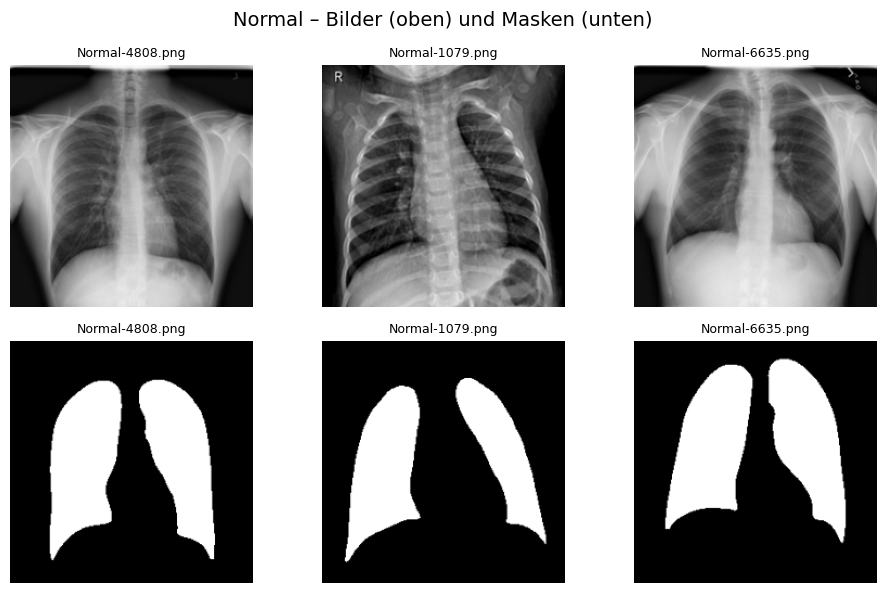

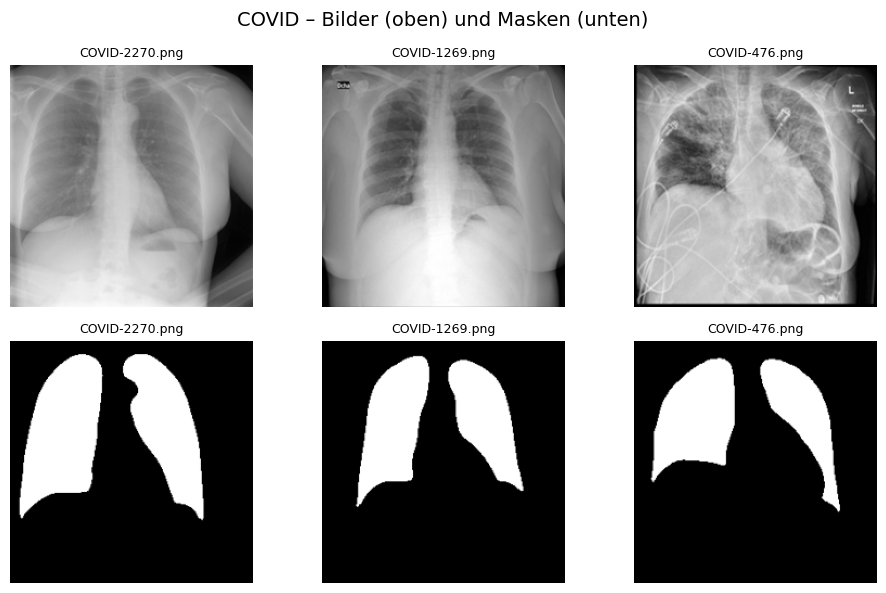

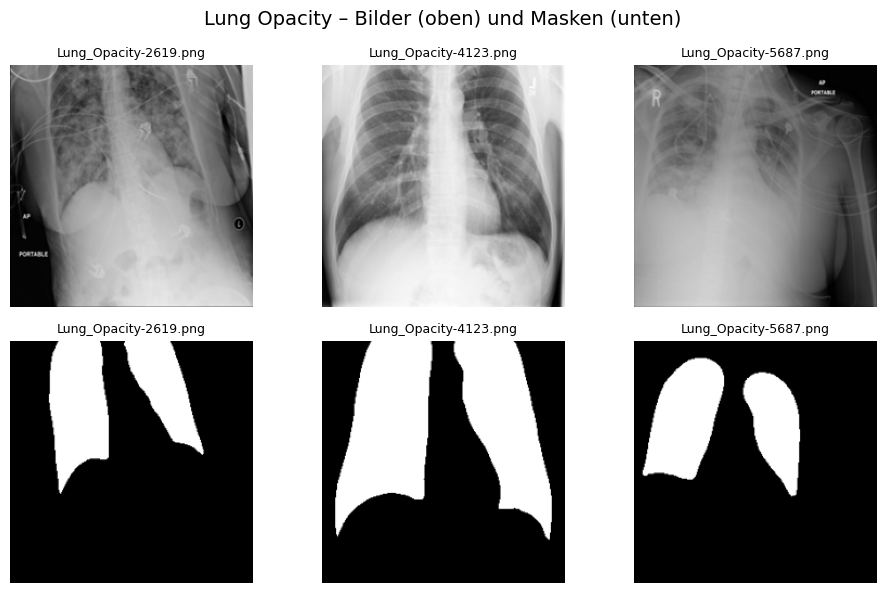

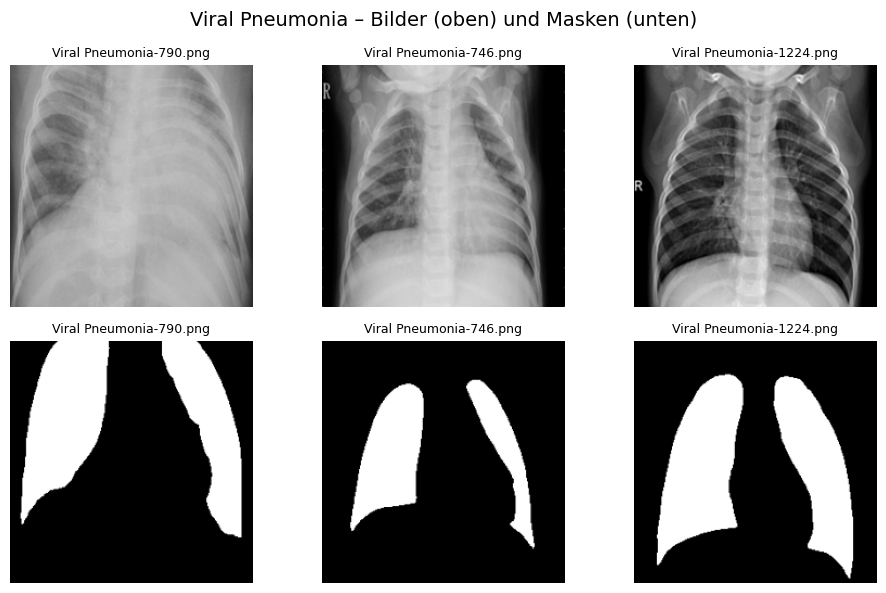

In [5]:
# 04_visual_check.py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from pathlib import Path
import pandas as pd


# --- Parameter ---
PROJECT_DIR = Path.cwd()
DATA_DIR = PROJECT_DIR / "data"
df_paths = pd.read_csv(DATA_DIR / "all_images.csv")

classes = ["Normal", "COVID", "Lung Opacity", "Viral Pneumonia".replace("_"," ")]
# korrigiere Namen anhand der tatsächlichen df_paths:
available = sorted(df_paths["label"].unique())
classes = [c for c in ["Normal", "COVID", "Lung Opacity", "Viral Pneumonia"] if c in available]

samples_per_class = 3
img_size = (224, 224)
rng = np.random.default_rng(42)

def render_no_mask(size=(224, 224), text="No mask"):
    img = Image.new("RGB", size, color=(230, 230, 230))
    draw = ImageDraw.Draw(img)
    draw.text((10, size[1]//2 - 7), text, fill=(100,100,100))
    return img

# --- Maskenpfad: .../images/NAME.png -> .../masks/NAME.png
def mask_path_for(image_path: str) -> Path:
    p = Path(image_path)
    parts = list(p.parts)
    try:
        idx = len(parts) - 1 - parts[::-1].index("images")
        parts[idx] = "masks"
        return Path(*parts)
    except ValueError:
        return p.with_name(p.name)
        
for cls in classes:
    df_cls = df_paths[df_paths["label"] == cls]
    if df_cls.empty:
        print(f"Keine Bilder für Klasse {cls} gefunden."); continue

    n = min(samples_per_class, len(df_cls))
    sel = df_cls.sample(n, random_state=42)

    fig, axes = plt.subplots(2, n, figsize=(3.2*n, 6))
    fig.suptitle(f"{cls} – Bilder (oben) und Masken (unten)", fontsize=14)
    if n == 1:
        axes = np.array([[axes[0]], [axes[1]]])

    for j, (_, row) in enumerate(sel.iterrows()):
        img = Image.open(row["path"]).convert("RGB").resize(img_size)
        axes[0, j].imshow(img); axes[0, j].axis("off")
        axes[0, j].set_title(Path(row["path"]).name, fontsize=9)

        mpath = mask_path_for(row["path"])
        if mpath.exists():
            msk = Image.open(mpath).convert("RGB").resize(img_size)
        else:
            msk = render_no_mask(img_size, "No mask")
        axes[1, j].imshow(msk); axes[1, j].axis("off")
        axes[1, j].set_title(Path(mpath).name if mpath.exists() else "—", fontsize=9)

    plt.tight_layout(); plt.show()


In [6]:
# 03_common_utils.py
import warnings, json
from pathlib import Path
from typing import Literal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from skimage import feature
from sklearn.metrics import (
    confusion_matrix, precision_recall_curve,
)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- Projektpfade ---
PROJECT_DIR = Path.cwd()
SPLIT_DIR   = PROJECT_DIR / "splits"
RESULTS_DIR = PROJECT_DIR / "results"
MODELS_DIR  = PROJECT_DIR / "models"
for d in [RESULTS_DIR, MODELS_DIR, RESULTS_DIR / "meta"]:
    d.mkdir(parents=True, exist_ok=True)

# --- Splits & Klassen ---
train_df = pd.read_csv(SPLIT_DIR/"train.csv")
val_df   = pd.read_csv(SPLIT_DIR/"val.csv")
test_df  = pd.read_csv(SPLIT_DIR/"test.csv")

# Klassen nur EINMAL festlegen
CLASSES_PATH = SPLIT_DIR / "classes.json"
if CLASSES_PATH.exists():
    CLASS_NAMES = json.load(open(CLASSES_PATH))
else:
    CLASS_NAMES = sorted(pd.concat([train_df["label"], val_df["label"], test_df["label"]]).unique().tolist())
    json.dump(CLASS_NAMES, open(CLASSES_PATH, "w"))

# --- Subset-Parameter (nur hier zentral; vermeide Duplikate in Notebooks) ---
USE_FRACTION   = True
TRAIN_FRACTION = 1.0   # alles nutzen
VAL_FRACTION   = 1.0
N_TRAIN_PER_CLASS = None
N_VAL_PER_CLASS   = None

def _stratified_fraction(df, frac=None, seed=42):
    if frac is None or frac >= 1.0: return df.copy()
    return (df.groupby("label", group_keys=False)
              .apply(lambda x: x.sample(frac=frac, random_state=seed))
              .reset_index(drop=True))

def _stratified_per_class(df, n=None, seed=42):
    if n is None: return df.copy()
    return (df.groupby("label", group_keys=False)
              .apply(lambda x: x.sample(min(len(x), n), random_state=seed))
              .reset_index(drop=True))

# Effektive Splits (gleich für SVM & CNN)
if USE_FRACTION:
    train_df_eff = _stratified_fraction(train_df, TRAIN_FRACTION)
    val_df_eff   = _stratified_fraction(val_df,   VAL_FRACTION)
else:
    train_df_eff = _stratified_per_class(train_df, N_TRAIN_PER_CLASS)
    val_df_eff   = _stratified_per_class(val_df,   N_VAL_PER_CLASS)
test_df_eff = test_df.copy()

# ---------- Zusammenfassung der effektiven Splits ----------
def _counts_and_perc(df, classes):
    cnt = df["label"].value_counts().reindex(classes, fill_value=0)
    pct = (cnt / max(1, cnt.sum()) * 100).round(2)
    return cnt, pct

def _summary_table(train_df, val_df, test_df, classes):
    t_cnt, t_pct = _counts_and_perc(train_df, classes)
    v_cnt, v_pct = _counts_and_perc(val_df,   classes)
    s_cnt, s_pct = _counts_and_perc(test_df,  classes)

    summary = pd.DataFrame({
        "Train (n)": t_cnt, "Train (%)": t_pct.astype(str) + "%",
        "Val (n)":   v_cnt, "Val (%)":   v_pct.astype(str) + "%",
        "Test (n)":  s_cnt, "Test (%)":  s_pct.astype(str) + "%",
    }, index=classes)

    total = pd.Series({
        "Train (n)": t_cnt.sum(), "Train (%)": "100.00%",
        "Val (n)":   v_cnt.sum(), "Val (%)":   "100.00%",
        "Test (n)":  s_cnt.sum(), "Test (%)":  "100.00%",
    }, name="TOTAL")
    return pd.concat([summary, total.to_frame().T])

# Klassenliste sicherstellen (wir haben CLASS_NAMES oben bereits gesetzt)
_summary = _summary_table(train_df_eff, val_df_eff, test_df_eff, CLASS_NAMES)

print("\n============= Effektive Datensatz-Größen (nach Subsetting) =============")
print(f"USE_FRACTION={USE_FRACTION} | TRAIN_FRACTION={TRAIN_FRACTION} | VAL_FRACTION={VAL_FRACTION} | "
      f"N_TRAIN_PER_CLASS={N_TRAIN_PER_CLASS} | N_VAL_PER_CLASS={N_VAL_PER_CLASS}")
print(f"Train: {len(train_df_eff)} | Val: {len(val_df_eff)} | Test: {len(test_df_eff)}")
print("Klassennamen:", CLASS_NAMES)
print("\nVerteilung je Split (Anzahl & Prozent):\n")
print(_summary.to_string())
print("\n=======================================================================\n")
# ------------------------------------------------------------------------



============= Effektive Datensatz-Größen (nach Subsetting) =============
USE_FRACTION=True | TRAIN_FRACTION=1.0 | VAL_FRACTION=1.0 | N_TRAIN_PER_CLASS=None | N_VAL_PER_CLASS=None
Train: 14815 | Val: 3175 | Test: 3175
Klassennamen: ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']

Verteilung je Split (Anzahl & Prozent):

                Train (n) Train (%) Val (n)  Val (%) Test (n) Test (%)
COVID                2532    17.09%     542   17.07%      542   17.07%
Lung Opacity         4208     28.4%     902   28.41%      902   28.41%
Normal               7134    48.15%    1529   48.16%     1529   48.16%
Viral Pneumonia       941     6.35%     202    6.36%      202    6.36%
TOTAL               14815   100.00%    3175  100.00%     3175  100.00%




In [7]:
# --- Bildgröße (einheitlich) ---
IMG_SIZE = 256
IMG_SIZE_CNN = IMG_SIZE

In [8]:
# --- Gemeinsame Masken-Anwendung (für SVM & CNN) ---
def load_image_and_optional_mask(path: str, use_masks: bool, img_size: int) -> np.ndarray:
    """
    Lädt Graubild, optional multipliziert mit binärer Maske (nearest, Schwelle 0.5).
    Rückgabe: float32 in [0,1], shape (H,W).
    """
    img = Image.open(path).convert("L").resize((img_size, img_size), Image.BILINEAR)
    img_np = np.asarray(img, dtype=np.float32) / 255.0
    if use_masks:
        mp = mask_path_for(path)
        if mp.exists():
            msk = Image.open(mp).convert("L").resize((img_size, img_size), Image.NEAREST)
            msk_np = (np.asarray(msk, dtype=np.float32) / 255.0 > 0.5).astype(np.float32)
            img_np = img_np * msk_np
    return img_np

# ---------- Plot-Helper (einmal zentral) ----------
def plot_confusion_matrix_simple(y_true, y_pred, class_names, title="Confusion (normiert)"):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)), normalize="true")
    plt.figure(figsize=(4.8,4.2))
    im = plt.imshow(cm, cmap="Blues", vmin=0, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
    plt.yticks(range(len(class_names)), class_names)
    plt.title(title); plt.tight_layout(); plt.show()

def pr_curves_ovr_from_scores(y_true, y_score, class_names, title="PR-Kurven (OvR)"):
    plt.figure(figsize=(6,4.5))
    n_cls = len(class_names)
    for k in range(n_cls):
        yk = (y_true == k).astype(int)
        prec, rec, _ = precision_recall_curve(yk, y_score[:,k])
        plt.plot(rec, prec, label=class_names[k])
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(title)
    plt.legend(); plt.grid(True, alpha=0.3); plt.tightLayout(); plt.show()

In [9]:
# --- Demo: zeige Bild, Maske, und Bild×Maske ---
def demo_mask_application(sample_path: str, img_size: int = IMG_SIZE):
    img = Image.open(sample_path).convert("L").resize((img_size, img_size), Image.BILINEAR)
    mp  = mask_path_for(sample_path)
    if mp.exists():
        msk = Image.open(mp).convert("L").resize((img_size, img_size), Image.NEAREST)
        msk_np = (np.asarray(msk, dtype=np.float32) / 255.0 > 0.5).astype(np.float32)
    else:
        msk = Image.new("L", (img_size, img_size), color=0)
        msk_np = np.zeros((img_size, img_size), dtype=np.float32)

    img_np  = np.asarray(img, dtype=np.float32)/255.0
    masked  = img_np * msk_np

    fig, axes = plt.subplots(1,3, figsize=(9,3))
    axes[0].imshow(img_np, cmap="gray");   axes[0].set_title("Bild");      axes[0].axis("off")
    axes[1].imshow(msk_np, cmap="gray");   axes[1].set_title("Maske");     axes[1].axis("off")
    axes[2].imshow(masked, cmap="gray");   axes[2].set_title("Bild × Maske"); axes[2].axis("off")
    plt.tight_layout(); plt.show()

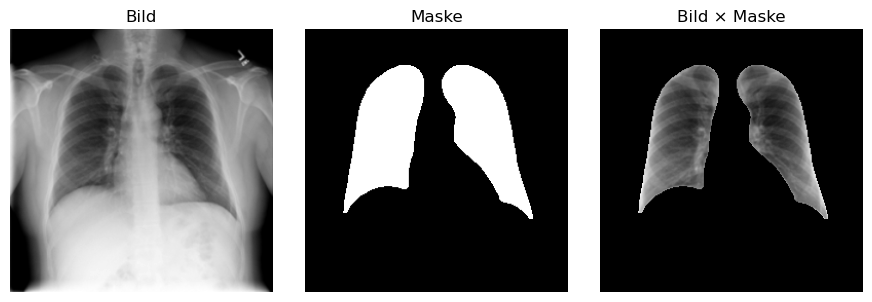

In [10]:
demo_mask_application(train_df_eff.iloc[0]["path"])

In [11]:
ML/
├── models/                       <-- MODELS_DIR
│   ├── pt_smallcnn_multi_nomask_2025_08_29_1530.pt        # bestes Modell
│   ├── pt_smallcnn_multi_nomask_2025_08_29_1530_ep005.pt  # Checkpoint
│   ├── pt_smallcnn_multi_nomask_2025_08_29_1530_ep010.pt  # Checkpoint
│   └── ...
└── results/                     <-- RESULTS_DIR
    └── pt_smallcnn_multi_nomask_2025_08_29_1530/
        ├── curves.png
        ├── metrics.png
        ├── roc_curves.png
        ├── roc_auc.json
        ├── history.json
        └── meta_train.json


SyntaxError: invalid character '├' (U+251C) (1197129981.py, line 2)

In [11]:
# === 4) CNN – Dataset/Dataloader, Modell, Train/Test (gleiche Parameter wie SVM) ===
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

class CsvImageDatasetCNN(Dataset):
    """
    Lädt Bilder aus CSV; optional Maske über load_image_and_optional_mask().
    Augmentierung nur im Training; Graustufen-Normierung auf [-1,1].
    """
    def __init__(self, csv_path, classes, img_size=IMG_SIZE_CNN, train=False, use_masks=False):
        self.df = pd.read_csv(csv_path)
        self.classes = classes
        self.class_to_idx = {c:i for i,c in enumerate(classes)}
        self.img_size = img_size
        self.use_masks = use_masks
        self.train = train

        self.aug = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(5),
        ]) if train else None

        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),                        # [0,1]
            transforms.Normalize(mean=[0.5], std=[0.5]), # -> ~[-1,1]
        ])

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_np = load_image_and_optional_mask(row["path"], self.use_masks, self.img_size)  # (H,W) in [0,1]
        img = Image.fromarray((img_np*255.0).astype(np.uint8))
        if self.train and self.aug is not None:
            img = self.aug(img)
        x = self.to_tensor(img)  # (1,H,W)
        y = self.class_to_idx[row["label"]]
        return x, y

def make_loaders_cnn(
    mode: Literal["mask","nomask"],
    img_size=IMG_SIZE_CNN,
    batch=64,
    *,
    num_workers: int = 2,                 # Notebook → 0
    persistent_workers: bool | None = None
):
    """
    Erstellt Datasets & Dataloaders.
    - num_workers: in Notebooks 0 (stabiler), auf Servern 2–8.
    - persistent_workers: Standard = (num_workers > 0)
    - pin_memory: automatisch nur, wenn CUDA verfügbar ist.
    """
    if persistent_workers is None:
        persistent_workers = num_workers > 0

    use_masks = (mode == "mask")
    train_ds = CsvImageDatasetCNN(SPLIT_DIR/"train.csv", CLASS_NAMES, img_size=img_size, train=True,  use_masks=use_masks)
    val_ds   = CsvImageDatasetCNN(SPLIT_DIR/"val.csv",   CLASS_NAMES, img_size=img_size, train=False, use_masks=use_masks)
    test_ds  = CsvImageDatasetCNN(SPLIT_DIR/"test.csv",  CLASS_NAMES, img_size=img_size, train=False, use_masks=use_masks)

    pin = torch.cuda.is_available()

    train_loader = DataLoader(
        train_ds, batch_size=batch, shuffle=True,
        num_workers=num_workers, pin_memory=pin, persistent_workers=persistent_workers
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch, shuffle=False,
        num_workers=num_workers, pin_memory=pin, persistent_workers=persistent_workers
    )
    test_loader = DataLoader(
        test_ds, batch_size=batch, shuffle=False,
        num_workers=num_workers, pin_memory=pin, persistent_workers=persistent_workers
    )
    return train_ds, val_ds, test_ds, train_loader, val_loader, test_loader


Device: cuda


In [19]:
# ==== Minimal, übersichtlich, komplett ====
import time, json
from pathlib import Path
from typing import Literal, Optional, Dict, Any

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm import tqdm  # erzwingt Textprogress, kein ipywidgets

from sklearn.metrics import (
    f1_score, balanced_accuracy_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score
)

# ---------- Modell ----------

# ---------- Neue Modell-Klassen ----------
class VerySimpleNN(nn.Module):
    """
    Naives MLP: flacht das Bild (1, H, W) zu einem Vektor ab und macht 2 Dense-Layer.
    Gut als Baseline, aber ignoriert räumliche Struktur → für Lungenbilder meist zu schwach.
    """
    def __init__(self, num_classes: int, in_h: int = 224, in_w: int = 224):
        super().__init__()
        in_features = in_h * in_w
        self.net = nn.Sequential(
            nn.Flatten(),                               # (N, 1, H, W) -> (N, H*W)
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),                      # simple & stabil
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.net(x)


class NNMLP(nn.Module):
    """
    'Verbesserte' MLP-Variante für medizinische Klassifikation:
    - deutlich mehr Kapazität (breiter)
    - LayerNorm statt BatchNorm (robuster bei kleinen Batches)
    - Dropout zur Regularisierung (Überanpassung ↓)
    - SiLU (Swish) als Aktivierung (weicher als ReLU → oft bessere AUROC)
    Hinweis: MLP sieht trotzdem keine lokalen Kontextmuster wie eine CNN.
    """
    def __init__(self, num_classes: int, in_h: int = 224, in_w: int = 224, p_drop: float = 0.3):
        super().__init__()
        in_features = in_h * in_w
        hidden1, hidden2 = 2048, 512
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, hidden1),
            nn.LayerNorm(hidden1),
            nn.SiLU(),                  # = swish; oft etwas besser als ReLU bei Bilddaten
            nn.Dropout(p_drop),

            nn.Linear(hidden1, hidden2),
            nn.LayerNorm(hidden2),
            nn.SiLU(),
            nn.Dropout(p_drop),

            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        return self.net(x)

class SmallCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1, bias=False), nn.BatchNorm2d(32), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(64,128, 3, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d(1),
        )
        self.classifier = nn.Sequential(nn.Dropout(0.2), nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.features(x).view(x.size(0), 128)
        return self.classifier(x)

# ---------- kleine Helfer ----------
def _ts():
    from datetime import datetime
    return datetime.now().strftime("2025_%m_%d_%H%M")

def _class_weights_from_csv(train_csv, classes, device):
    import pandas as pd
    lbl = pd.read_csv(train_csv)["label"].map({c:i for i,c in enumerate(classes)}).values
    cnt = np.bincount(lbl, minlength=len(classes))
    w = cnt.sum() / (len(classes) * (cnt + 1e-8))
    return torch.tensor(w, dtype=torch.float32, device=device)

@torch.no_grad()
def _eval_logits(model, loader, device):
    model.eval()
    logits_list, y_list = [], []
    for x, y in tqdm(loader, desc="[eval]", leave=False):
        x = x.to(device); y = torch.as_tensor(y, device=device)
        logits_list.append(model(x).cpu())
        y_list.append(y.cpu())
    logits = torch.cat(logits_list).numpy()
    y_true = torch.cat(y_list).numpy()
    y_pred = logits.argmax(1)
    f1m = f1_score(y_true, y_pred, average="macro")
    bal = balanced_accuracy_score(y_true, y_pred)
    return float(f1m), float(bal), y_true, y_pred, logits

def _apply_title(fig, main: str, subtitle: str | None = None,
                 main_size: int = 14, sub_size: int = 9, top: float = 0.82):
    fig.subplots_adjust(top=top)         # Platz für Titel/Untertitel lassen
    fig.suptitle(main, fontsize=main_size, y=0.98)
    if subtitle:
        fig.text(0.5, 0.905, subtitle, ha="center", va="top", fontsize=sub_size, color="0.35")

# ---------- Lernkurven ----------
def _plot_learning_curves(history: Dict[str, list], out_dir: Path, header: str):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plotgröße kompakt
    fig = plt.figure(figsize=(5, 3))
    plt.plot(epochs, history["train_loss"], label="Trainings-Verlust")
    plt.plot(epochs, history["val_loss"], label="Validierungs-Verlust")
    plt.xlabel("Epoche"); plt.ylabel("Verlust")
    plt.legend(); plt.grid(True, alpha=0.3)
    _apply_title(fig, main="Lernkurven", subtitle=header, top=0.82)
    fig.savefig(out_dir / "curves.png", dpi=160)
    plt.close(fig)

    # F1 / Balanced Accuracy
    fig = plt.figure(figsize=(5, 3))
    plt.plot(epochs, history["val_f1"], label="F1-Wert (macro)")
    plt.plot(epochs, history["val_bal"], label="Balancierte Genauigkeit")
    plt.xlabel("Epoche"); plt.ylabel("Score")
    plt.legend(); plt.grid(True, alpha=0.3)
    _apply_title(fig, main="Validierungs-Metriken", subtitle=header, top=0.82)
    fig.savefig(out_dir / "metrics.png", dpi=160)
    plt.close(fig)


# ---------- Konfusionsmatrix ----------
def _plot_confusion(y_true, y_pred, class_names, out_path: Path,
                    header: str = "Konfusionsmatrix",  # bleibt erhalten (Haupttitel)
                    subtitle: str | None = None,        # <<< NEU
                    figsize=(6, 6)):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import csv
    import numpy as np

    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

    fig, ax = plt.subplots(figsize=figsize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(include_values=True, cmap="Blues", ax=ax, xticks_rotation=45, colorbar=False)
    ax.set_title("")  # Achsentitel leer lassen, wir verwenden globalen Titel
    _apply_title(fig, main=header, subtitle=subtitle, top=0.82)  # <<< NEU
    plt.tight_layout(rect=(0, 0, 1, 0.90))
    fig.savefig(out_path, dpi=160)
    plt.close(fig)

    # Punkte/Counts zusätzlich als CSV speichern
    cm_csv = out_path.with_name("confusion_matrix.csv")
    with open(cm_csv, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow([""] + list(class_names))
        for i, row in enumerate(cm):
            w.writerow([class_names[i]] + list(map(int, row)))


# ---------- ROC-Kurven ----------
def _plot_roc_multiclass(y_true, logits, class_names, out_dir: Path,
                         subtitle: str | None = None,  # <<< NEU
                         figsize=(8, 6)):
    import json
    import numpy as np
    from sklearn.metrics import roc_curve, auc

    y_true = np.asarray(y_true)
    scores = torch.softmax(torch.from_numpy(logits), dim=1).numpy()
    n_classes = len(class_names)
    Y = np.eye(n_classes)[y_true]

    fpr, tpr, roc_auc = {}, {}, {}
    roc_points = {"per_class": {}}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y[:, i], scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        roc_points["per_class"][class_names[i]] = {
            "fpr": fpr[i].tolist(),
            "tpr": tpr[i].tolist(),
            "auc": float(roc_auc[i]),
        }

    fpr_micro, tpr_micro, _ = roc_curve(Y.ravel(), scores.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    roc_points["micro"] = {
        "fpr": fpr_micro.tolist(),
        "tpr": tpr_micro.tolist(),
        "auc": float(auc_micro),
    }
    roc_points["macro"] = {"auc": float(np.mean(list(roc_auc.values())))}

    with open(out_dir / "roc_points.json", "w") as f:
        json.dump(roc_points, f, indent=2)

    fig = plt.figure(figsize=figsize)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], linestyle="--", label=f"{class_names[i]} (AUC={roc_auc[i]:.3f})")
    plt.plot(fpr_micro, tpr_micro, label=f"Micro-Durchschnitt (AUC={auc_micro:.3f})")
    plt.plot([0, 1], [0, 1], "k--", linewidth=1)
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel("Falsch-positiv-Rate (1−Spezifität)")
    plt.ylabel("Richtig-positiv-Rate (Sensitivität)")
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(True, alpha=0.3)
    _apply_title(fig, main="ROC-Kurven (One-vs-Rest)", subtitle=subtitle, top=0.82)
    fig.savefig(out_dir / "roc_curves.png", dpi=160)
    plt.close(fig)

# ALT: (falls _build_model noch nicht existiert)
# -- nichts --

# NEU:
def _build_model(model_kind: Literal["cnn","nn_simple","nn_mlp"],
                 num_classes: int, img_size: int = 224) -> nn.Module:
    if model_kind == "cnn":
        return SmallCNN(num_classes=num_classes)
    elif model_kind == "nn_simple":
        return VerySimpleNN(num_classes=num_classes, in_h=img_size, in_w=img_size)
    elif model_kind == "nn_mlp":
        return NNMLP(num_classes=num_classes, in_h=img_size, in_w=img_size)
    else:
        raise ValueError(f"Unbekannter model_kind: {model_kind}")


# ---------- Neueste Modellpfade ----------
def _latest_model_path_by_kind(model_kind: Literal["cnn","nn_simple","nn_mlp"],
                               mode: Literal["mask","nomask"]) -> Path:
    prefix = {"cnn":"cnn", "nn_simple":"nn", "nn_mlp":"nn_mlp"}[model_kind]
    cands = sorted(MODELS_DIR.glob(f"{prefix}_{mode}_*.pt"))
    if not cands:
        raise FileNotFoundError(f"Kein Modell gefunden für {prefix=} und {mode=}")
    return cands[-1]


#def _latest_model_path(mode: Literal["mask", "nomask"], binary_abnormal: bool) -> Path:
    #patterns = [ alt
   #     f"pt_smallcnn_{'bin' if binary_abnormal else 'multi'}_{mode}_*.pt",
   #     f"pt_smallcnn_{mode}_*.pt",
   # ]
    #patterns = [f"cnn_{mode}_*.pt"]

    #cands = []
    #for pat in patterns:
    #    cands.extend(MODELS_DIR.glob(pat))
    #if not cands:
   #     raise FileNotFoundError(
    #        f"Kein Modell gefunden. Gesucht nach {patterns} in {MODELS_DIR}. "
    #        "Trainiere zuerst ein Modell oder gib model_path explizit an."
    #    )
    #return sorted(cands)[-1]

# ---------- PNG-Anzeige ----------
def _display_png_if_exists(path: Path, caption: str | None = None):
    try:
        from IPython.display import display, Image as IPyImage
        if Path(path).exists():
            if caption:
                print(caption)
            display(IPyImage(filename=str(path)))
    except Exception as e:
        print(f"(Hinweis) Konnte {path} nicht inline anzeigen: {e}")

def _lr_range_test(model, criterion, train_loader, device, 
                   min_lr: float = 1e-5, max_lr: float = 1e-1, num_steps: int = 200):
    """
    Einfacher LR-Range-Test nach Smith:
      - LR wächst exponentiell von min_lr bis max_lr.
      - Loss wird geglättet (beta=0.98).
      - Abbruch bei Loss-Explosion.
    Rückgabe: (empfohlene_lr, scan_dict)
    """
    import numpy as np
    optimizer = torch.optim.Adam(model.parameters(), lr=min_lr)
    gamma = (max_lr / min_lr) ** (1.0 / max(1, num_steps - 1))
    beta = 0.98
    avg_loss = 0.0
    losses, lrs = [], []

    print(f"[lr-finder] Start: min_lr={min_lr:.1e}, max_lr={max_lr:.1e}, steps={num_steps}")
    model.train()
    step = 0
    it = iter(train_loader)
    lr = min_lr
    for g in optimizer.param_groups:
        g["lr"] = lr

    while step < num_steps:
        try:
            x, y = next(it)
        except StopIteration:
            it = iter(train_loader)
            x, y = next(it)

        x = x.to(device); y = torch.as_tensor(y, device=device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward(); optimizer.step()

        step += 1
        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smooth_loss = avg_loss / (1 - beta ** step)
        losses.append(smooth_loss); lrs.append(lr)

        lr *= gamma
        for g in optimizer.param_groups:
            g["lr"] = lr

        if step > 20 and smooth_loss > 4 * np.min(losses):
            print("[lr-finder] Abbruch: Loss-Explosion erkannt.")
            break

    best_idx = int(np.argmin(losses))
    best_lr = lrs[best_idx] * 0.2  # etwas links vom Minimum
    print(f"[lr-finder] Ende: min_loss={float(np.min(losses)):.4f} @idx={best_idx} → vorgeschlagene LR={best_lr:.3e}")
    return float(best_lr), {"lrs": lrs, "losses": losses, "best_idx": best_idx}

def _save_history_csv(out_dir: Path, history: Dict[str, list], epoch_times: list, lrs_epoch: list):
    """
    Speichert epochenweise Daten für spätere Overlays:
    epoch, train_loss, val_loss, val_f1, val_bal, lr_epoch, epoch_time_sec
    """
    import csv
    out_path = out_dir / "history.csv"
    with open(out_path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["epoch","train_loss","val_loss","val_f1","val_bal","lr_epoch","epoch_time_sec"])
        for i in range(len(history["train_loss"])):
            w.writerow([
                i+1,
                history["train_loss"][i],
                history["val_loss"][i],
                history["val_f1"][i],
                history["val_bal"][i],
                lrs_epoch[i] if i < len(lrs_epoch) else None,
                round(epoch_times[i], 3) if i < len(epoch_times) else None
            ])
    return out_path

def train(
    mode: Literal["mask","nomask"],
    *,
    epochs=20, patience=5, lr: float | str = 1e-3,  # <- float oder "auto"
    batch=64, img_size=224,
    ckpt_every: int = 5,
    binary_abnormal: bool = False,
    show_after: bool = True,
    model_kind: Literal["cnn","nn_simple","nn_mlp"] = "cnn"
):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ts = _ts()
    train_ds, val_ds, test_ds, train_loader, val_loader, _ = make_loaders_cnn(mode, img_size, batch)

    # Klassen (optional binär)
    class_names = CLASS_NAMES
    map_to_binary = None
    if binary_abnormal:
        class_names = ["Normal", "Ungesund"]
        def map_to_binary(y): return 0 if y == CLASS_NAMES.index("Normal") else 1

    model = _build_model(model_kind, num_classes=len(class_names), img_size=img_size).to(device)

    # Klassen-Gewichte
    weights = _class_weights_from_csv(SPLIT_DIR/"train.csv", CLASS_NAMES, device) if not binary_abnormal else None
    if binary_abnormal and weights is not None:
        pos = neg = 0
        for _, y in train_loader:
            y = y.numpy()
            pos += (y != CLASS_NAMES.index("Normal")).sum()
            neg += (y == CLASS_NAMES.index("Normal")).sum()
        total = pos + neg
        w = np.array([total/(2*neg+1e-8), total/(2*pos+1e-8)], dtype=np.float32)
        weights = torch.tensor(w, device=device)
    criterion = nn.CrossEntropyLoss(weight=weights)

    # === LR-Auto ===
    if isinstance(lr, str) and lr.lower() == "auto":
        # frisches Modell für LR-Finder nutzen
        finder_model = _build_model(model_kind, num_classes=len(class_names), img_size=img_size).to(device)
        finder_model.load_state_dict(model.state_dict())
        best_lr, _scan = _lr_range_test(finder_model, criterion, train_loader, device)
        print(f"[lr-finder] gewählte Start-LR: {best_lr:.3e}")
        lr = float(best_lr)

    optimizer = torch.optim.Adam(model.parameters(), lr=float(lr))

    prefix = {"cnn":"cnn","nn_simple":"nn","nn_mlp":"nn_mlp"}[model_kind]
    tag = f"{prefix}_{mode}_{ts}_batch-{batch}_lr-{str(lr).replace('.', '') if isinstance(lr, float) else lr}"


    out_dir   = RESULTS_DIR / tag
    model_dir = MODELS_DIR
    out_dir.mkdir(parents=True, exist_ok=True)

    best_val, wait = -np.inf, 0
    epoch_times, t0_total = [], time.perf_counter()
    history = {"train_loss":[], "val_loss":[], "val_f1":[], "val_bal":[]}
    lrs_epoch = []

    print(f"\n[TRAIN-START] Model={model_kind} | Modus={mode} | Batch={batch} | LR={lr} | Epochen={epochs} | Binary={binary_abnormal} ==> Gerät: {device}")

    for epoch in range(1, epochs+1):
        model.train()
        t0 = time.perf_counter()
        running, seen = 0.0, 0
        for x, y in tqdm(train_loader, desc=f"[train] Epoche {epoch}/{epochs}", leave=False):
            x = x.to(device); y = torch.as_tensor(y, device=device)
            if binary_abnormal and map_to_binary is not None:
                y = torch.tensor([map_to_binary(int(yi)) for yi in y], device=device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward(); optimizer.step()
            bs = x.size(0); running += loss.item()*bs; seen += bs
        train_loss = running / max(1, seen)

        # Validation
        model.eval()
        with torch.no_grad():
            v_loss, v_seen = 0.0, 0
            logits_all, yt_all = [], []
            for x, y in tqdm(val_loader, desc=f"[val] Epoche {epoch}/{epochs}", leave=False):
                x = x.to(device); y = torch.as_tensor(y, device=device)
                if binary_abnormal and map_to_binary is not None:
                    y = torch.tensor([map_to_binary(int(yi)) for yi in y], device=device)
                logits = model(x)
                loss = criterion(logits, y)
                v_loss += loss.item()*x.size(0); v_seen += x.size(0)
                logits_all.append(logits.cpu()); yt_all.append(y.cpu())
            val_loss = v_loss / max(1, v_seen)
            logits_np = torch.cat(logits_all).numpy()
            y_true = torch.cat(yt_all).numpy()
            y_pred = logits_np.argmax(1)
            val_f1  = f1_score(y_true, y_pred, average="macro")
            val_bal = balanced_accuracy_score(y_true, y_pred)

        dt = time.perf_counter() - t0
        epoch_times.append(dt)
        history["train_loss"].append(float(train_loss))
        history["val_loss"].append(float(val_loss))
        history["val_f1"].append(float(val_f1))
        history["val_bal"].append(float(val_bal))
        lrs_epoch.append(float(optimizer.param_groups[0]["lr"]))

        print(f"Epoche {epoch:02d}: train_loss={train_loss:.4f} | val_loss={val_loss:.4f} "
              f"| val_f1={val_f1:.3f} | val_bal={val_bal:.3f} | {dt:.2f}s")

        _plot_learning_curves(history, out_dir, header=f"mode={mode}, batch={batch}, lr={lr}")
        if epoch % ckpt_every == 0:
            torch.save(model.state_dict(), model_dir / f"{tag}_ep{epoch:03d}.pt")
        if val_f1 > best_val:
            best_val, wait = val_f1, 0
            torch.save(model.state_dict(), model_dir / f"{tag}.pt")
        else:
            wait += 1
            if wait >= patience:
                print("Early Stopping (Kriterium: bester Validierungs-F1).")
                break

    # History zusätzlich als CSV speichern (für Overlays)
    _save_history_csv(out_dir, history, epoch_times, lrs_epoch)

    meta = {
        "model_kind": model_kind,
        "tag": tag, "mode": mode, "classes": class_names,
        "epochs_run": len(history["train_loss"]),
        "epoch_times_sec": [round(x,3) for x in epoch_times],
        "train_total_sec": round(time.perf_counter() - t0_total, 3),
        "best_val_f1_macro": float(best_val),
        "lr": float(lr), "batch": batch, "img_size": img_size,
        "binary_abnormal": bool(binary_abnormal),
    }
    with open(out_dir/"meta_train.json","w") as f: json.dump(meta, f, indent=2)
    print(f"[train] fertig → {out_dir}")

    if show_after:
        _display_png_if_exists(out_dir/"curves.png",  "Lernkurven (Train/Val-Verlust)")
        _display_png_if_exists(out_dir/"metrics.png", "Validierungsmetriken (F1/Balance)")
        
    return {
        "tag": tag,
        "out_dir": out_dir,
        "model_path": model_dir / f"{tag}.pt",
        "history_csv": out_dir / "history.csv"
    }



def test(
    mode: Literal["mask","nomask"],
    model_path: Optional[str] = None,
    *,
    batch=64, img_size=224,
    binary_abnormal: bool = False,
    show_after: bool = True,
    model_kind: Literal["cnn","nn_simple","nn_mlp"] = "cnn"
):

    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ts = _ts()
    _, _, test_ds, _, _, test_loader = make_loaders_cnn(mode, img_size, batch)
    class_names = ["Normal","Ungesund"] if binary_abnormal else CLASS_NAMES

    #if model_path is None: alt
        #model_path = _latest_model_path(mode, binary_abnormal)
    #else:
        #model_path = Path(model_path)

    if model_path is None:
        model_path = _latest_model_path_by_kind(model_kind, mode)

    tag = f"{Path(model_path).stem}_test"
    out_dir = RESULTS_DIR / tag

    # Modell konstruieren & Gewichte sicher laden
    model = _build_model(model_kind, num_classes=len(class_names), img_size=img_size).to(device)

    try:
        state = torch.load(model_path, map_location=device, weights_only=True)
    except TypeError:
        import warnings
        warnings.filterwarnings("ignore", message=".*weights_only=False.*")
        state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    model.eval()


    print(f"[TEST-START] Model={model_kind} | Modus={mode} | Batch={batch}")
    print(f"Pfad={Path(model_path).name}")

    t0 = time.perf_counter()
    f1m, balc, y_true, y_pred, logits = _eval_logits(model, test_loader, device)
    dt = time.perf_counter() - t0

    tag = f"{model_path.stem}_test"
    out_dir = RESULTS_DIR / tag

    # Falls Ordner existiert → automatisch durchnummerieren:
    k = 1
    while out_dir.exists():
        out_dir = RESULTS_DIR / f"{tag}_r{k}"
        k += 1
    out_dir.mkdir(parents=True, exist_ok=True)

    #tag = f"{model_path.stem}_{ts}_test" alt
    #out_dir = RESULTS_DIR / tag; out_dir.mkdir(parents=True, exist_ok=True) alt

    # speichern
    np.save(out_dir/"y_true.npy", y_true)
    np.save(out_dir/"y_pred.npy", y_pred)
    np.save(out_dir/"logits.npy", logits)

    # per-class Präzision/Recall/F1
    pr, rc, f1c, sup = precision_recall_fscore_support(
    y_true, y_pred,
    labels=range(len(class_names)),
    zero_division=0
    )
    metrics = {
        "test_f1_macro": float(f1m),
        "test_bal_acc": float(balc),
        "per_class": {class_names[i]: {
            "precision": float(pr[i]), "recall": float(rc[i]), "f1": float(f1c[i]), "support": int(sup[i])
        } for i in range(len(class_names))}
    }
    with open(out_dir/"metrics.json","w") as f: json.dump(metrics, f, indent=2)

    # Plots
    _plot_confusion(y_true, y_pred, class_names, out_path=out_dir/"confusion_matrix.png",
                    header="Konfusionsmatrix (Test)")
    _plot_roc_multiclass(y_true, logits, class_names, out_dir=out_dir)

    print(f"[test] F1(macro)={f1m:.3f} | BalAcc={balc:.3f} | Zeit={dt:.2f}s | {out_dir}")

    if show_after:
        _display_png_if_exists(out_dir/"confusion_matrix.png", "Konfusionsmatrix (Test)")
        _display_png_if_exists(out_dir/"roc_curves.png",       "ROC-Kurven (per Klasse, micro/macro)")
    
    return {
        "out_dir": str(out_dir),
        "test_f1_macro": float(f1m),
        "test_bal_acc": float(balc)
    }




In [56]:
train("nomask", batch=64, lr=1e-3, epochs=20)


[TRAIN-START] Model=cnn | Modus=nomask | Batch=64 | LR=0.001 | Epochen=20 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.0534 | val_loss=0.9215 | val_f1=0.561 | val_bal=0.639 | 28.12s


Epoche 02: train_loss=0.8621 | val_loss=0.8657 | val_f1=0.640 | val_bal=0.637 | 27.55s


Epoche 03: train_loss=0.7780 | val_loss=0.7812 | val_f1=0.602 | val_bal=0.700 | 27.44s


Epoche 04: train_loss=0.7295 | val_loss=1.0068 | val_f1=0.469 | val_bal=0.626 | 28.12s


Epoche 05: train_loss=0.6955 | val_loss=0.6839 | val_f1=0.668 | val_bal=0.748 | 28.15s


Epoche 06: train_loss=0.6521 | val_loss=0.6477 | val_f1=0.729 | val_bal=0.744 | 28.18s


Epoche 07: train_loss=0.6345 | val_loss=0.7888 | val_f1=0.700 | val_bal=0.696 | 27.63s


KeyboardInterrupt: 

In [ ]:
test("nomask")


[TRAIN-START] Modus=mask | Batch=64 | LR=0.001 | Epochen=20 | Binary=False ==> Gerät: cuda


[train] Epoche 1/20:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 1/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 01: train_loss=1.1751 | val_loss=1.0589 | val_f1=0.547 | val_bal=0.531 | 56.25s


[train] Epoche 2/20:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 2/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 02: train_loss=0.9364 | val_loss=1.1027 | val_f1=0.537 | val_bal=0.524 | 45.75s


[train] Epoche 3/20:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 3/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 03: train_loss=0.8467 | val_loss=0.7957 | val_f1=0.660 | val_bal=0.707 | 45.68s


[train] Epoche 4/20:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 4/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 04: train_loss=0.7909 | val_loss=2.8020 | val_f1=0.221 | val_bal=0.404 | 46.20s


[train] Epoche 5/20:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 5/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 05: train_loss=0.7842 | val_loss=0.9854 | val_f1=0.595 | val_bal=0.578 | 46.03s


[train] Epoche 6/20:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 6/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 06: train_loss=0.7743 | val_loss=0.9270 | val_f1=0.509 | val_bal=0.593 | 45.69s


[train] Epoche 7/20:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 7/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 07: train_loss=0.7515 | val_loss=1.0238 | val_f1=0.612 | val_bal=0.596 | 46.08s


[train] Epoche 8/20:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 8/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 08: train_loss=0.7465 | val_loss=1.0437 | val_f1=0.433 | val_bal=0.568 | 45.84s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_mask_2025_08_29_2331_batch-64_lr-0001
Lernkurven (Train/Val-Verlust)


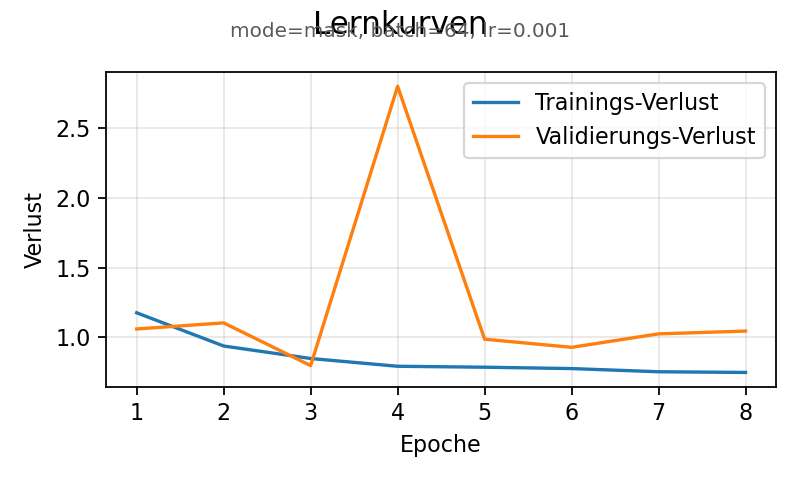

Validierungsmetriken (F1/Balance)


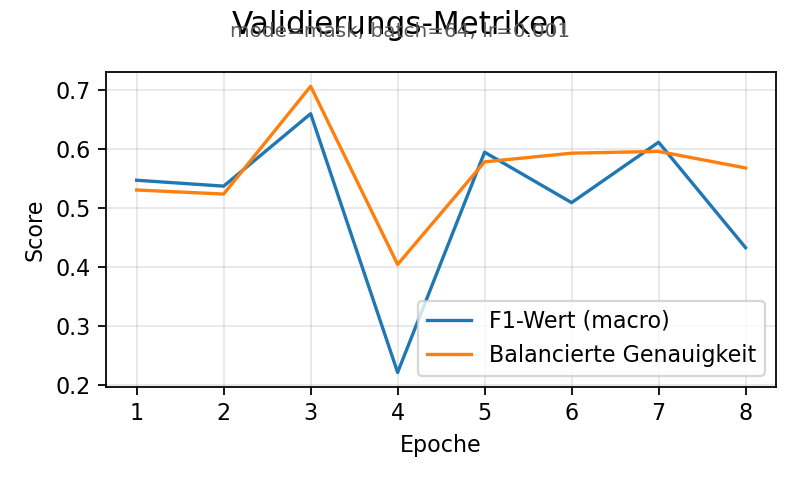

{'tag': 'cnn_mask_2025_08_29_2331_batch-64_lr-0001',
 'out_dir': PosixPath('/home/lupan001/ML/results/cnn_mask_2025_08_29_2331_batch-64_lr-0001'),
 'model_path': PosixPath('/home/lupan001/ML/models/cnn_mask_2025_08_29_2331_batch-64_lr-0001.pt'),
 'history_csv': PosixPath('/home/lupan001/ML/results/cnn_mask_2025_08_29_2331_batch-64_lr-0001/history.csv')}

In [21]:
train("mask", batch=64, lr=1e-3, epochs=20)

=== TEST ===


[eval]:   0%|          | 0/50 [00:00<?, ?it/s]

[test] F1(macro)=0.579 | BalAcc=0.566 | Zeit=9.46s | /home/lupan001/ML/results/cnn_mask_2025_08_29_2331_batch-64_lr-0001_ep005_test
Konfusionsmatrix (Test)


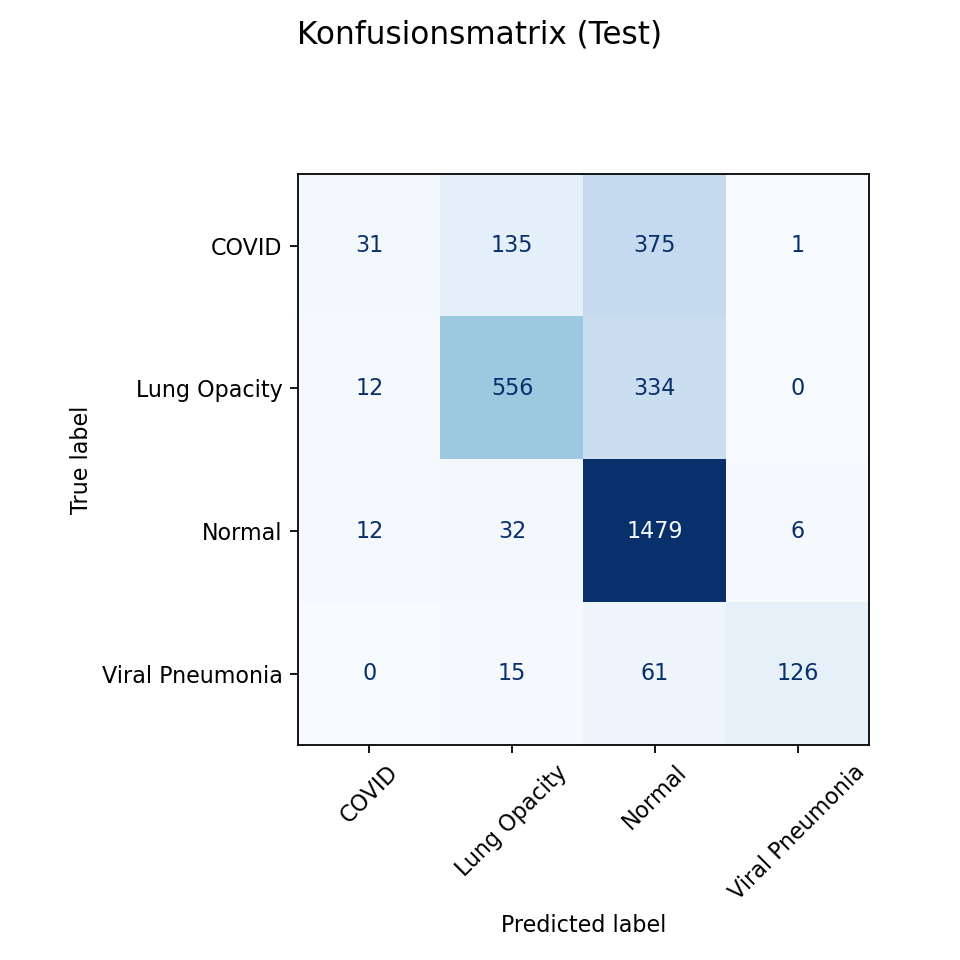

ROC-Kurven (per Klasse, micro/macro)


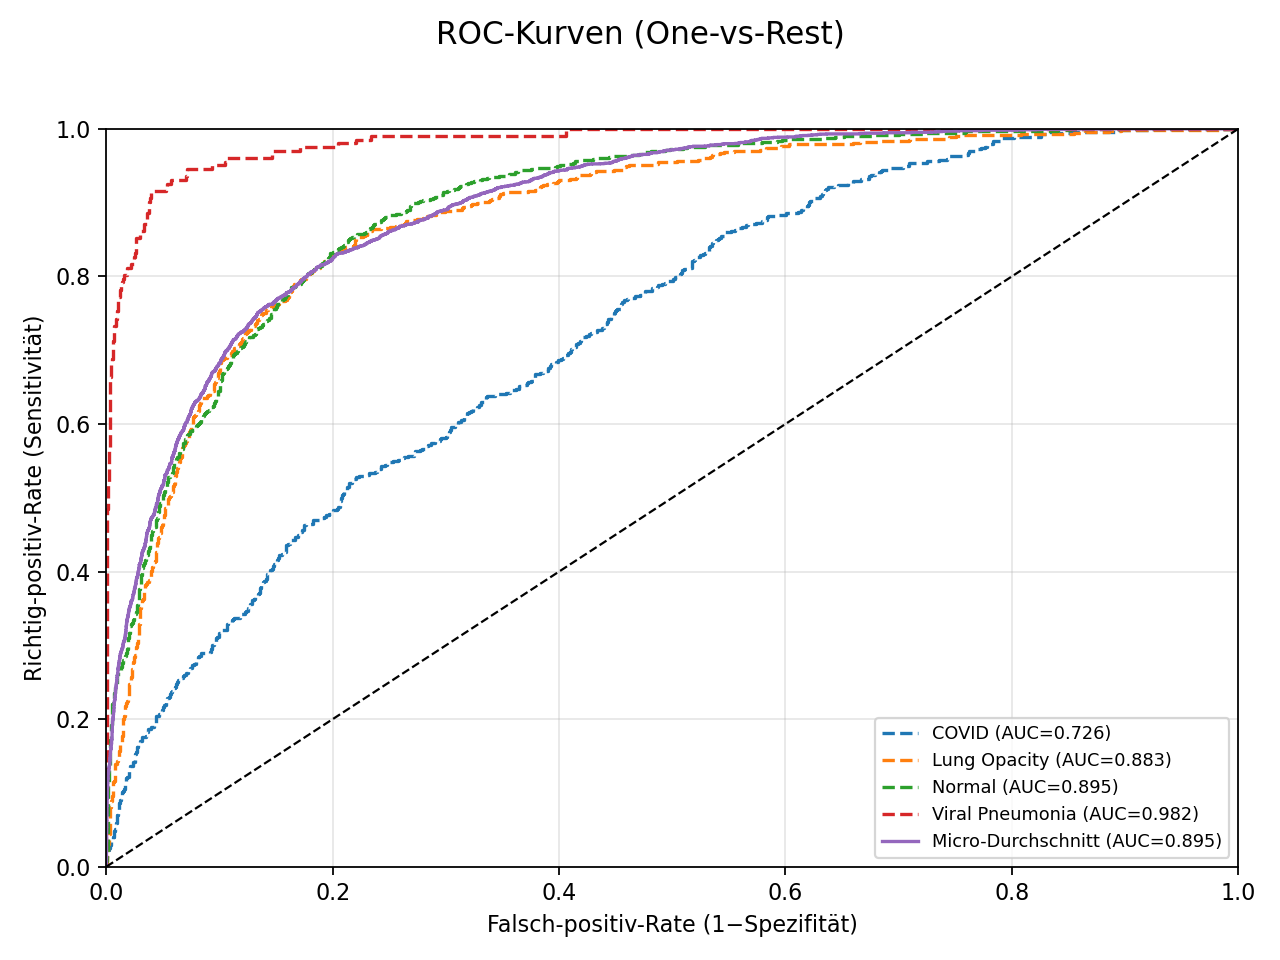

{'out_dir': '/home/lupan001/ML/results/cnn_mask_2025_08_29_2331_batch-64_lr-0001_ep005_test',
 'test_f1_macro': 0.5792735316646289,
 'test_bal_acc': 0.5661662046542955}

In [22]:
test("mask")

In [14]:
def run_sweep_train_test(
    mode: Literal["mask", "nomask"],
    *,
    batches: list[int] | None = None,
    lrs: list[float | str] | None = None,   # lr kann float ODER "auto" sein
    epochs: int = 10,
    img_size: int = 224,
    fixed_lr: float | str | None = 1e-3,   # kann ebenfalls float ODER "auto" sein
    fixed_batch: int | None = 64,
    binary_abnormal: bool = False,
    model_kind: Literal["cnn", "nn_simple", "nn_mlp"] = "cnn"   # <<< NEU
):
    """
    Sweep über mehrere Batches ODER mehrere Lernraten.
    lr kann float oder "auto" sein.
    """
    assert (batches is not None) ^ (lrs is not None), \
        "Entweder 'batches' ODER 'lrs' angeben, nicht beides."

    train_dirs = []
    test_dirs = []

    sweep_items = batches if batches is not None else lrs
    for item in sweep_items:
        # --- Setup der Hyperparameter ---
        if batches is not None:
            b = int(item)
            lr = fixed_lr
        else:
            b = fixed_batch
            lr = item

        print(f"\n=== SWEEP RUN: model={model_kind} | mode={mode} | batch={b} | lr={lr} ===")

        # === Trainieren ===
        out = train(
            mode,
            batch=b,
            lr=lr,  # float oder "auto"
            epochs=epochs,
            img_size=img_size,
            binary_abnormal=binary_abnormal,
            model_kind=model_kind,   # <<< NEU
            show_after=False
        )
        train_dirs.append(out["out_dir"])

        # === Testen (immer genau dieses Modell) ===
        tres = test(
            mode,
            model_path=out["model_path"],
            batch=b,
            img_size=img_size,
            binary_abnormal=binary_abnormal,
            model_kind=model_kind,   # <<< NEU
            show_after=False
        )
        test_dirs.append(Path(tres["out_dir"]))

        # === Kurzer Konsolen-Log ===
        print(
            f"[SWEEP] Modell={out['out_dir'].name} | "
            f"F1={tres['test_f1_macro']:.3f} | "
            f"BalAcc={tres['test_bal_acc']:.3f}"
        )

    return train_dirs, test_dirs


In [15]:
import re
import numpy as np

# NEU:
# --- ALT:
# def _extract_hyperparams_from_tag(tag: str): ...
# def _compute_varying_params(tags: list[str]): ...
# def _label_from_tag(tag: str, vary_mode: str): ...

# --- NEU:
import re

def _extract_hyperparams_from_tag(tag: str):
    """
    Erwartete Schemen (robust):
      <model>_<mode>_<timestamp>_batch-<B>_lr-<LR>
    Beispiele:
      cnn_nomask_2025_08_29_2210_batch-32_lr-0001
      nn_mlp_mask_2025_08_30_1012_batch-128_lr-0.001
      nn_nomask_..._batch-64_lr-auto
    """
    parts = tag.split("_")
    model = parts[0] if len(parts) > 0 else None       # cnn | nn | nn_mlp | nnmed ...
    mode  = parts[1] if len(parts) > 1 else None       # mask | nomask

    m_b = re.search(r"batch-(\d+)", tag)
    batch = int(m_b.group(1)) if m_b else None

    lr_val = None
    m_lr = re.search(r"lr-([a-zA-Z0-9\.]+)", tag)
    if m_lr:
        s = m_lr.group(1)
        if s.lower() == "auto":
            lr_val = "auto"
        elif "." in s:
            lr_val = float(s)
        else:
            # "0001" -> 0.0001 (heuristik)
            lr_val = float("0." + s) if len(s) > 1 else float(s)

    return {"model": model, "mode": mode, "batch": batch, "lr": lr_val, "raw": tag}


def _compute_varying_params(tags: list[str]):
    parsed = [_extract_hyperparams_from_tag(t) for t in tags]
    batches = {p["batch"] for p in parsed if p["batch"] is not None}
    lrs     = {p["lr"]    for p in parsed if p["lr"]    is not None}

    vary_batch = len(batches) > 1
    vary_lr    = len(lrs)    > 1

    if vary_batch and not vary_lr:
        mode = "batch"
    elif vary_lr and not vary_batch:
        mode = "lr"
    elif vary_batch and vary_lr:
        mode = "both"
    else:
        mode = "none"
    return mode, parsed


def _label_from_tag(tag: str, vary_mode: str, *,
                    force_full: bool = False,
                    show_model: bool = False,
                    show_mode: bool = False):
    """
    Erzeugt eine kompakte Legende.
    - force_full=True -> immer "batch=.., lr=.."
    - show_model=True -> Präfix (cnn/nn/nn_mlp) voranstellen
    - show_mode=True  -> (mask/nomask) anhängen
    """
    info = _extract_hyperparams_from_tag(tag)
    b, lr, model, mode = info["batch"], info["lr"], info["model"], info["mode"]

    def _lr_str(v):
        if v == "auto":
            return "auto"
        if isinstance(v, float):
            return f"{v:.4g}"
        return str(v) if v is not None else "?"

    parts = []

    if show_model and model:
        parts.append(model)

    # Kernteile je nach Wunsch
    if force_full:
        if b is not None:
            parts.append(f"batch={b}")
        if lr is not None:
            parts.append(f"lr={_lr_str(lr)}")
    else:
        if vary_mode == "batch" and b is not None:
            parts.append(f"batch={b}")
        elif vary_mode == "lr" and lr is not None:
            parts.append(f"lr={_lr_str(lr)}")
        else:
            # both/none → zeige was vorhanden ist
            sub = []
            if b is not None: sub.append(f"batch={b}")
            if lr is not None: sub.append(f"lr={_lr_str(lr)}")
            if sub: parts.append(", ".join(sub))

    if show_mode and mode:
        parts.append(mode)

    return " | ".join(parts) if parts else info["raw"]




# -------- Trainings-Overlays --------
def plot_train_overlays_multi(result_dirs: list[Path] | list[str],
                              metrics: tuple[str, ...] = ("val_f1","val_loss","val_bal","train_loss"),
                              title_prefix: str = "Vergleich"):
    import pandas as pd
    import matplotlib.pyplot as plt
    from pathlib import Path

    result_dirs = [Path(p) for p in result_dirs]
    colors = plt.cm.tab10.colors
    n = len(metrics)
    fig, axes = plt.subplots(1, n, figsize=(4.5*n, 3.5), squeeze=False)
    axes = axes[0]

    # Bestimme, was in den Labels stehen soll (nur batch, nur lr, beides)
    tags = [rdir.name for rdir in result_dirs]
    vary_mode, _ = _compute_varying_params(tags)

    legends_print = []

    for mi, metric in enumerate(metrics):
        ax = axes[mi]
        for idx, rdir in enumerate(result_dirs):
            hist_path = Path(rdir) / "history.csv"
            if not hist_path.exists():
                continue
            df = pd.read_csv(hist_path)

            label = _label_from_tag(rdir.name, vary_mode, force_full=True, show_model=True, show_mode=True)
            ax.plot(df["epoch"], df[metric],
                    color=colors[idx % len(colors)], linewidth=2, label=label)

            legends_print.append(f"{label} | {metric} max={df[metric].max():.4f}")

        ax.set_title(f"{title_prefix}: {metric}")
        ax.set_xlabel("Epoche")
        ax.set_ylabel(metric)
        ax.grid(alpha=0.3)
        if mi == n-1:
            ax.legend(fontsize=8, loc="best")

    print("\n=== MODELLVERGLEICH (Train) ===")
    for line in sorted(set(legends_print)):
        print(line)
    plt.tight_layout()
    plt.show()

def plot_train_overlays_grid(result_dirs: list[Path] | list[str],
                             metrics: tuple[str, ...] = ("train_loss","val_loss","val_f1","val_bal"),
                             title_prefix: str = "Trainings-Overlays"):
    """
    Zeichnet bis zu 4 Trainings-Metriken im 2x2-Layout.
    Default-Reihenfolge: train_loss | val_loss
                         val_f1     | val_bal
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path

    result_dirs = [Path(p) for p in result_dirs]
    colors = plt.cm.tab10.colors

    # Welche Info variiert? (batch/lr/both)
    tags = [rdir.name for rdir in result_dirs]
    vary_mode, _ = _compute_varying_params(tags)

    # 2x2 Layout
    fig, axes = plt.subplots(2, 2, figsize=(12, 9))
    axes = axes.flatten()

    # max. 4 Metriken zeichnen
    for mi, metric in enumerate(metrics[:4]):
        ax = axes[mi]
        legends_print = []
        plotted_any = False

        for idx, rdir in enumerate(result_dirs):
            hist_path = rdir / "history.csv"
            if not hist_path.exists():
                continue
            df = pd.read_csv(hist_path)

            if metric not in df.columns:
                continue

            label = _label_from_tag(
                rdir.name, vary_mode,
                force_full=True, show_model=True, show_mode=True
            )

            ax.plot(df["epoch"], df[metric],
                    linewidth=2, color=colors[idx % len(colors)],
                    label=label)
            legends_print.append(f"{label} | {metric} max={df[metric].max():.4f}")
            plotted_any = True

        ax.set_title(f"{title_prefix}: {metric}")
        ax.set_xlabel("Epoche")
        ax.set_ylabel(metric)
        ax.grid(alpha=0.3)
        # kleine Legende pro Achse
        if plotted_any:
            ax.legend(fontsize=7, loc="best")

        if legends_print:
            print(f"\n=== MODELLVERGLEICH (Train {metric}) ===")
            for line in sorted(set(legends_print)):
                print(line)

    # Falls weniger als 4 Metriken gewünscht: restliche Achsen unsichtbar
    for j in range(len(metrics), 4):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


# -------- Test-ROC-Overlays -------- #alt
def plot_test_roc_overlays(test_result_dirs: list[Path] | list[str],
                           which: str = "micro"):  # "micro" oder Klassenname
    import json
    import matplotlib.pyplot as plt
    from pathlib import Path

    test_result_dirs = [Path(p) for p in test_result_dirs]
    colors = plt.cm.tab10.colors

    # Bestimme Label-Modus (nur batch / nur lr / beides)
    tags = [rdir.name for rdir in test_result_dirs]
    vary_mode, _ = _compute_varying_params(tags)

    plt.figure(figsize=(7,5))
    legends_print = []

    for i, rdir in enumerate(test_result_dirs):
        rp = rdir / "roc_points.json"
        if not rp.exists():
            # Fallback: Datei fehlt – diesen Eintrag überspringen
            continue
        data = json.loads(rp.read_text())

        if which == "micro":
            fpr = np.array(data["micro"]["fpr"])
            tpr = np.array(data["micro"]["tpr"])
            aucv = float(data["micro"]["auc"])
            base_lbl = _label_from_tag(rdir.name, vary_mode, force_full=True, show_model=True, show_mode=True)
            lbl = f"{base_lbl} (micro AUC={aucv:.3f})"
        else:
            fpr = np.array(data["per_class"][which]["fpr"])
            tpr = np.array(data["per_class"][which]["tpr"])
            aucv = float(data["per_class"][which]["auc"])
            base_lbl = _label_from_tag(rdir.name, vary_mode, force_full=True, show_model=True, show_mode=True)
            lbl = f"{base_lbl} ({which} AUC={aucv:.3f})"

        plt.plot(fpr, tpr, color=colors[i % len(colors)], linewidth=2, label=lbl)
        legends_print.append(lbl)

    print("\n=== MODELLVERGLEICH (Test ROC) ===")
    for l in legends_print:
        print(l)
    plt.plot([0,1],[0,1],"k--",linewidth=1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC-Overlay (Test) — {which}")
    plt.legend(fontsize=8)
    plt.grid(alpha=0.3); plt.tight_layout()
    plt.show()

# Neu
# --- ALT:
# def plot_test_roc_overlays_grid(test_result_dirs: list[Path] | list[str]): ...

# --- NEU:
def plot_test_roc_overlays_grid(test_result_dirs: list[Path] | list[str],
                                class_order: list[str] | None = None):
    """
    Zeigt vier ROC-Plots (standard: micro + 3 Klassen) in einer einzigen Figure im 2x2-Layout.
    class_order steuert die Reihenfolge, z.B. ["micro","COVID","Lung Opacity","Viral Pneumonia"]
    """
    import json
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path

    test_result_dirs = [Path(p) for p in test_result_dirs]
    colors = plt.cm.tab10.colors

    tags = [rdir.name for rdir in test_result_dirs]
    vary_mode, _ = _compute_varying_params(tags)

    if class_order is None:
        class_order = ["micro", "COVID", "Lung Opacity", "Viral Pneumonia"]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 nebeneinander, 2 darunter
    axes = axes.flatten()

    for pi, which in enumerate(class_order[:4]):  # maximal 4 Felder
        ax = axes[pi]
        legends_print = []
        plotted_any = False

        for i, rdir in enumerate(test_result_dirs):
            rp = rdir / "roc_points.json"
            if not rp.exists():
                continue
            data = json.loads(rp.read_text())

            # Kurven auswählen
            if which == "micro":
                fpr = np.array(data["micro"]["fpr"]); tpr = np.array(data["micro"]["tpr"])
                aucv = float(data["micro"]["auc"])
            else:
                if which not in data["per_class"]:
                    continue
                fpr = np.array(data["per_class"][which]["fpr"]); tpr = np.array(data["per_class"][which]["tpr"])
                aucv = float(data["per_class"][which]["auc"])

            base_lbl = _label_from_tag(rdir.name, vary_mode, force_full=True, show_model=True, show_mode=True)
            lbl = f"{base_lbl} (AUC={aucv:.3f})"
            ax.plot(fpr, tpr, color=colors[i % len(colors)], linewidth=2, label=lbl)
            legends_print.append(lbl)
            plotted_any = True

        ax.plot([0, 1], [0, 1], "k--", linewidth=1)
        ax.set_xlim(0, 1); ax.set_ylim(0, 1)
        ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
        ax.set_title(f"ROC: {which}")
        ax.grid(alpha=0.3)
        ax.legend(fontsize=7, loc="lower right")

        if not plotted_any:
            ax.text(0.5, 0.5, "Keine Daten", ha="center", va="center", transform=ax.transAxes, alpha=0.6)

        if legends_print:
            print(f"\n=== MODELLVERGLEICH (ROC {which}) ===")
            for l in legends_print:
                print(l)

    # Falls weniger als 4 Plots gewünscht/entstanden sind, restliche Achsen ausblenden
    for j in range(len(class_order), 4):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def plot_all_models(train_dirs, metric="val_f1", title_prefix="Modellvergleich"):
    """
    Zeichnet alle Runs (verschiedene Modelle, batches und LRs) in EINEM Plot.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    from pathlib import Path

    train_dirs = [Path(p) for p in train_dirs]
    colors = plt.cm.tab20.colors

    fig, ax = plt.subplots(figsize=(10, 6))
    legends_print = []

    for idx, rdir in enumerate(train_dirs):
        hist_path = Path(rdir) / "history.csv"
        if not hist_path.exists():
            continue

        df = pd.read_csv(hist_path)
        label = _label_from_tag(rdir.name)

        ax.plot(df["epoch"], df[metric],
                color=colors[idx % len(colors)], linewidth=2, label=label)

        legends_print.append(f"{label} | {metric} max={df[metric].max():.4f}")

    ax.set_title(f"{title_prefix} — {metric}")
    ax.set_xlabel("Epoche")
    ax.set_ylabel(metric)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=7, loc="best", ncol=2)

    print("\n=== MODELLVERGLEICH ===")
    for line in sorted(legends_print):
        print(line)

    plt.tight_layout()
    plt.show()



In [25]:
train_dirs, test_dirs = run_sweep_train_test(
    "nomask",
    batches=[16, 32, 64, 128],
    fixed_lr=1e-3,
    epochs=50
)



=== SWEEP RUN: batch=16 | lr=0.001 ===

[TRAIN-START] Modus=nomask | Batch=16 | LR=0.001 | Epochen=50 | Binary=False ==> Gerät: cuda


[train] Epoche 1/50:   0%|          | 0/926 [00:00<?, ?it/s]

[val] Epoche 1/50:   0%|          | 0/199 [00:00<?, ?it/s]

Epoche 01: train_loss=1.0200 | val_loss=0.8943 | val_f1=0.609 | val_bal=0.654 | 28.78s


[train] Epoche 2/50:   0%|          | 0/926 [00:00<?, ?it/s]

[val] Epoche 2/50:   0%|          | 0/199 [00:00<?, ?it/s]

Epoche 02: train_loss=0.8634 | val_loss=0.8590 | val_f1=0.548 | val_bal=0.642 | 28.70s


[train] Epoche 3/50:   0%|          | 0/926 [00:00<?, ?it/s]

[val] Epoche 3/50:   0%|          | 0/199 [00:00<?, ?it/s]

Epoche 03: train_loss=0.8004 | val_loss=0.7884 | val_f1=0.639 | val_bal=0.710 | 28.31s


[train] Epoche 4/50:   0%|          | 0/926 [00:00<?, ?it/s]

[val] Epoche 4/50:   0%|          | 0/199 [00:00<?, ?it/s]

Epoche 04: train_loss=0.7378 | val_loss=0.6562 | val_f1=0.685 | val_bal=0.746 | 28.58s


[train] Epoche 5/50:   0%|          | 0/926 [00:00<?, ?it/s]

[val] Epoche 5/50:   0%|          | 0/199 [00:00<?, ?it/s]

Epoche 05: train_loss=0.7017 | val_loss=0.6696 | val_f1=0.721 | val_bal=0.744 | 28.89s


[train] Epoche 6/50:   0%|          | 0/926 [00:00<?, ?it/s]

[val] Epoche 6/50:   0%|          | 0/199 [00:00<?, ?it/s]

Epoche 06: train_loss=0.6501 | val_loss=0.7654 | val_f1=0.702 | val_bal=0.702 | 28.43s


[train] Epoche 7/50:   0%|          | 0/926 [00:00<?, ?it/s]

[val] Epoche 7/50:   0%|          | 0/199 [00:00<?, ?it/s]

Epoche 07: train_loss=0.6245 | val_loss=0.5651 | val_f1=0.728 | val_bal=0.804 | 28.07s


[train] Epoche 8/50:   0%|          | 0/926 [00:00<?, ?it/s]

[val] Epoche 8/50:   0%|          | 0/199 [00:00<?, ?it/s]

Epoche 08: train_loss=0.6006 | val_loss=0.5183 | val_f1=0.767 | val_bal=0.820 | 28.42s


[train] Epoche 9/50:   0%|          | 0/926 [00:00<?, ?it/s]

[val] Epoche 9/50:   0%|          | 0/199 [00:00<?, ?it/s]

Epoche 09: train_loss=0.5685 | val_loss=0.7155 | val_f1=0.647 | val_bal=0.726 | 28.26s


[train] Epoche 10/50:   0%|          | 0/926 [00:00<?, ?it/s]

[val] Epoche 10/50:   0%|          | 0/199 [00:00<?, ?it/s]

Epoche 10: train_loss=0.5437 | val_loss=0.7108 | val_f1=0.578 | val_bal=0.732 | 28.91s


[train] Epoche 11/50:   0%|          | 0/926 [00:00<?, ?it/s]

[val] Epoche 11/50:   0%|          | 0/199 [00:00<?, ?it/s]

Epoche 11: train_loss=0.5391 | val_loss=0.4944 | val_f1=0.745 | val_bal=0.826 | 28.46s


[train] Epoche 12/50:   0%|          | 0/926 [00:00<?, ?it/s]

[val] Epoche 12/50:   0%|          | 0/199 [00:00<?, ?it/s]

Epoche 12: train_loss=0.5215 | val_loss=0.7489 | val_f1=0.755 | val_bal=0.717 | 28.05s


[train] Epoche 13/50:   0%|          | 0/926 [00:00<?, ?it/s]

[val] Epoche 13/50:   0%|          | 0/199 [00:00<?, ?it/s]

Epoche 13: train_loss=0.5141 | val_loss=0.4684 | val_f1=0.740 | val_bal=0.836 | 28.51s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_29_2338_batch-16_lr-0001
=== TEST ===


[eval]:   0%|          | 0/199 [00:00<?, ?it/s]

[test] F1(macro)=0.755 | BalAcc=0.808 | Zeit=4.98s | /home/lupan001/ML/results/cnn_nomask_2025_08_29_2338_batch-16_lr-0001_test
[SWEEP] Modell=cnn_nomask_2025_08_29_2338_batch-16_lr-0001 | F1=0.755 | BalAcc=0.808

=== SWEEP RUN: batch=32 | lr=0.001 ===

[TRAIN-START] Modus=nomask | Batch=32 | LR=0.001 | Epochen=50 | Binary=False ==> Gerät: cuda


[train] Epoche 1/50:   0%|          | 0/463 [00:00<?, ?it/s]

[val] Epoche 1/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoche 01: train_loss=1.0135 | val_loss=0.9069 | val_f1=0.673 | val_bal=0.674 | 29.05s


[train] Epoche 2/50:   0%|          | 0/463 [00:00<?, ?it/s]

[val] Epoche 2/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoche 02: train_loss=0.8217 | val_loss=0.8725 | val_f1=0.625 | val_bal=0.642 | 28.53s


[train] Epoche 3/50:   0%|          | 0/463 [00:00<?, ?it/s]

[val] Epoche 3/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoche 03: train_loss=0.7489 | val_loss=0.8765 | val_f1=0.545 | val_bal=0.666 | 28.39s


[train] Epoche 4/50:   0%|          | 0/463 [00:00<?, ?it/s]

[val] Epoche 4/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoche 04: train_loss=0.7134 | val_loss=0.8978 | val_f1=0.461 | val_bal=0.602 | 28.69s


[train] Epoche 5/50:   0%|          | 0/463 [00:00<?, ?it/s]

[val] Epoche 5/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoche 05: train_loss=0.6680 | val_loss=0.6609 | val_f1=0.660 | val_bal=0.756 | 28.72s


[train] Epoche 6/50:   0%|          | 0/463 [00:00<?, ?it/s]

[val] Epoche 6/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoche 06: train_loss=0.6227 | val_loss=1.4453 | val_f1=0.452 | val_bal=0.469 | 28.51s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_29_2344_batch-32_lr-0001
=== TEST ===


[eval]:   0%|          | 0/100 [00:00<?, ?it/s]

[test] F1(macro)=0.651 | BalAcc=0.650 | Zeit=5.10s | /home/lupan001/ML/results/cnn_nomask_2025_08_29_2344_batch-32_lr-0001_test
[SWEEP] Modell=cnn_nomask_2025_08_29_2344_batch-32_lr-0001 | F1=0.651 | BalAcc=0.650

=== SWEEP RUN: batch=64 | lr=0.001 ===

[TRAIN-START] Modus=nomask | Batch=64 | LR=0.001 | Epochen=50 | Binary=False ==> Gerät: cuda


[train] Epoche 1/50:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 01: train_loss=1.0528 | val_loss=0.9998 | val_f1=0.481 | val_bal=0.584 | 29.35s


[train] Epoche 2/50:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 2/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 02: train_loss=0.8532 | val_loss=0.9458 | val_f1=0.582 | val_bal=0.604 | 28.96s


[train] Epoche 3/50:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 3/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 03: train_loss=0.7884 | val_loss=0.7565 | val_f1=0.657 | val_bal=0.726 | 29.18s


[train] Epoche 4/50:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 4/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 04: train_loss=0.7284 | val_loss=0.7482 | val_f1=0.679 | val_bal=0.719 | 28.85s


[train] Epoche 5/50:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 5/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 05: train_loss=0.6998 | val_loss=0.6968 | val_f1=0.637 | val_bal=0.747 | 29.09s


[train] Epoche 6/50:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 6/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 06: train_loss=0.6502 | val_loss=0.6722 | val_f1=0.653 | val_bal=0.744 | 28.46s


[train] Epoche 7/50:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 7/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 07: train_loss=0.6297 | val_loss=0.7062 | val_f1=0.744 | val_bal=0.742 | 28.69s


[train] Epoche 8/50:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 8/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 08: train_loss=0.6000 | val_loss=0.5596 | val_f1=0.717 | val_bal=0.786 | 28.85s


[train] Epoche 9/50:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 9/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 09: train_loss=0.5881 | val_loss=0.5287 | val_f1=0.793 | val_bal=0.817 | 29.16s


[train] Epoche 10/50:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 10/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 10: train_loss=0.5669 | val_loss=0.6301 | val_f1=0.640 | val_bal=0.768 | 29.28s


[train] Epoche 11/50:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 11/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 11: train_loss=0.5538 | val_loss=0.6579 | val_f1=0.649 | val_bal=0.734 | 29.04s


[train] Epoche 12/50:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 12/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 12: train_loss=0.5384 | val_loss=0.7841 | val_f1=0.563 | val_bal=0.646 | 29.12s


[train] Epoche 13/50:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 13/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 13: train_loss=0.5298 | val_loss=0.5408 | val_f1=0.703 | val_bal=0.784 | 29.23s


[train] Epoche 14/50:   0%|          | 0/232 [00:00<?, ?it/s]

[val] Epoche 14/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoche 14: train_loss=0.5028 | val_loss=0.6413 | val_f1=0.682 | val_bal=0.758 | 29.07s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_29_2347_batch-64_lr-0001
=== TEST ===


[eval]:   0%|          | 0/50 [00:00<?, ?it/s]

[test] F1(macro)=0.781 | BalAcc=0.809 | Zeit=5.34s | /home/lupan001/ML/results/cnn_nomask_2025_08_29_2347_batch-64_lr-0001_test
[SWEEP] Modell=cnn_nomask_2025_08_29_2347_batch-64_lr-0001 | F1=0.781 | BalAcc=0.809

=== SWEEP RUN: batch=128 | lr=0.001 ===

[TRAIN-START] Modus=nomask | Batch=128 | LR=0.001 | Epochen=50 | Binary=False ==> Gerät: cuda


[train] Epoche 1/50:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 1/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 01: train_loss=1.0534 | val_loss=0.9449 | val_f1=0.521 | val_bal=0.636 | 30.17s


[train] Epoche 2/50:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 2/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 02: train_loss=0.8500 | val_loss=0.7976 | val_f1=0.679 | val_bal=0.718 | 30.69s


[train] Epoche 3/50:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 3/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 03: train_loss=0.7904 | val_loss=0.9670 | val_f1=0.487 | val_bal=0.622 | 29.61s


[train] Epoche 4/50:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 4/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 04: train_loss=0.7345 | val_loss=0.7284 | val_f1=0.696 | val_bal=0.719 | 29.84s


[train] Epoche 5/50:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 5/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 05: train_loss=0.6992 | val_loss=0.6785 | val_f1=0.738 | val_bal=0.766 | 30.25s


[train] Epoche 6/50:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 6/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 06: train_loss=0.6661 | val_loss=0.7921 | val_f1=0.617 | val_bal=0.671 | 29.77s


[train] Epoche 7/50:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 7/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 07: train_loss=0.6434 | val_loss=0.6481 | val_f1=0.680 | val_bal=0.759 | 29.74s


[train] Epoche 8/50:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 8/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 08: train_loss=0.6268 | val_loss=0.9272 | val_f1=0.539 | val_bal=0.644 | 30.11s


[train] Epoche 9/50:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 9/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 09: train_loss=0.5879 | val_loss=0.6207 | val_f1=0.705 | val_bal=0.764 | 30.15s


[train] Epoche 10/50:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 10/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 10: train_loss=0.5666 | val_loss=1.3005 | val_f1=0.286 | val_bal=0.507 | 29.88s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_29_2354_batch-128_lr-0001
=== TEST ===


[eval]:   0%|          | 0/25 [00:00<?, ?it/s]

[test] F1(macro)=0.735 | BalAcc=0.763 | Zeit=5.85s | /home/lupan001/ML/results/cnn_nomask_2025_08_29_2354_batch-128_lr-0001_test
[SWEEP] Modell=cnn_nomask_2025_08_29_2354_batch-128_lr-0001 | F1=0.735 | BalAcc=0.763



=== MODELLVERGLEICH (Train) ===
batch=128 | val_bal max=0.7661
batch=128 | val_f1 max=0.7381
batch=16 | val_bal max=0.8362
batch=16 | val_f1 max=0.7670
batch=32 | val_bal max=0.7556
batch=32 | val_f1 max=0.6729
batch=64 | val_bal max=0.8167
batch=64 | val_f1 max=0.7934


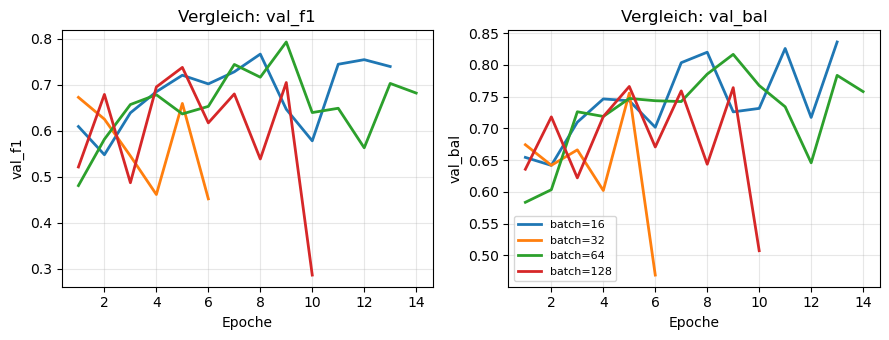


=== MODELLVERGLEICH (Train) ===
batch=128 | train_loss max=1.0534
batch=128 | val_loss max=1.3005
batch=16 | train_loss max=1.0200
batch=16 | val_loss max=0.8943
batch=32 | train_loss max=1.0135
batch=32 | val_loss max=1.4453
batch=64 | train_loss max=1.0528
batch=64 | val_loss max=0.9998


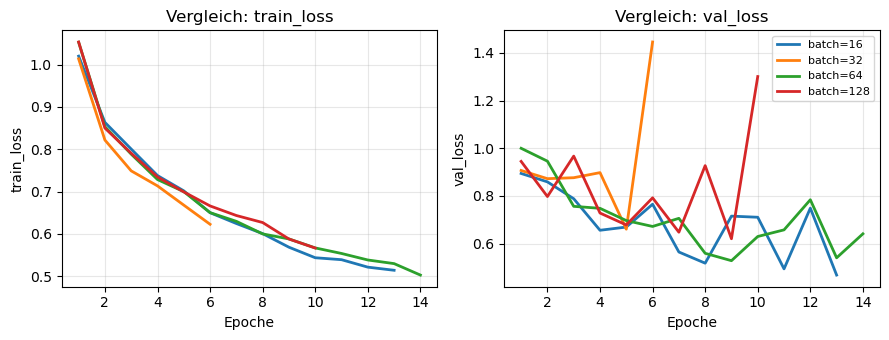


=== MODELLVERGLEICH (Test ROC) ===
batch=16 (micro AUC=0.939)
batch=32 (micro AUC=0.867)
batch=64 (micro AUC=0.938)
batch=128 (micro AUC=0.904)


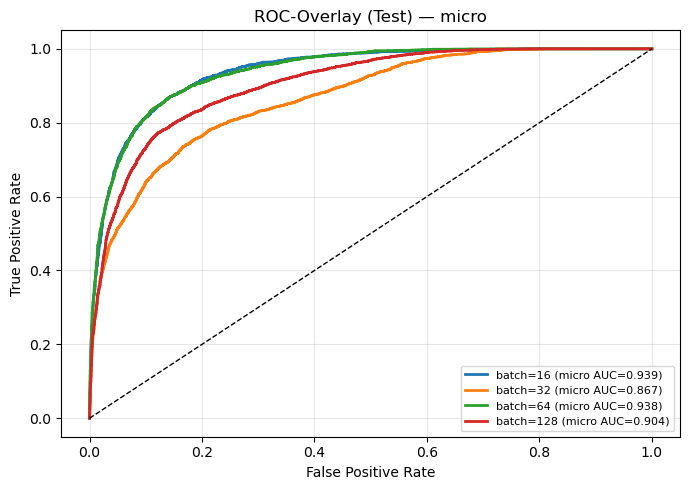


=== MODELLVERGLEICH (Test ROC) ===
batch=16 (COVID AUC=0.946)
batch=32 (COVID AUC=0.799)
batch=64 (COVID AUC=0.937)
batch=128 (COVID AUC=0.897)


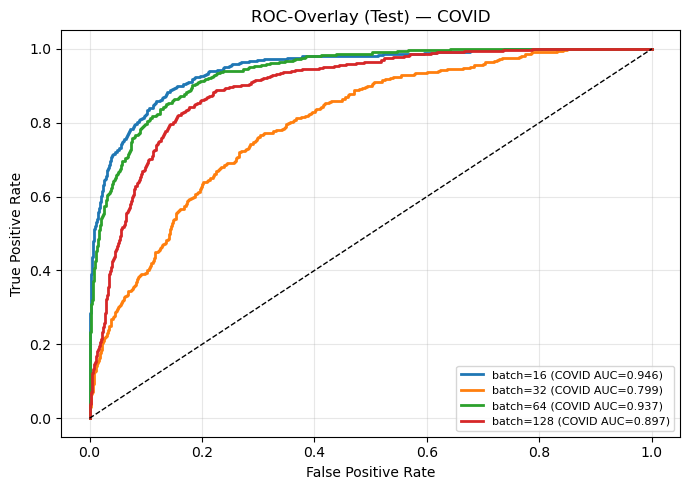


=== MODELLVERGLEICH (Test ROC) ===
batch=16 (Lung Opacity AUC=0.908)
batch=32 (Lung Opacity AUC=0.858)
batch=64 (Lung Opacity AUC=0.916)
batch=128 (Lung Opacity AUC=0.894)


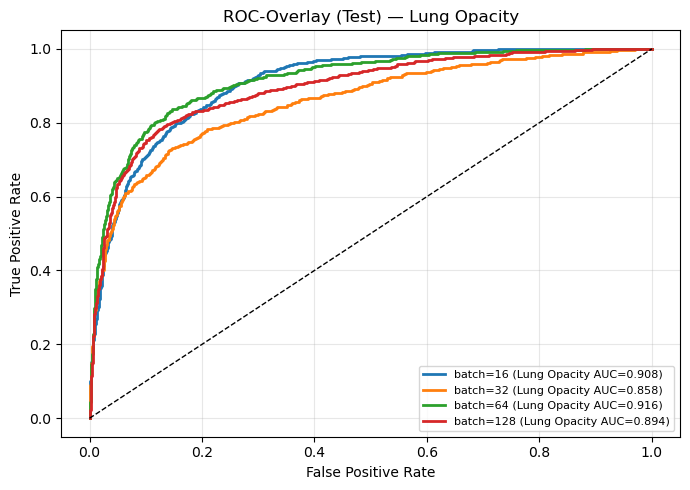


=== MODELLVERGLEICH (Test ROC) ===
batch=16 (Viral Pneumonia AUC=0.992)
batch=32 (Viral Pneumonia AUC=0.977)
batch=64 (Viral Pneumonia AUC=0.995)
batch=128 (Viral Pneumonia AUC=0.990)


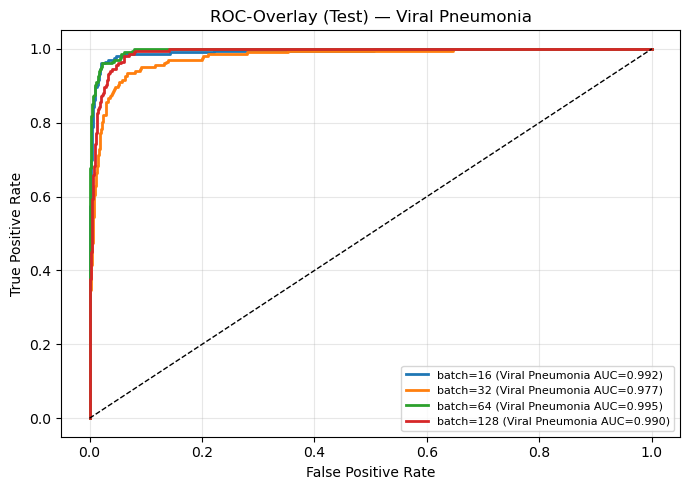

In [26]:
plot_train_overlays_multi(train_dirs, metrics=("val_f1","val_bal"))
plot_train_overlays_multi(train_dirs, metrics=("train_loss","val_loss"))

plot_test_roc_overlays(test_dirs, which="micro")
plot_test_roc_overlays(test_dirs, which="COVID")
plot_test_roc_overlays(test_dirs, which="Lung Opacity")
plot_test_roc_overlays(test_dirs, which="Viral Pneumonia")

In [27]:
train_dirs, test_dirs = run_sweep_train_test(
    "nomask",
    lrs=[1e-4, 1e-3, "auto"],
    fixed_batch=512,
    epochs=50
)


=== SWEEP RUN: batch=512 | lr=0.0001 ===

[TRAIN-START] Modus=nomask | Batch=512 | LR=0.0001 | Epochen=50 | Binary=False ==> Gerät: cuda


[train] Epoche 1/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 1/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 01: train_loss=1.3019 | val_loss=1.3556 | val_f1=0.286 | val_bal=0.461 | 36.33s


[train] Epoche 2/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 2/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 02: train_loss=1.2111 | val_loss=1.2190 | val_f1=0.305 | val_bal=0.493 | 35.62s


[train] Epoche 3/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 3/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 03: train_loss=1.1510 | val_loss=1.1466 | val_f1=0.434 | val_bal=0.563 | 35.81s


[train] Epoche 4/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 4/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 04: train_loss=1.1056 | val_loss=1.0960 | val_f1=0.491 | val_bal=0.595 | 35.50s


[train] Epoche 5/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 5/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 05: train_loss=1.0670 | val_loss=1.0544 | val_f1=0.524 | val_bal=0.620 | 35.56s


[train] Epoche 6/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 6/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 06: train_loss=1.0302 | val_loss=1.0259 | val_f1=0.515 | val_bal=0.624 | 35.41s


[train] Epoche 7/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 7/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 07: train_loss=1.0017 | val_loss=0.9982 | val_f1=0.598 | val_bal=0.655 | 35.70s


[train] Epoche 8/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 8/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 08: train_loss=0.9697 | val_loss=0.9652 | val_f1=0.547 | val_bal=0.643 | 36.03s


[train] Epoche 9/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 9/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 09: train_loss=0.9520 | val_loss=0.9469 | val_f1=0.580 | val_bal=0.669 | 35.96s


[train] Epoche 10/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 10/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 10: train_loss=0.9309 | val_loss=0.9246 | val_f1=0.616 | val_bal=0.666 | 36.41s


[train] Epoche 11/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 11/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 11: train_loss=0.9178 | val_loss=0.9183 | val_f1=0.591 | val_bal=0.665 | 35.75s


[train] Epoche 12/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 12/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 12: train_loss=0.8949 | val_loss=0.8853 | val_f1=0.615 | val_bal=0.694 | 35.62s


[train] Epoche 13/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 13/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 13: train_loss=0.8836 | val_loss=0.8819 | val_f1=0.597 | val_bal=0.695 | 36.05s


[train] Epoche 14/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 14/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 14: train_loss=0.8673 | val_loss=0.8799 | val_f1=0.616 | val_bal=0.687 | 36.30s


[train] Epoche 15/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 15/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 15: train_loss=0.8579 | val_loss=0.8461 | val_f1=0.610 | val_bal=0.682 | 36.12s


[train] Epoche 16/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 16/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 16: train_loss=0.8460 | val_loss=0.8516 | val_f1=0.669 | val_bal=0.692 | 35.60s


[train] Epoche 17/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 17/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 17: train_loss=0.8425 | val_loss=0.8399 | val_f1=0.627 | val_bal=0.706 | 35.63s


[train] Epoche 18/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 18/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 18: train_loss=0.8318 | val_loss=0.8479 | val_f1=0.615 | val_bal=0.689 | 35.82s


[train] Epoche 19/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 19/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 19: train_loss=0.8208 | val_loss=0.8126 | val_f1=0.658 | val_bal=0.713 | 35.29s


[train] Epoche 20/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 20/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 20: train_loss=0.8106 | val_loss=0.8032 | val_f1=0.639 | val_bal=0.722 | 36.55s


[train] Epoche 21/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 21/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 21: train_loss=0.7976 | val_loss=0.8243 | val_f1=0.693 | val_bal=0.709 | 35.60s


[train] Epoche 22/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 22/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 22: train_loss=0.7960 | val_loss=0.7934 | val_f1=0.655 | val_bal=0.704 | 35.21s


[train] Epoche 23/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 23/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 23: train_loss=0.7819 | val_loss=0.7685 | val_f1=0.655 | val_bal=0.717 | 35.28s


[train] Epoche 24/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 24/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 24: train_loss=0.7772 | val_loss=0.7998 | val_f1=0.633 | val_bal=0.707 | 35.51s


[train] Epoche 25/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 25/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 25: train_loss=0.7733 | val_loss=0.7528 | val_f1=0.680 | val_bal=0.734 | 35.81s


[train] Epoche 26/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 26/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 26: train_loss=0.7625 | val_loss=0.7400 | val_f1=0.677 | val_bal=0.732 | 36.06s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_29_2359_batch-512_lr-00001
=== TEST ===


[eval]:   0%|          | 0/7 [00:00<?, ?it/s]

[test] F1(macro)=0.687 | BalAcc=0.699 | Zeit=8.51s | /home/lupan001/ML/results/cnn_nomask_2025_08_29_2359_batch-512_lr-00001_test
[SWEEP] Modell=cnn_nomask_2025_08_29_2359_batch-512_lr-00001 | F1=0.687 | BalAcc=0.699

=== SWEEP RUN: batch=512 | lr=0.001 ===

[TRAIN-START] Modus=nomask | Batch=512 | LR=0.001 | Epochen=50 | Binary=False ==> Gerät: cuda


[train] Epoche 1/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 1/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 01: train_loss=1.1835 | val_loss=1.2985 | val_f1=0.291 | val_bal=0.433 | 36.69s


[train] Epoche 2/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 2/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 02: train_loss=0.9976 | val_loss=0.9896 | val_f1=0.522 | val_bal=0.638 | 35.75s


[train] Epoche 3/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 3/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 03: train_loss=0.9174 | val_loss=0.8652 | val_f1=0.608 | val_bal=0.662 | 36.02s


[train] Epoche 4/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 4/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 04: train_loss=0.8582 | val_loss=0.9155 | val_f1=0.469 | val_bal=0.607 | 35.46s


[train] Epoche 5/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 5/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 05: train_loss=0.8124 | val_loss=0.7951 | val_f1=0.637 | val_bal=0.689 | 35.75s


[train] Epoche 6/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 6/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 06: train_loss=0.7854 | val_loss=0.7763 | val_f1=0.622 | val_bal=0.685 | 35.98s


[train] Epoche 7/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 7/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 07: train_loss=0.7619 | val_loss=0.8689 | val_f1=0.522 | val_bal=0.673 | 35.81s


[train] Epoche 8/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 8/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 08: train_loss=0.7487 | val_loss=0.9762 | val_f1=0.649 | val_bal=0.623 | 36.10s


[train] Epoche 9/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 9/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 09: train_loss=0.7162 | val_loss=0.6829 | val_f1=0.684 | val_bal=0.746 | 36.19s


[train] Epoche 10/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 10/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 10: train_loss=0.7010 | val_loss=0.7304 | val_f1=0.704 | val_bal=0.728 | 36.43s


[train] Epoche 11/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 11/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 11: train_loss=0.6920 | val_loss=0.6491 | val_f1=0.693 | val_bal=0.751 | 35.79s


[train] Epoche 12/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 12/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 12: train_loss=0.6665 | val_loss=0.7048 | val_f1=0.650 | val_bal=0.729 | 35.45s


[train] Epoche 13/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 13/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 13: train_loss=0.6542 | val_loss=0.8186 | val_f1=0.642 | val_bal=0.681 | 35.69s


[train] Epoche 14/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 14/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 14: train_loss=0.6369 | val_loss=0.6832 | val_f1=0.640 | val_bal=0.727 | 35.96s


[train] Epoche 15/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 15/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 15: train_loss=0.6247 | val_loss=0.6535 | val_f1=0.751 | val_bal=0.742 | 36.31s


[train] Epoche 16/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 16/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 16: train_loss=0.6097 | val_loss=0.7640 | val_f1=0.737 | val_bal=0.710 | 36.62s


[train] Epoche 17/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 17/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 17: train_loss=0.6194 | val_loss=0.7466 | val_f1=0.608 | val_bal=0.692 | 35.69s


[train] Epoche 18/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 18/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 18: train_loss=0.5690 | val_loss=0.5760 | val_f1=0.774 | val_bal=0.782 | 35.54s


[train] Epoche 19/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 19/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 19: train_loss=0.5720 | val_loss=0.5544 | val_f1=0.715 | val_bal=0.785 | 35.62s


[train] Epoche 20/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 20/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 20: train_loss=0.5682 | val_loss=0.5715 | val_f1=0.754 | val_bal=0.785 | 35.89s


[train] Epoche 21/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 21/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 21: train_loss=0.5486 | val_loss=0.5938 | val_f1=0.689 | val_bal=0.762 | 35.96s


[train] Epoche 22/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 22/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 22: train_loss=0.5523 | val_loss=0.6048 | val_f1=0.761 | val_bal=0.789 | 35.80s


[train] Epoche 23/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 23/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 23: train_loss=0.5312 | val_loss=0.5758 | val_f1=0.779 | val_bal=0.773 | 35.68s


[train] Epoche 24/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 24/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 24: train_loss=0.5179 | val_loss=0.6880 | val_f1=0.768 | val_bal=0.740 | 36.43s


[train] Epoche 25/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 25/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 25: train_loss=0.5212 | val_loss=0.9039 | val_f1=0.440 | val_bal=0.620 | 36.25s


[train] Epoche 26/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 26/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 26: train_loss=0.5123 | val_loss=0.5102 | val_f1=0.784 | val_bal=0.810 | 36.33s


[train] Epoche 27/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 27/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 27: train_loss=0.4876 | val_loss=0.7719 | val_f1=0.641 | val_bal=0.708 | 36.16s


[train] Epoche 28/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 28/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 28: train_loss=0.5057 | val_loss=0.6221 | val_f1=0.694 | val_bal=0.772 | 36.21s


[train] Epoche 29/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 29/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 29: train_loss=0.4986 | val_loss=0.8230 | val_f1=0.734 | val_bal=0.719 | 38.67s


[train] Epoche 30/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 30/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 30: train_loss=0.5174 | val_loss=0.5266 | val_f1=0.733 | val_bal=0.786 | 40.19s


[train] Epoche 31/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 31/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 31: train_loss=0.4904 | val_loss=0.4688 | val_f1=0.789 | val_bal=0.819 | 39.77s


[train] Epoche 32/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 32/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 32: train_loss=0.4702 | val_loss=0.4859 | val_f1=0.831 | val_bal=0.822 | 39.47s


[train] Epoche 33/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 33/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 33: train_loss=0.4601 | val_loss=0.4667 | val_f1=0.831 | val_bal=0.824 | 38.86s


[train] Epoche 34/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 34/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 34: train_loss=0.4617 | val_loss=0.6360 | val_f1=0.662 | val_bal=0.775 | 40.26s


[train] Epoche 35/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 35/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 35: train_loss=0.4632 | val_loss=0.5641 | val_f1=0.689 | val_bal=0.787 | 39.89s


[train] Epoche 36/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 36/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 36: train_loss=0.4669 | val_loss=0.7376 | val_f1=0.622 | val_bal=0.679 | 38.39s


[train] Epoche 37/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 37/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 37: train_loss=0.4798 | val_loss=0.6363 | val_f1=0.614 | val_bal=0.749 | 38.12s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_30_0015_batch-512_lr-0001
=== TEST ===


[eval]:   0%|          | 0/7 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f296b158ea0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f296b158ea0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py", l

[test] F1(macro)=0.817 | BalAcc=0.811 | Zeit=9.60s | /home/lupan001/ML/results/cnn_nomask_2025_08_30_0015_batch-512_lr-0001_test
[SWEEP] Modell=cnn_nomask_2025_08_30_0015_batch-512_lr-0001 | F1=0.817 | BalAcc=0.811

=== SWEEP RUN: batch=512 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=0.9416 @idx=199 → vorgeschlagene LR=2.000e-02
[lr-finder] gewählte Start-LR: 2.000e-02

[TRAIN-START] Modus=nomask | Batch=512 | LR=0.020000000000000268 | Epochen=50 | Binary=False ==> Gerät: cuda


[train] Epoche 1/50:   0%|          | 0/29 [00:02<?, ?it/s]

[val] Epoche 1/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 01: train_loss=1.3121 | val_loss=1.2940 | val_f1=0.252 | val_bal=0.352 | 41.99s


[train] Epoche 2/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 2/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 02: train_loss=1.0805 | val_loss=1.0518 | val_f1=0.393 | val_bal=0.557 | 40.11s


[train] Epoche 3/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 3/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 03: train_loss=0.9642 | val_loss=0.8935 | val_f1=0.561 | val_bal=0.652 | 38.88s


[train] Epoche 4/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 4/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 04: train_loss=0.8619 | val_loss=1.1572 | val_f1=0.569 | val_bal=0.559 | 39.27s


[train] Epoche 5/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 5/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 05: train_loss=0.8249 | val_loss=1.1389 | val_f1=0.389 | val_bal=0.569 | 39.25s


[train] Epoche 6/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 6/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 06: train_loss=0.7795 | val_loss=0.8502 | val_f1=0.553 | val_bal=0.685 | 38.41s


[train] Epoche 7/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 7/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 07: train_loss=0.7615 | val_loss=0.9583 | val_f1=0.568 | val_bal=0.635 | 38.25s


[train] Epoche 8/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 8/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 08: train_loss=0.7290 | val_loss=0.7902 | val_f1=0.702 | val_bal=0.678 | 38.22s


[train] Epoche 9/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 9/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 09: train_loss=0.6915 | val_loss=0.8177 | val_f1=0.592 | val_bal=0.674 | 39.12s


[train] Epoche 10/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 10/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 10: train_loss=0.6700 | val_loss=0.6779 | val_f1=0.694 | val_bal=0.747 | 39.06s


[train] Epoche 11/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 11/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 11: train_loss=0.6624 | val_loss=0.7267 | val_f1=0.636 | val_bal=0.733 | 39.27s


[train] Epoche 12/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 12/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 12: train_loss=0.6233 | val_loss=0.8383 | val_f1=0.496 | val_bal=0.639 | 39.00s


[train] Epoche 13/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 13/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 13: train_loss=0.6046 | val_loss=0.5551 | val_f1=0.727 | val_bal=0.800 | 39.38s


[train] Epoche 14/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 14/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 14: train_loss=0.5888 | val_loss=0.8773 | val_f1=0.692 | val_bal=0.656 | 38.91s


[train] Epoche 15/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 15/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 15: train_loss=0.5860 | val_loss=0.7543 | val_f1=0.575 | val_bal=0.707 | 39.48s


[train] Epoche 16/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 16/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 16: train_loss=0.5594 | val_loss=0.5900 | val_f1=0.769 | val_bal=0.795 | 38.91s


[train] Epoche 17/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 17/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 17: train_loss=0.5474 | val_loss=0.7602 | val_f1=0.712 | val_bal=0.721 | 39.26s


[train] Epoche 18/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 18/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 18: train_loss=0.5360 | val_loss=0.8390 | val_f1=0.737 | val_bal=0.726 | 39.27s


[train] Epoche 19/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 19/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 19: train_loss=0.5363 | val_loss=0.7253 | val_f1=0.624 | val_bal=0.722 | 39.30s


[train] Epoche 20/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 20/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 20: train_loss=0.5009 | val_loss=0.6731 | val_f1=0.706 | val_bal=0.762 | 39.89s


[train] Epoche 21/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 21/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 21: train_loss=0.4807 | val_loss=0.5386 | val_f1=0.764 | val_bal=0.803 | 39.49s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_30_0038_batch-512_lr-0020000000000000268
=== TEST ===


[eval]:   0%|          | 0/7 [00:00<?, ?it/s]

[test] F1(macro)=0.765 | BalAcc=0.796 | Zeit=9.05s | /home/lupan001/ML/results/cnn_nomask_2025_08_30_0038_batch-512_lr-0020000000000000268_test
[SWEEP] Modell=cnn_nomask_2025_08_30_0038_batch-512_lr-0020000000000000268 | F1=0.765 | BalAcc=0.796



=== MODELLVERGLEICH (Train) ===
lr=0.0001 | val_bal max=0.8241
lr=0.0001 | val_f1 max=0.8311
lr=0.002 | val_bal max=0.8033
lr=0.002 | val_f1 max=0.7693
lr=1e-05 | val_bal max=0.7341
lr=1e-05 | val_f1 max=0.6929


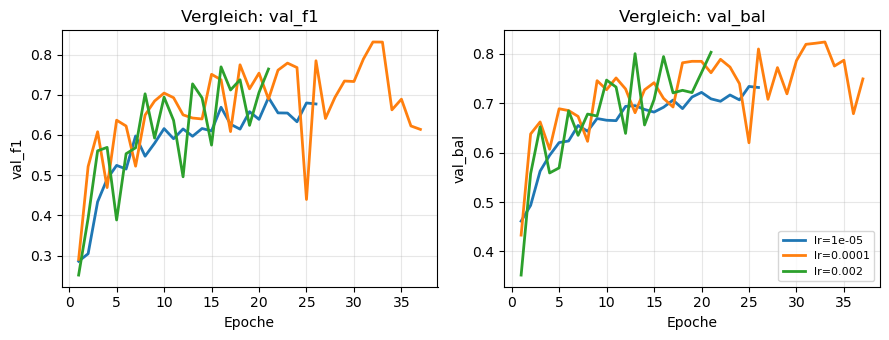


=== MODELLVERGLEICH (Train) ===
lr=0.0001 | train_loss max=1.1835
lr=0.0001 | val_loss max=1.2985
lr=0.002 | train_loss max=1.3121
lr=0.002 | val_loss max=1.2940
lr=1e-05 | train_loss max=1.3019
lr=1e-05 | val_loss max=1.3556


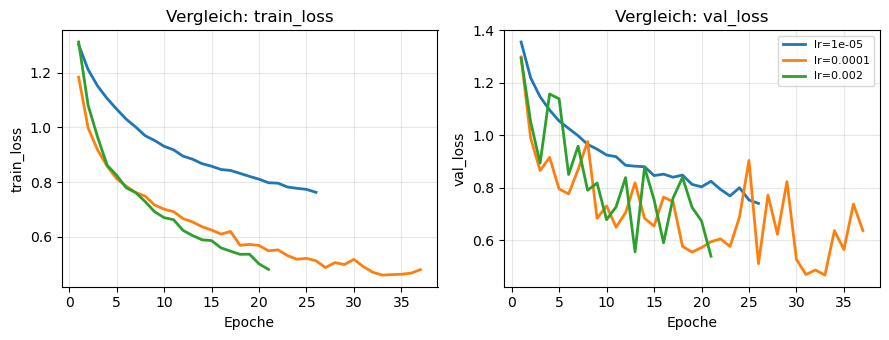


=== MODELLVERGLEICH (Test ROC) ===
lr=1e-05 (micro AUC=0.892)
lr=0.0001 (micro AUC=0.958)
lr=0.002 (micro AUC=0.920)


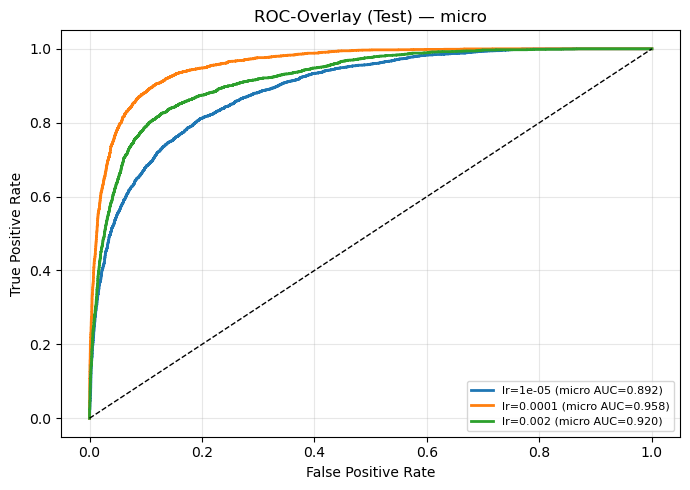


=== MODELLVERGLEICH (Test ROC) ===
lr=1e-05 (COVID AUC=0.832)
lr=0.0001 (COVID AUC=0.969)
lr=0.002 (COVID AUC=0.928)


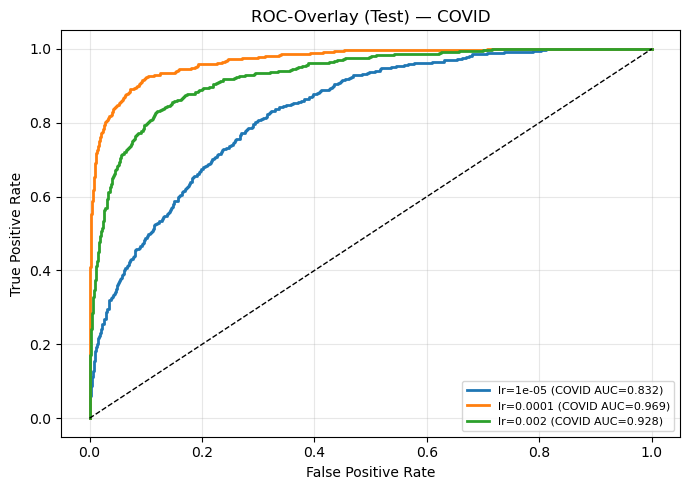


=== MODELLVERGLEICH (Test ROC) ===
lr=1e-05 (Lung Opacity AUC=0.859)
lr=0.0001 (Lung Opacity AUC=0.925)
lr=0.002 (Lung Opacity AUC=0.903)


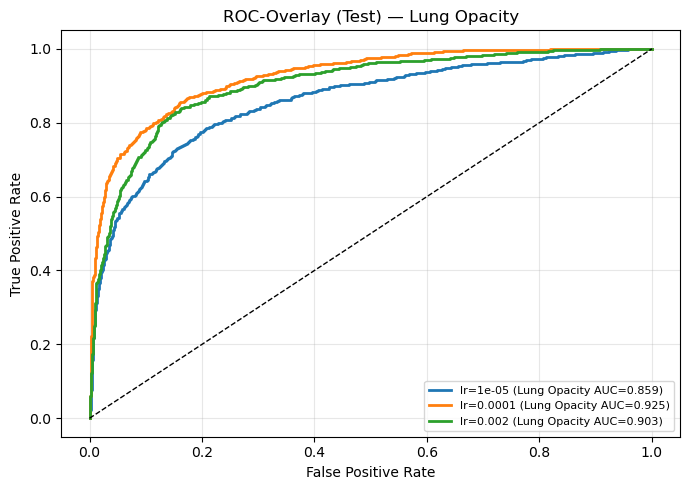


=== MODELLVERGLEICH (Test ROC) ===
lr=1e-05 (Viral Pneumonia AUC=0.984)
lr=0.0001 (Viral Pneumonia AUC=0.996)
lr=0.002 (Viral Pneumonia AUC=0.991)


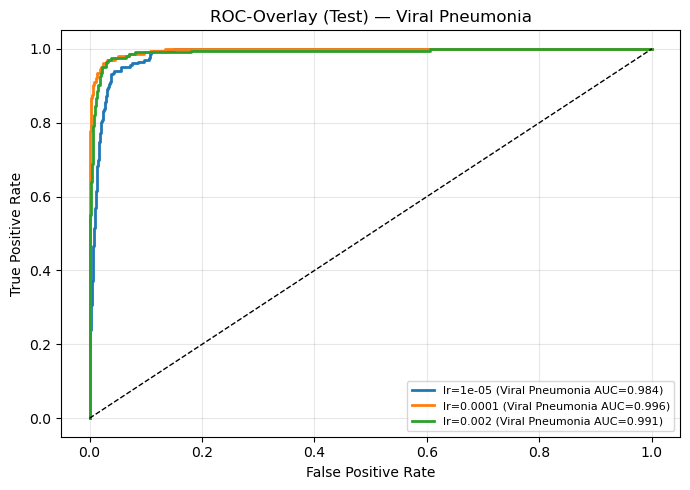

In [28]:
plot_train_overlays_multi(train_dirs, metrics=("val_f1","val_bal"))
plot_train_overlays_multi(train_dirs, metrics=("train_loss","val_loss"))

plot_test_roc_overlays(test_dirs, which="micro")
plot_test_roc_overlays(test_dirs, which="COVID")
plot_test_roc_overlays(test_dirs, which="Lung Opacity")
plot_test_roc_overlays(test_dirs, which="Viral Pneumonia")

In [29]:
train_dirs, test_dirs = run_sweep_train_test(
    "mask",
    lrs=[1e-4, 1e-3, "auto"],
    fixed_batch=256,
    epochs=50
)



=== SWEEP RUN: batch=512 | lr=0.0001 ===

[TRAIN-START] Modus=mask | Batch=512 | LR=0.0001 | Epochen=50 | Binary=False ==> Gerät: cuda


[train] Epoche 1/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 1/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 01: train_loss=1.3862 | val_loss=1.4068 | val_f1=0.111 | val_bal=0.250 | 63.36s


[train] Epoche 2/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 2/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 02: train_loss=1.3182 | val_loss=1.3106 | val_f1=0.334 | val_bal=0.373 | 63.15s


[train] Epoche 3/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 3/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 03: train_loss=1.2903 | val_loss=1.2695 | val_f1=0.469 | val_bal=0.523 | 63.33s


[train] Epoche 4/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 4/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 04: train_loss=1.2702 | val_loss=1.2492 | val_f1=0.442 | val_bal=0.523 | 61.89s


[train] Epoche 5/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 5/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 05: train_loss=1.2536 | val_loss=1.2358 | val_f1=0.509 | val_bal=0.498 | 62.22s


[train] Epoche 6/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 6/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 06: train_loss=1.2264 | val_loss=1.2043 | val_f1=0.439 | val_bal=0.528 | 61.95s


[train] Epoche 7/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 7/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 07: train_loss=1.2011 | val_loss=1.2042 | val_f1=0.481 | val_bal=0.463 | 62.49s


[train] Epoche 8/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 8/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 08: train_loss=1.1745 | val_loss=1.1637 | val_f1=0.520 | val_bal=0.574 | 61.68s


[train] Epoche 9/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 9/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 09: train_loss=1.1413 | val_loss=1.1445 | val_f1=0.550 | val_bal=0.548 | 62.79s


[train] Epoche 10/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 10/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 10: train_loss=1.1123 | val_loss=1.0905 | val_f1=0.490 | val_bal=0.596 | 62.14s


[train] Epoche 11/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 11/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 11: train_loss=1.0841 | val_loss=1.1139 | val_f1=0.554 | val_bal=0.520 | 63.17s


[train] Epoche 12/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 12/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 12: train_loss=1.0566 | val_loss=1.0380 | val_f1=0.542 | val_bal=0.605 | 62.99s


[train] Epoche 13/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 13/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 13: train_loss=1.0328 | val_loss=1.1054 | val_f1=0.564 | val_bal=0.557 | 62.81s


[train] Epoche 14/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 14/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 14: train_loss=1.0138 | val_loss=0.9930 | val_f1=0.586 | val_bal=0.652 | 61.42s


[train] Epoche 15/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 15/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 15: train_loss=0.9911 | val_loss=1.0438 | val_f1=0.478 | val_bal=0.553 | 62.64s


[train] Epoche 16/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 16/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 16: train_loss=0.9725 | val_loss=0.9752 | val_f1=0.640 | val_bal=0.650 | 63.92s


[train] Epoche 17/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 17/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 17: train_loss=0.9531 | val_loss=0.9359 | val_f1=0.573 | val_bal=0.667 | 64.29s


[train] Epoche 18/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 18/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 18: train_loss=0.9400 | val_loss=0.9299 | val_f1=0.640 | val_bal=0.671 | 62.79s


[train] Epoche 19/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 19/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 19: train_loss=0.9220 | val_loss=0.9040 | val_f1=0.594 | val_bal=0.675 | 61.86s


[train] Epoche 20/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 20/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 20: train_loss=0.9143 | val_loss=0.9049 | val_f1=0.598 | val_bal=0.665 | 62.29s


[train] Epoche 21/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 21/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 21: train_loss=0.9011 | val_loss=0.8840 | val_f1=0.571 | val_bal=0.669 | 62.80s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_mask_2025_08_30_0055_batch-512_lr-00001
=== TEST ===


[eval]:   0%|          | 0/7 [00:00<?, ?it/s]

[test] F1(macro)=0.630 | BalAcc=0.641 | Zeit=14.78s | /home/lupan001/ML/results/cnn_mask_2025_08_30_0055_batch-512_lr-00001_test
[SWEEP] Modell=cnn_mask_2025_08_30_0055_batch-512_lr-00001 | F1=0.630 | BalAcc=0.641

=== SWEEP RUN: batch=512 | lr=0.001 ===

[TRAIN-START] Modus=mask | Batch=512 | LR=0.001 | Epochen=50 | Binary=False ==> Gerät: cuda


[train] Epoche 1/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 1/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 01: train_loss=1.2891 | val_loss=1.4003 | val_f1=0.291 | val_bal=0.350 | 63.26s


[train] Epoche 2/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 2/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 02: train_loss=1.1390 | val_loss=1.7977 | val_f1=0.163 | val_bal=0.250 | 61.56s


[train] Epoche 3/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 3/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 03: train_loss=1.0409 | val_loss=1.1829 | val_f1=0.405 | val_bal=0.403 | 61.60s


[train] Epoche 4/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 4/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 04: train_loss=0.9488 | val_loss=2.4469 | val_f1=0.175 | val_bal=0.256 | 62.57s


[train] Epoche 5/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 5/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 05: train_loss=0.9261 | val_loss=1.2287 | val_f1=0.384 | val_bal=0.380 | 62.02s


[train] Epoche 6/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 6/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 06: train_loss=0.8602 | val_loss=1.0002 | val_f1=0.428 | val_bal=0.561 | 61.02s


[train] Epoche 7/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 7/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 07: train_loss=0.8202 | val_loss=1.4286 | val_f1=0.251 | val_bal=0.433 | 62.47s


[train] Epoche 8/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 8/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 08: train_loss=0.7947 | val_loss=0.9232 | val_f1=0.494 | val_bal=0.586 | 62.77s


[train] Epoche 9/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 9/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 09: train_loss=0.7829 | val_loss=0.7782 | val_f1=0.562 | val_bal=0.660 | 61.59s


[train] Epoche 10/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 10/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 10: train_loss=0.7671 | val_loss=1.0675 | val_f1=0.412 | val_bal=0.536 | 62.40s


[train] Epoche 11/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 11/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 11: train_loss=0.7560 | val_loss=0.9573 | val_f1=0.557 | val_bal=0.570 | 59.45s


[train] Epoche 12/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 12/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 12: train_loss=0.7392 | val_loss=0.9150 | val_f1=0.557 | val_bal=0.574 | 58.21s


[train] Epoche 13/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 13/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 13: train_loss=0.7305 | val_loss=0.9358 | val_f1=0.446 | val_bal=0.578 | 58.90s


[train] Epoche 14/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 14/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 14: train_loss=0.7293 | val_loss=0.9312 | val_f1=0.500 | val_bal=0.626 | 59.01s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_mask_2025_08_30_0118_batch-512_lr-0001
=== TEST ===


[eval]:   0%|          | 0/7 [00:00<?, ?it/s]

[test] F1(macro)=0.547 | BalAcc=0.646 | Zeit=14.49s | /home/lupan001/ML/results/cnn_mask_2025_08_30_0118_batch-512_lr-0001_test
[SWEEP] Modell=cnn_mask_2025_08_30_0118_batch-512_lr-0001 | F1=0.547 | BalAcc=0.646

=== SWEEP RUN: batch=512 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.0757 @idx=184 → vorgeschlagene LR=9.989e-03
[lr-finder] gewählte Start-LR: 9.989e-03

[TRAIN-START] Modus=mask | Batch=512 | LR=0.009989010231710404 | Epochen=50 | Binary=False ==> Gerät: cuda


[train] Epoche 1/50:   0%|          | 0/29 [00:03<?, ?it/s]

[val] Epoche 1/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 01: train_loss=1.3336 | val_loss=1.4207 | val_f1=0.219 | val_bal=0.305 | 61.28s


[train] Epoche 2/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 2/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 02: train_loss=1.1779 | val_loss=20.4283 | val_f1=0.030 | val_bal=0.250 | 58.59s


[train] Epoche 3/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 3/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 03: train_loss=1.0404 | val_loss=2.5918 | val_f1=0.128 | val_bal=0.257 | 56.05s


[train] Epoche 4/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 4/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 04: train_loss=0.9609 | val_loss=4.1241 | val_f1=0.133 | val_bal=0.262 | 56.73s


[train] Epoche 5/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 5/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 05: train_loss=0.8831 | val_loss=5.3069 | val_f1=0.307 | val_bal=0.359 | 57.50s


[train] Epoche 6/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 6/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 06: train_loss=0.8490 | val_loss=3.6617 | val_f1=0.205 | val_bal=0.389 | 57.04s


[train] Epoche 7/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 7/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 07: train_loss=0.8257 | val_loss=11.4572 | val_f1=0.177 | val_bal=0.356 | 56.88s


[train] Epoche 8/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 8/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 08: train_loss=0.8208 | val_loss=10.1399 | val_f1=0.229 | val_bal=0.288 | 57.95s


[train] Epoche 9/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 9/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 09: train_loss=0.7838 | val_loss=1.4094 | val_f1=0.294 | val_bal=0.495 | 56.69s


[train] Epoche 10/50:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 10/50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 10: train_loss=0.7875 | val_loss=12.7519 | val_f1=0.034 | val_bal=0.252 | 57.95s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_mask_2025_08_30_0132_batch-512_lr-0009989010231710404
=== TEST ===


[eval]:   0%|          | 0/7 [00:00<?, ?it/s]

[test] F1(macro)=0.318 | BalAcc=0.372 | Zeit=13.64s | /home/lupan001/ML/results/cnn_mask_2025_08_30_0132_batch-512_lr-0009989010231710404_test
[SWEEP] Modell=cnn_mask_2025_08_30_0132_batch-512_lr-0009989010231710404 | F1=0.318 | BalAcc=0.372



=== MODELLVERGLEICH (Train) ===
lr=0.0001 | val_bal max=0.6601
lr=0.0001 | val_f1 max=0.5621
lr=0.0009989 | val_bal max=0.4949
lr=0.0009989 | val_f1 max=0.3068
lr=1e-05 | val_bal max=0.6755
lr=1e-05 | val_f1 max=0.6403


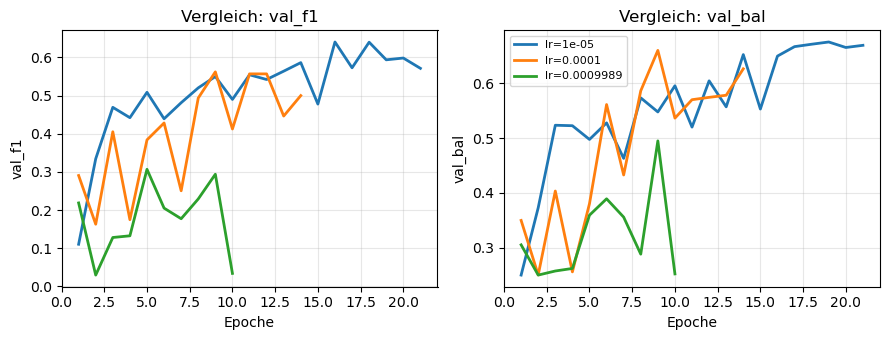


=== MODELLVERGLEICH (Train) ===
lr=0.0001 | train_loss max=1.2891
lr=0.0001 | val_loss max=2.4469
lr=0.0009989 | train_loss max=1.3336
lr=0.0009989 | val_loss max=20.4283
lr=1e-05 | train_loss max=1.3862
lr=1e-05 | val_loss max=1.4068


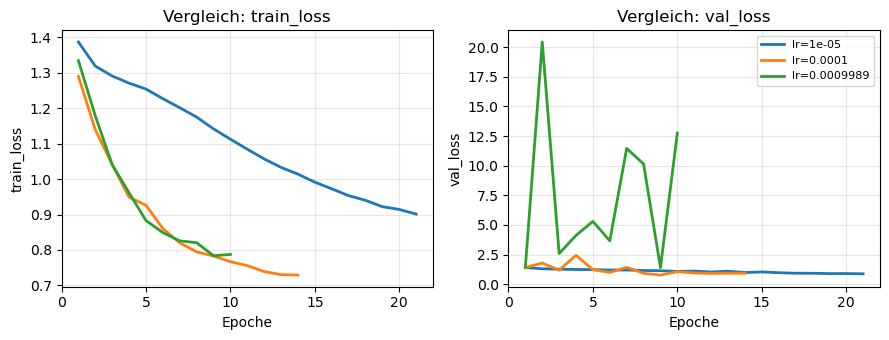


=== MODELLVERGLEICH (Test ROC) ===
lr=1e-05 (micro AUC=0.878)
lr=0.0001 (micro AUC=0.893)
lr=0.0009989 (micro AUC=0.648)


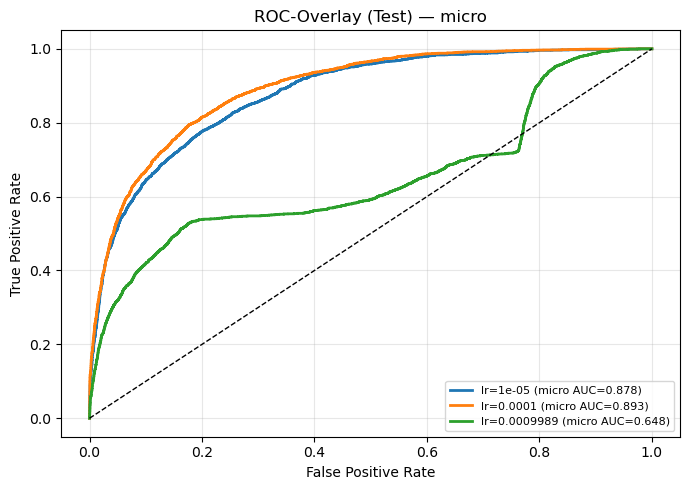


=== MODELLVERGLEICH (Test ROC) ===
lr=1e-05 (COVID AUC=0.735)
lr=0.0001 (COVID AUC=0.769)
lr=0.0009989 (COVID AUC=0.644)


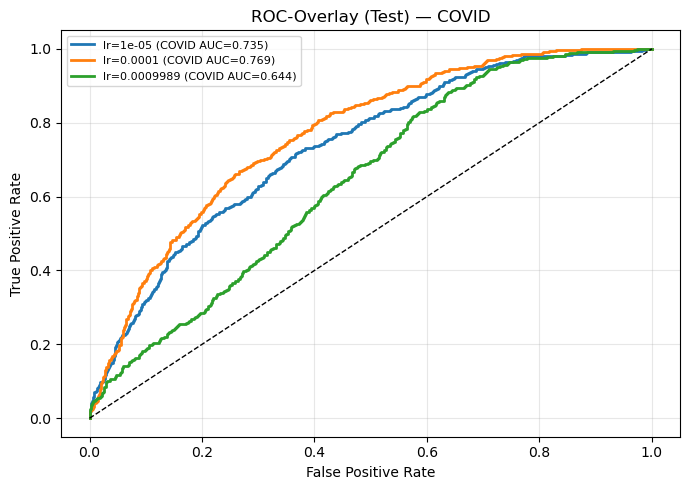


=== MODELLVERGLEICH (Test ROC) ===
lr=1e-05 (Lung Opacity AUC=0.859)
lr=0.0001 (Lung Opacity AUC=0.885)
lr=0.0009989 (Lung Opacity AUC=0.841)


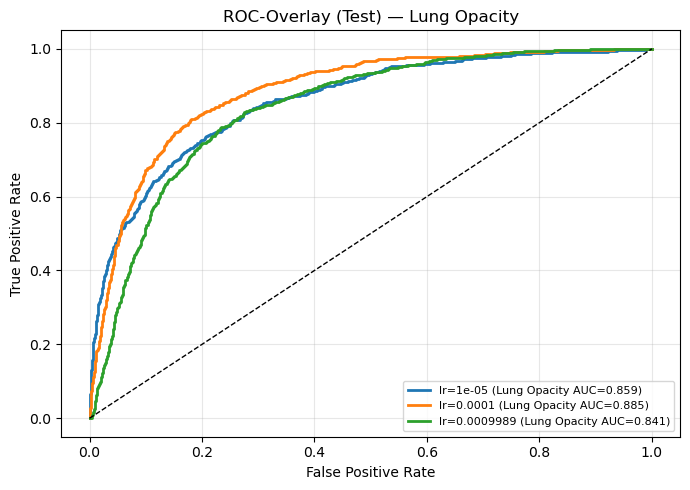


=== MODELLVERGLEICH (Test ROC) ===
lr=1e-05 (Viral Pneumonia AUC=0.956)
lr=0.0001 (Viral Pneumonia AUC=0.983)
lr=0.0009989 (Viral Pneumonia AUC=0.960)


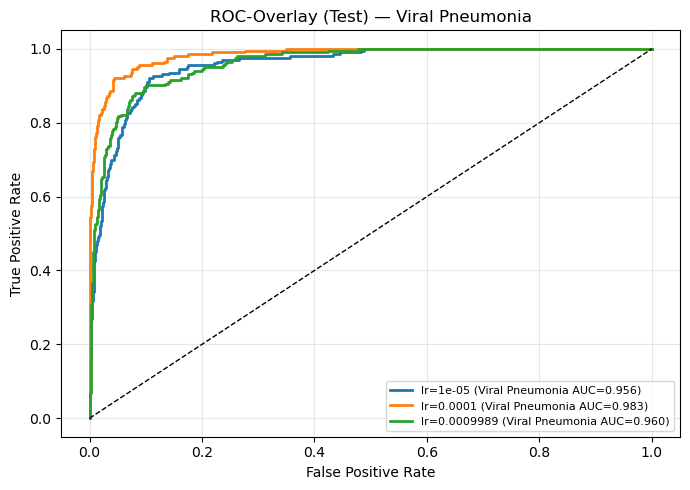

In [30]:
plot_train_overlays_multi(train_dirs, metrics=("val_f1","val_bal"))
plot_train_overlays_multi(train_dirs, metrics=("train_loss","val_loss"))

plot_test_roc_overlays(test_dirs, which="micro")
plot_test_roc_overlays(test_dirs, which="COVID")
plot_test_roc_overlays(test_dirs, which="Lung Opacity")
plot_test_roc_overlays(test_dirs, which="Viral Pneumonia")

In [31]:
train_dirs, test_dirs = run_sweep_train_test(
    "nomask",
    batches=[128, 256, 512, 1024],
    fixed_lr="auto",
    epochs=512
)


=== SWEEP RUN: batch=128 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.0616 @idx=182 → vorgeschlagene LR=9.106e-03
[lr-finder] gewählte Start-LR: 9.106e-03

[TRAIN-START] Modus=nomask | Batch=128 | LR=0.00910587014973401 | Epochen=512 | Binary=False ==> Gerät: cuda


[train] Epoche 1/512:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 1/512:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 01: train_loss=1.0885 | val_loss=1.7510 | val_f1=0.402 | val_bal=0.405 | 31.55s


[train] Epoche 2/512:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 2/512:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 02: train_loss=0.8699 | val_loss=0.9412 | val_f1=0.573 | val_bal=0.653 | 31.23s


[train] Epoche 3/512:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 3/512:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 03: train_loss=0.8078 | val_loss=0.7870 | val_f1=0.666 | val_bal=0.697 | 30.75s


[train] Epoche 4/512:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 4/512:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 04: train_loss=0.7540 | val_loss=0.9675 | val_f1=0.523 | val_bal=0.615 | 30.89s


[train] Epoche 5/512:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 5/512:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 05: train_loss=0.7110 | val_loss=0.8445 | val_f1=0.462 | val_bal=0.611 | 30.64s


[train] Epoche 6/512:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 6/512:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 06: train_loss=0.6487 | val_loss=0.6051 | val_f1=0.765 | val_bal=0.779 | 30.87s


[train] Epoche 7/512:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 7/512:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 07: train_loss=0.6006 | val_loss=0.6053 | val_f1=0.758 | val_bal=0.762 | 30.83s


[train] Epoche 8/512:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 8/512:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 08: train_loss=0.5985 | val_loss=0.5607 | val_f1=0.693 | val_bal=0.792 | 30.60s


[train] Epoche 9/512:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 9/512:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 09: train_loss=0.5650 | val_loss=0.6847 | val_f1=0.705 | val_bal=0.739 | 30.64s


[train] Epoche 10/512:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 10/512:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 10: train_loss=0.5429 | val_loss=0.4990 | val_f1=0.751 | val_bal=0.821 | 30.38s


[train] Epoche 11/512:   0%|          | 0/116 [00:00<?, ?it/s]

[val] Epoche 11/512:   0%|          | 0/25 [00:00<?, ?it/s]

Epoche 11: train_loss=0.5215 | val_loss=0.6020 | val_f1=0.655 | val_bal=0.775 | 30.45s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_30_0147_batch-128_lr-000910587014973401
=== TEST ===


[eval]:   0%|          | 0/25 [00:00<?, ?it/s]

[test] F1(macro)=0.760 | BalAcc=0.775 | Zeit=6.05s | /home/lupan001/ML/results/cnn_nomask_2025_08_30_0147_batch-128_lr-000910587014973401_test
[SWEEP] Modell=cnn_nomask_2025_08_30_0147_batch-128_lr-000910587014973401 | F1=0.760 | BalAcc=0.775

=== SWEEP RUN: batch=256 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.0316 @idx=178 → vorgeschlagene LR=7.567e-03
[lr-finder] gewählte Start-LR: 7.567e-03

[TRAIN-START] Modus=nomask | Batch=256 | LR=0.007566925234263951 | Epochen=512 | Binary=False ==> Gerät: cuda


[train] Epoche 1/512:   0%|          | 0/58 [00:01<?, ?it/s]

[val] Epoche 1/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 01: train_loss=1.1469 | val_loss=0.9904 | val_f1=0.571 | val_bal=0.635 | 34.48s


[train] Epoche 2/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 2/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 02: train_loss=0.8990 | val_loss=0.8964 | val_f1=0.648 | val_bal=0.663 | 32.94s


[train] Epoche 3/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 3/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 03: train_loss=0.8077 | val_loss=1.0565 | val_f1=0.611 | val_bal=0.580 | 33.23s


[train] Epoche 4/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 4/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 04: train_loss=0.7723 | val_loss=0.7694 | val_f1=0.588 | val_bal=0.710 | 33.39s


[train] Epoche 5/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 5/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 05: train_loss=0.7370 | val_loss=0.6574 | val_f1=0.689 | val_bal=0.750 | 33.38s


[train] Epoche 6/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 6/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 06: train_loss=0.6792 | val_loss=0.7325 | val_f1=0.708 | val_bal=0.715 | 33.09s


[train] Epoche 7/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 7/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 07: train_loss=0.6652 | val_loss=0.6396 | val_f1=0.766 | val_bal=0.766 | 32.54s


[train] Epoche 8/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 8/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 08: train_loss=0.6286 | val_loss=0.6674 | val_f1=0.709 | val_bal=0.762 | 32.33s


[train] Epoche 9/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 9/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 09: train_loss=0.5864 | val_loss=0.6564 | val_f1=0.647 | val_bal=0.757 | 32.41s


[train] Epoche 10/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 10/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 10: train_loss=0.5738 | val_loss=0.5069 | val_f1=0.770 | val_bal=0.827 | 32.83s


[train] Epoche 11/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 11/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 11: train_loss=0.5705 | val_loss=0.5438 | val_f1=0.716 | val_bal=0.788 | 32.67s


[train] Epoche 12/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 12/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 12: train_loss=0.5177 | val_loss=0.5073 | val_f1=0.803 | val_bal=0.805 | 32.85s


[train] Epoche 13/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 13/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 13: train_loss=0.5114 | val_loss=0.7478 | val_f1=0.721 | val_bal=0.717 | 33.58s


[train] Epoche 14/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 14/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 14: train_loss=0.5055 | val_loss=0.7069 | val_f1=0.629 | val_bal=0.735 | 32.85s


[train] Epoche 15/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 15/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 15: train_loss=0.4928 | val_loss=0.6999 | val_f1=0.700 | val_bal=0.716 | 33.31s


[train] Epoche 16/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 16/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 16: train_loss=0.4672 | val_loss=0.4425 | val_f1=0.817 | val_bal=0.843 | 32.96s


[train] Epoche 17/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 17/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 17: train_loss=0.4672 | val_loss=0.5546 | val_f1=0.697 | val_bal=0.772 | 33.16s


[train] Epoche 18/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 18/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 18: train_loss=0.4497 | val_loss=0.6231 | val_f1=0.676 | val_bal=0.756 | 33.48s


[train] Epoche 19/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 19/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 19: train_loss=0.4464 | val_loss=0.8864 | val_f1=0.695 | val_bal=0.672 | 33.11s


[train] Epoche 20/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 20/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 20: train_loss=0.4468 | val_loss=0.5485 | val_f1=0.713 | val_bal=0.781 | 33.14s


[train] Epoche 21/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 21/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 21: train_loss=0.4394 | val_loss=0.4264 | val_f1=0.854 | val_bal=0.848 | 32.80s


[train] Epoche 22/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 22/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 22: train_loss=0.4139 | val_loss=0.4114 | val_f1=0.838 | val_bal=0.847 | 33.22s


[train] Epoche 23/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 23/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 23: train_loss=0.4225 | val_loss=0.6865 | val_f1=0.721 | val_bal=0.719 | 33.13s


[train] Epoche 24/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 24/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 24: train_loss=0.4137 | val_loss=0.6990 | val_f1=0.655 | val_bal=0.714 | 32.32s


[train] Epoche 25/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 25/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 25: train_loss=0.3902 | val_loss=0.3941 | val_f1=0.879 | val_bal=0.871 | 32.73s


[train] Epoche 26/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 26/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 26: train_loss=0.3874 | val_loss=0.8445 | val_f1=0.725 | val_bal=0.688 | 32.94s


[train] Epoche 27/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 27/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 27: train_loss=0.3814 | val_loss=0.6118 | val_f1=0.732 | val_bal=0.753 | 33.34s


[train] Epoche 28/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 28/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 28: train_loss=0.3956 | val_loss=0.4164 | val_f1=0.793 | val_bal=0.843 | 32.77s


[train] Epoche 29/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 29/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 29: train_loss=0.3752 | val_loss=0.5572 | val_f1=0.740 | val_bal=0.826 | 32.55s


[train] Epoche 30/512:   0%|          | 0/58 [00:00<?, ?it/s]

[val] Epoche 30/512:   0%|          | 0/13 [00:00<?, ?it/s]

Epoche 30: train_loss=0.3683 | val_loss=0.5386 | val_f1=0.818 | val_bal=0.800 | 32.94s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_30_0154_batch-256_lr-0007566925234263951
=== TEST ===


[eval]:   0%|          | 0/13 [00:00<?, ?it/s]

[test] F1(macro)=0.870 | BalAcc=0.863 | Zeit=7.10s | /home/lupan001/ML/results/cnn_nomask_2025_08_30_0154_batch-256_lr-0007566925234263951_test
[SWEEP] Modell=cnn_nomask_2025_08_30_0154_batch-256_lr-0007566925234263951 | F1=0.870 | BalAcc=0.863

=== SWEEP RUN: batch=512 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=0.9744 @idx=198 → vorgeschlagene LR=1.910e-02
[lr-finder] gewählte Start-LR: 1.910e-02

[TRAIN-START] Modus=nomask | Batch=512 | LR=0.01909543222841637 | Epochen=512 | Binary=False ==> Gerät: cuda


[train] Epoche 1/512:   0%|          | 0/29 [00:02<?, ?it/s]

[val] Epoche 1/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 01: train_loss=1.3205 | val_loss=1.2273 | val_f1=0.449 | val_bal=0.481 | 39.32s


[train] Epoche 2/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 2/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 02: train_loss=1.0928 | val_loss=1.7269 | val_f1=0.206 | val_bal=0.333 | 36.03s


[train] Epoche 3/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 3/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 03: train_loss=0.9451 | val_loss=1.2892 | val_f1=0.168 | val_bal=0.386 | 35.73s


[train] Epoche 4/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 4/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 04: train_loss=0.8690 | val_loss=0.8420 | val_f1=0.587 | val_bal=0.679 | 36.17s


[train] Epoche 5/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 5/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 05: train_loss=0.8106 | val_loss=0.9545 | val_f1=0.457 | val_bal=0.601 | 36.52s


[train] Epoche 6/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 6/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 06: train_loss=0.7582 | val_loss=1.5503 | val_f1=0.412 | val_bal=0.470 | 36.71s


[train] Epoche 7/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 7/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 07: train_loss=0.7280 | val_loss=0.9264 | val_f1=0.481 | val_bal=0.610 | 36.14s


[train] Epoche 8/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 8/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 08: train_loss=0.6916 | val_loss=0.7230 | val_f1=0.630 | val_bal=0.734 | 35.91s


[train] Epoche 9/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 9/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 09: train_loss=0.6527 | val_loss=0.7610 | val_f1=0.578 | val_bal=0.719 | 35.82s


[train] Epoche 10/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 10/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 10: train_loss=0.6163 | val_loss=0.6394 | val_f1=0.671 | val_bal=0.772 | 36.21s


[train] Epoche 11/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 11/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 11: train_loss=0.5932 | val_loss=0.9492 | val_f1=0.519 | val_bal=0.640 | 36.63s


[train] Epoche 12/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 12/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 12: train_loss=0.5798 | val_loss=0.8763 | val_f1=0.591 | val_bal=0.638 | 36.84s


[train] Epoche 13/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 13/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 13: train_loss=0.5652 | val_loss=1.5124 | val_f1=0.476 | val_bal=0.532 | 36.38s


[train] Epoche 14/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 14/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 14: train_loss=0.5559 | val_loss=0.5755 | val_f1=0.701 | val_bal=0.783 | 36.71s


[train] Epoche 15/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 15/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 15: train_loss=0.5355 | val_loss=0.5392 | val_f1=0.727 | val_bal=0.783 | 37.05s


[train] Epoche 16/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 16/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 16: train_loss=0.5175 | val_loss=0.8285 | val_f1=0.690 | val_bal=0.708 | 37.21s


[train] Epoche 17/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 17/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 17: train_loss=0.5028 | val_loss=0.5578 | val_f1=0.764 | val_bal=0.781 | 36.88s


[train] Epoche 18/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 18/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 18: train_loss=0.4924 | val_loss=0.9464 | val_f1=0.562 | val_bal=0.641 | 36.71s


[train] Epoche 19/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 19/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 19: train_loss=0.5205 | val_loss=0.5252 | val_f1=0.703 | val_bal=0.801 | 36.63s


[train] Epoche 20/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 20/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 20: train_loss=0.4865 | val_loss=0.8447 | val_f1=0.590 | val_bal=0.614 | 36.40s


[train] Epoche 21/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 21/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 21: train_loss=0.4865 | val_loss=0.5842 | val_f1=0.743 | val_bal=0.782 | 36.40s


[train] Epoche 22/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 22/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 22: train_loss=0.4611 | val_loss=0.4782 | val_f1=0.765 | val_bal=0.822 | 36.20s


[train] Epoche 23/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 23/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 23: train_loss=0.4525 | val_loss=1.0072 | val_f1=0.493 | val_bal=0.630 | 36.26s


[train] Epoche 24/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 24/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 24: train_loss=0.4665 | val_loss=0.6251 | val_f1=0.739 | val_bal=0.764 | 36.65s


[train] Epoche 25/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 25/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 25: train_loss=0.4508 | val_loss=0.6541 | val_f1=0.726 | val_bal=0.750 | 37.17s


[train] Epoche 26/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 26/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 26: train_loss=0.4332 | val_loss=0.7273 | val_f1=0.614 | val_bal=0.727 | 37.33s


[train] Epoche 27/512:   0%|          | 0/29 [00:00<?, ?it/s]

[val] Epoche 27/512:   0%|          | 0/7 [00:00<?, ?it/s]

Epoche 27: train_loss=0.4314 | val_loss=1.0019 | val_f1=0.678 | val_bal=0.721 | 37.38s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_30_0212_batch-512_lr-001909543222841637
=== TEST ===


[eval]:   0%|          | 0/7 [00:00<?, ?it/s]

[test] F1(macro)=0.746 | BalAcc=0.811 | Zeit=8.66s | /home/lupan001/ML/results/cnn_nomask_2025_08_30_0212_batch-512_lr-001909543222841637_test
[SWEEP] Modell=cnn_nomask_2025_08_30_0212_batch-512_lr-001909543222841637 | F1=0.746 | BalAcc=0.811

=== SWEEP RUN: batch=1024 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=0.9305 @idx=192 → vorgeschlagene LR=1.447e-02
[lr-finder] gewählte Start-LR: 1.447e-02

[TRAIN-START] Modus=nomask | Batch=1024 | LR=0.01446526779296726 | Epochen=512 | Binary=False ==> Gerät: cuda


[train] Epoche 1/512:   0%|          | 0/15 [00:05<?, ?it/s]

[val] Epoche 1/512:   0%|          | 0/4 [00:00<?, ?it/s]

Epoche 01: train_loss=1.3116 | val_loss=1.4776 | val_f1=0.137 | val_bal=0.309 | 51.57s


[train] Epoche 2/512:   0%|          | 0/15 [00:00<?, ?it/s]

[val] Epoche 2/512:   0%|          | 0/4 [00:00<?, ?it/s]

Epoche 02: train_loss=1.1328 | val_loss=1.7172 | val_f1=0.162 | val_bal=0.277 | 45.81s


[train] Epoche 3/512:   0%|          | 0/15 [00:00<?, ?it/s]

[val] Epoche 3/512:   0%|          | 0/4 [00:00<?, ?it/s]

Epoche 03: train_loss=1.0394 | val_loss=1.2920 | val_f1=0.285 | val_bal=0.398 | 45.96s


[train] Epoche 4/512:   0%|          | 0/15 [00:00<?, ?it/s]

[val] Epoche 4/512:   0%|          | 0/4 [00:00<?, ?it/s]

Epoche 04: train_loss=0.9562 | val_loss=0.9772 | val_f1=0.467 | val_bal=0.577 | 45.08s


[train] Epoche 5/512:   0%|          | 0/15 [00:00<?, ?it/s]

[val] Epoche 5/512:   0%|          | 0/4 [00:00<?, ?it/s]

Epoche 05: train_loss=0.9008 | val_loss=0.9422 | val_f1=0.459 | val_bal=0.618 | 45.24s


[train] Epoche 6/512:   0%|          | 0/15 [00:00<?, ?it/s]

[val] Epoche 6/512:   0%|          | 0/4 [00:00<?, ?it/s]

Epoche 06: train_loss=0.8419 | val_loss=1.0279 | val_f1=0.429 | val_bal=0.580 | 45.35s


[train] Epoche 7/512:   0%|          | 0/15 [00:00<?, ?it/s]

[val] Epoche 7/512:   0%|          | 0/4 [00:00<?, ?it/s]

Epoche 07: train_loss=0.8180 | val_loss=0.8865 | val_f1=0.524 | val_bal=0.640 | 45.42s


[train] Epoche 8/512:   0%|          | 0/15 [00:00<?, ?it/s]

[val] Epoche 8/512:   0%|          | 0/4 [00:00<?, ?it/s]

Epoche 08: train_loss=0.7785 | val_loss=0.9246 | val_f1=0.636 | val_bal=0.649 | 46.20s


[train] Epoche 9/512:   0%|          | 0/15 [00:00<?, ?it/s]

[val] Epoche 9/512:   0%|          | 0/4 [00:00<?, ?it/s]

Epoche 09: train_loss=0.7843 | val_loss=0.8567 | val_f1=0.608 | val_bal=0.658 | 46.82s


[train] Epoche 10/512:   0%|          | 0/15 [00:00<?, ?it/s]

[val] Epoche 10/512:   0%|          | 0/4 [00:00<?, ?it/s]

Epoche 10: train_loss=0.7534 | val_loss=0.7792 | val_f1=0.624 | val_bal=0.716 | 45.74s


[train] Epoche 11/512:   0%|          | 0/15 [00:00<?, ?it/s]

[val] Epoche 11/512:   0%|          | 0/4 [00:00<?, ?it/s]

Epoche 11: train_loss=0.7476 | val_loss=0.7531 | val_f1=0.647 | val_bal=0.687 | 45.54s


[train] Epoche 12/512:   0%|          | 0/15 [00:00<?, ?it/s]

[val] Epoche 12/512:   0%|          | 0/4 [00:00<?, ?it/s]

Epoche 12: train_loss=0.7185 | val_loss=0.9229 | val_f1=0.500 | val_bal=0.648 | 45.84s


[train] Epoche 13/512:   0%|          | 0/15 [00:00<?, ?it/s]

[val] Epoche 13/512:   0%|          | 0/4 [00:00<?, ?it/s]

Epoche 13: train_loss=0.6997 | val_loss=0.7388 | val_f1=0.733 | val_bal=0.727 | 44.97s


[train] Epoche 14/512:   0%|          | 0/15 [00:00<?, ?it/s]

[val] Epoche 14/512:   0%|          | 0/4 [00:00<?, ?it/s]

Epoche 14: train_loss=0.7152 | val_loss=1.0250 | val_f1=0.514 | val_bal=0.587 | 45.57s


[train] Epoche 15/512:   0%|          | 0/15 [00:00<?, ?it/s]

[val] Epoche 15/512:   0%|          | 0/4 [00:00<?, ?it/s]

Epoche 15: train_loss=0.6806 | val_loss=0.9047 | val_f1=0.662 | val_bal=0.649 | 45.60s


[train] Epoche 16/512:   0%|          | 0/15 [00:00<?, ?it/s]

[val] Epoche 16/512:   0%|          | 0/4 [00:00<?, ?it/s]

Epoche 16: train_loss=0.6432 | val_loss=0.6651 | val_f1=0.711 | val_bal=0.737 | 45.45s


[train] Epoche 17/512:   0%|          | 0/15 [00:00<?, ?it/s]

[val] Epoche 17/512:   0%|          | 0/4 [00:00<?, ?it/s]

Epoche 17: train_loss=0.6239 | val_loss=0.7550 | val_f1=0.588 | val_bal=0.698 | 45.57s


[train] Epoche 18/512:   0%|          | 0/15 [00:00<?, ?it/s]

[val] Epoche 18/512:   0%|          | 0/4 [00:00<?, ?it/s]

Epoche 18: train_loss=0.6112 | val_loss=0.7072 | val_f1=0.636 | val_bal=0.723 | 45.59s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_30_0232_batch-1024_lr-001446526779296726
=== TEST ===


[eval]:   0%|          | 0/4 [00:00<?, ?it/s]

[test] F1(macro)=0.718 | BalAcc=0.711 | Zeit=13.39s | /home/lupan001/ML/results/cnn_nomask_2025_08_30_0232_batch-1024_lr-001446526779296726_test
[SWEEP] Modell=cnn_nomask_2025_08_30_0232_batch-1024_lr-001446526779296726 | F1=0.718 | BalAcc=0.711



=== MODELLVERGLEICH (Train) ===
batch=1024, lr=0.001447 | val_bal max=0.7372
batch=1024, lr=0.001447 | val_f1 max=0.7335
batch=128, lr=0.0009106 | val_bal max=0.8211
batch=128, lr=0.0009106 | val_f1 max=0.7651
batch=256, lr=0.0007567 | val_bal max=0.8712
batch=256, lr=0.0007567 | val_f1 max=0.8790
batch=512, lr=0.00191 | val_bal max=0.8216
batch=512, lr=0.00191 | val_f1 max=0.7654


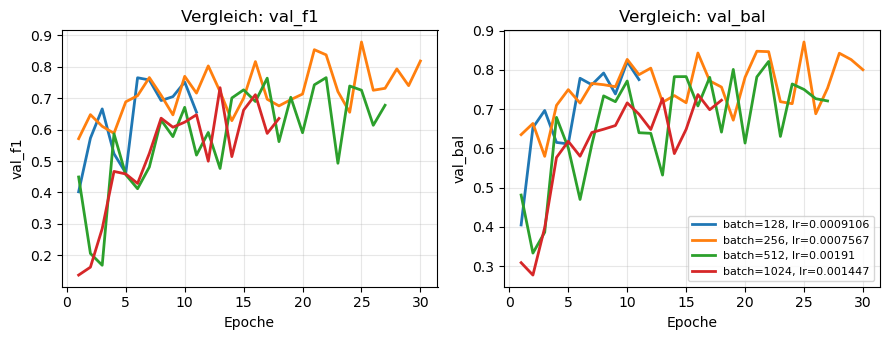


=== MODELLVERGLEICH (Train) ===
batch=1024, lr=0.001447 | train_loss max=1.3116
batch=1024, lr=0.001447 | val_loss max=1.7172
batch=128, lr=0.0009106 | train_loss max=1.0885
batch=128, lr=0.0009106 | val_loss max=1.7510
batch=256, lr=0.0007567 | train_loss max=1.1469
batch=256, lr=0.0007567 | val_loss max=1.0565
batch=512, lr=0.00191 | train_loss max=1.3205
batch=512, lr=0.00191 | val_loss max=1.7269


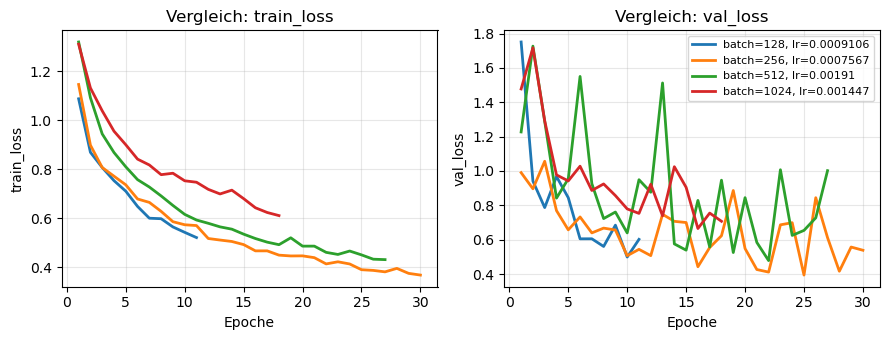


=== MODELLVERGLEICH (Test ROC) ===
batch=128, lr=0.0009106 (micro AUC=0.933)
batch=256, lr=0.0007567 (micro AUC=0.973)
batch=512, lr=0.00191 (micro AUC=0.921)
batch=1024, lr=0.001447 (micro AUC=0.912)


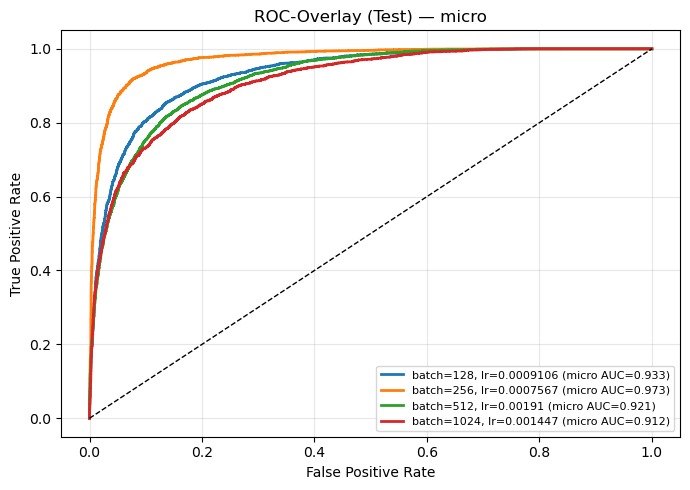


=== MODELLVERGLEICH (Test ROC) ===
batch=128, lr=0.0009106 (COVID AUC=0.914)
batch=256, lr=0.0007567 (COVID AUC=0.981)
batch=512, lr=0.00191 (COVID AUC=0.962)
batch=1024, lr=0.001447 (COVID AUC=0.865)


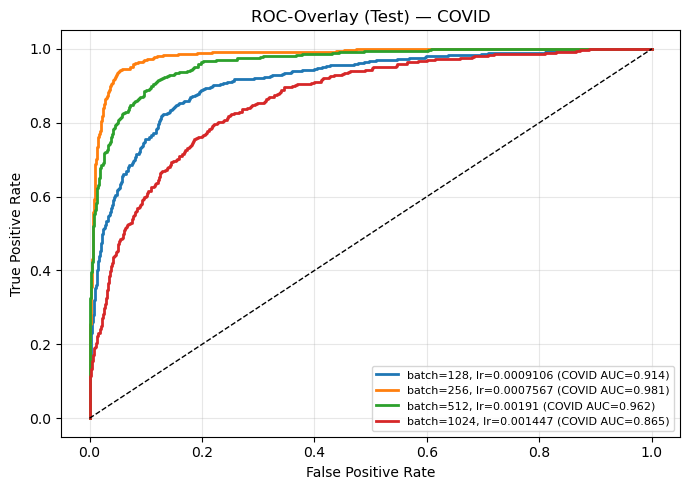


=== MODELLVERGLEICH (Test ROC) ===
batch=128, lr=0.0009106 (Lung Opacity AUC=0.898)
batch=256, lr=0.0007567 (Lung Opacity AUC=0.946)
batch=512, lr=0.00191 (Lung Opacity AUC=0.905)
batch=1024, lr=0.001447 (Lung Opacity AUC=0.879)


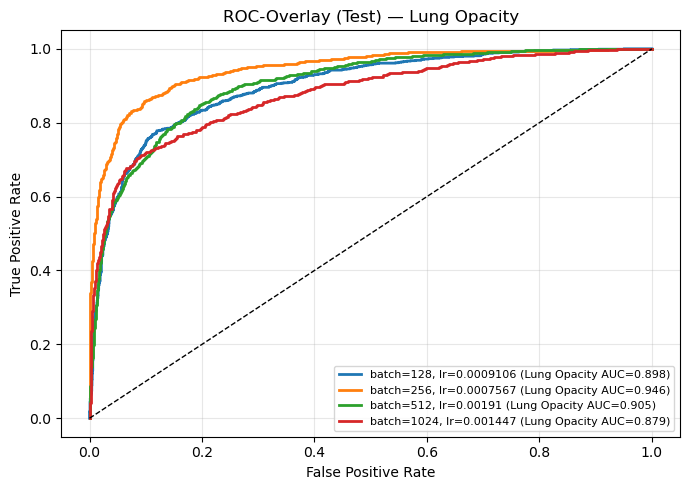


=== MODELLVERGLEICH (Test ROC) ===
batch=128, lr=0.0009106 (Viral Pneumonia AUC=0.990)
batch=256, lr=0.0007567 (Viral Pneumonia AUC=0.998)
batch=512, lr=0.00191 (Viral Pneumonia AUC=0.996)
batch=1024, lr=0.001447 (Viral Pneumonia AUC=0.992)


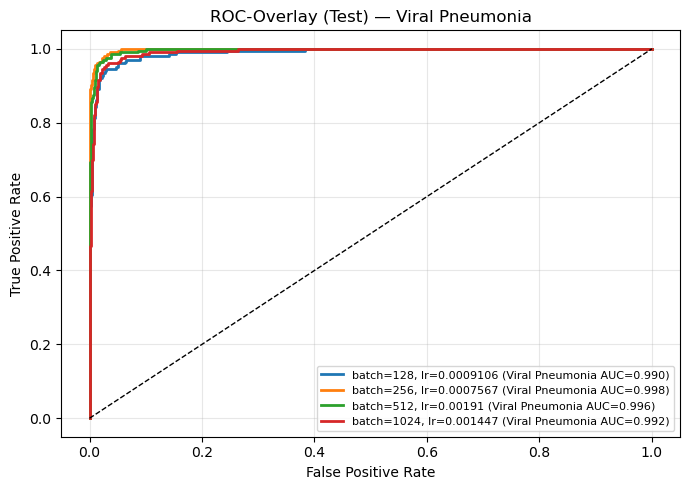

In [33]:
plot_train_overlays_multi(train_dirs, metrics=("val_f1","val_bal"))
plot_train_overlays_multi(train_dirs, metrics=("train_loss","val_loss"))

plot_test_roc_overlays(test_dirs, which="micro")
plot_test_roc_overlays(test_dirs, which="COVID")
plot_test_roc_overlays(test_dirs, which="Lung Opacity")
plot_test_roc_overlays(test_dirs, which="Viral Pneumonia")

In [ ]:
Was heißt das in deinem medizinischen Kontext?
Zielpriorität: In der klinischen Triage ist meist Sensitivität/Recall für „krank“ wichtiger als reine Präzision—eine falsch als „gesund“ eingestufte kranke Lunge ist kritisch. Darum:
Berichte per-Klasse Recall (vor allem Normal vs. Erkrankungen).
Nutze Balanced Accuracy (engl. Balanced Accuracy) wegen der stark unbalancierten Klassen im COVID-Radiography-Datensatz.
Nutze class_weight='balanced' in SVMs, damit Fehlklassifikationen der Minderheitsklassen stärker gewichtet werden.
Wenn „nie gesunde Lungen fälschlich als gesund“ wichtig ist: setze Entscheidungsschwellen/Kalibrierung (z. B. CalibratedClassifierCV) und verschiebe Thresholds so, dass Normal nur bei hoher Sicherheit vorhergesagt wird.
Kernelwahl:
RBF-SVM (SVC, kernel='rbf'): Sehr gut für nichtlineare Muster (typisch in Thorax-Röntgen), aber rechnerisch O(m²–m³) → passt für klein/mittel große Trainingssets.
Lineare SVM (LinearSVC): Skaliert linear in m und n, schnell & robust, guter Baseline-Vergleich. In Kombi mit HOG-Features überraschend stark (deine HOG-Ergebnisse zeigen das schon).
Polynom-Kernel: Möglich, aber in der Praxis für Röntgen seltener notwendig als RBF; ich lasse ihn als Option, fokussiere aber auf Linear vs. RBF.
Features:
Für SVMs empfehle ich HOG + StandardScaler (wie bei dir). Optional kannst du zusätzlich RAW-Pixel testen (flatten + StandardScaler), aber HOG ist oft stabiler bei Textur/Kanten.
Toleranz & Zeit:
Setze tol nicht zu klein—die höhere Präzision kostet bei SVC deutlich Zeit (und bringt selten klinisch Relevantes).
Code – SVM minimal, aber „kliniktauglich“
Speichert alles analog zum CNN:
Ordner: RESULTS_DIR/pt_svm_<kernel>_<mode>_<timestamp>/
Modell: MODELS_DIR/pt_svm_<kernel>_<mode>_<timestamp>.pkl
Dateien: metrics.json, confusion_matrix.png, roc_curves.png, roc_points.json, y_true.npy, y_pred.npy, y_score.npy
⚠️ Ich nutze deine vorhandenen Loader (make_loaders_cnn) und ziehe Features daraus. HOG ist Default.

Was du im Notebook (Text) noch betonen kannst (Stichworte)
Datenungleichgewicht → class_weight='balanced', Balanced Accuracy und per-Klasse Recall reporten.
Klinische Priorität → Recall der erkrankten Klassen maximieren, ggf. Schwellen anheben, um „Normal“ nur bei hoher Sicherheit zu vergeben (Kalibrierung hilft).
Featurewahl → HOG für SVM (Textur/Kanten); CNN lernt Merkmale selbst.
Linear vs. RBF → Linear schnell & baseline; RBF besser für nichtlineare Muster, aber O(m²–m³).
tol → kleinere Toleranz = längere Laufzeit; Standard reicht meist.
Skalierung (StandardScaler) ist Pflicht für SVM.
Masken → Falls Lungenmasken vorliegen, kann HOG auf maskierten Bildern Störsignale reduzieren.
Kalibrierung (LinearSVC) → saubere ROC/AUC & Schwellensteuerung (z. B. „Finger weg von Normal, wenn p<0.8“).
Wenn du möchtest, baue ich dir zusätzlich noch eine Overlay-Funktion, die die ROC-Kurven mehrerer SVMs (und CNNs) übereinander legt und die Legende automatisch aus Kernel/C/γ generiert.

In [ ]:
train_dirs_nn_mask, test_dirs_nn_mask = run_sweep_train_test(
    "mask",
    batches=[16, 32, 64, 128, 256, 512, 1024],
    fixed_lr=1e-3,
    epochs=50,
    model_kind="nn_simple"
)

plot_train_overlays_multi(
    train_dirs_nn_mask,
    metrics=("train_loss", "val_bal", "val_f1", "val_loss"),
    title_prefix="nn_simple (mask)"
)


plot_test_roc_overlays_grid(
    test_dirs_nn_mask,
    class_order=["micro", "COVID", "Lung Opacity", "Viral Pneumonia"]
)

In [30]:
# ========== NN-MLP ==========
train_dirs_nnmlp_mask, test_dirs_nnmlp_mask = run_sweep_train_test(
    "mask",
    batches=[16, 32, 64, 128, 256, 512, 1024],
    fixed_lr=1e-3,
    epochs=50,
    model_kind="nn_mlp"
)

for b in [128, 256, 512]:
    t, tt = run_sweep_train_test(
        "mask",
        lrs=[1e-4, 1e-3, "auto"],
        fixed_batch=b,
        epochs=50,
        model_kind="nn_mlp"
    )
    train_dirs_nnmlp_mask += t
    test_dirs_nnmlp_mask += tt

NameError: name 'train_dirs_cnn_mask' is not defined

In [ ]:
# ========== CNN ==========
# --- Batch Sweep (mask)
train_dirs_cnn_mask, test_dirs_cnn_mask = run_sweep_train_test(
    "mask",
    batches=[16, 32, 64, 128, 256, 512, 1024],
    fixed_lr=1e-3,
    epochs=50,
    model_kind="cnn"
)

# --- LR Sweep für feste Batches (mask)
for b in [128, 256, 512]:
    t, tt = run_sweep_train_test(
        "mask",
        lrs=[1e-4, 1e-3, "auto"],
        fixed_batch=b,
        epochs=50,
        model_kind="cnn"
    )
    train_dirs_cnn_mask += t
    test_dirs_cnn_mask += tt




In [ ]:
for b in [128, 256]:
    t, tt = run_sweep_train_test(
        "mask",
        lrs=[1e-4, "auto"],
        fixed_batch=b,
        epochs=5,
        model_kind="nn_mlp"
    )
    train_dirs_nnmlp_mask += t
    test_dirs_nnmlp_mask += tt

plot_train_overlays_grid(
    train_dirs_nnmlp_mask,  # oder z.B. train_dirs_cnn_mask
    metrics=("train_loss","val_loss","val_f1","val_bal"),
    title_prefix="cnn | mask"
)

plot_test_roc_overlays_grid(
    test_dirs_nnmlp_mask,
    class_order=["micro", "COVID", "Lung Opacity", "Viral Pneumonia"]
)

In [20]:
# ========== NN-MLP ==========

train_dirs_nnmlp_mask, test_dirs_nnmlp_mask = run_sweep_train_test(
    "mask",
    batches=[16, 64, 256],
    fixed_lr=1e-3,
    epochs=50,
    model_kind="nn_mlp"
)
for b in [128, 256, 512]:
    t, tt = run_sweep_train_test(
        "mask",
        lrs=[1e-4, 1e-3, "auto"],
        fixed_batch=b,
        epochs=50,
        model_kind="nn_mlp"
    )
    train_dirs_nnmlp_mask += t
    test_dirs_nnmlp_mask += tt


=== SWEEP RUN: model=nn_mlp | mode=mask | batch=16 | lr=0.001 ===

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=16 | LR=0.001 | Epochen=50 | Binary=False ==> Gerät: cuda


KeyboardInterrupt: 

In [ ]:
train_dirs_nnmlp_mask, test_dirs_nnmlp_mask = run_sweep_train_test(
    "mask",
    batches=[16, 64, 256],
    fixed_lr=1e-3,
    epochs=3,
    model_kind="nn_mlp"
)


=== SWEEP RUN: model=nn_mlp | mode=mask | batch=128 | lr=0.0001 ===

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=128 | LR=0.0001 | Epochen=3 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.3426 | val_loss=1.1440 | val_f1=0.398 | val_bal=0.513 | 44.14s


Epoche 02: train_loss=1.0906 | val_loss=1.0128 | val_f1=0.474 | val_bal=0.564 | 43.69s


Epoche 03: train_loss=1.0406 | val_loss=0.9882 | val_f1=0.503 | val_bal=0.561 | 43.97s
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_30_1343_batch-128_lr-00001
[TEST-START] Model=nn_mlp | Modus=mask | Batch=128
Pfad=nn_mlp_mask_2025_08_30_1343_batch-128_lr-00001.pt


[test] F1(macro)=0.500 | BalAcc=0.555 | Zeit=7.85s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_30_1343_batch-128_lr-00001_test
[SWEEP] Modell=nn_mlp_mask_2025_08_30_1343_batch-128_lr-00001 | F1=0.500 | BalAcc=0.555

=== SWEEP RUN: model=nn_mlp | mode=mask | batch=128 | lr=0.001 ===

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=128 | LR=0.001 | Epochen=3 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.4414 | val_loss=1.3898 | val_f1=0.144 | val_bal=0.264 | 44.16s


Epoche 02: train_loss=1.3697 | val_loss=1.3100 | val_f1=0.220 | val_bal=0.381 | 43.98s


Epoche 03: train_loss=1.2152 | val_loss=1.0990 | val_f1=0.346 | val_bal=0.487 | 43.63s
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_30_1345_batch-128_lr-0001
[TEST-START] Model=nn_mlp | Modus=mask | Batch=128
Pfad=nn_mlp_mask_2025_08_30_1345_batch-128_lr-0001.pt


[test] F1(macro)=0.337 | BalAcc=0.470 | Zeit=8.34s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_30_1345_batch-128_lr-0001_test
[SWEEP] Modell=nn_mlp_mask_2025_08_30_1345_batch-128_lr-0001 | F1=0.337 | BalAcc=0.470

=== SWEEP RUN: model=nn_mlp | mode=mask | batch=128 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.1977 @idx=143 → vorgeschlagene LR=1.498e-03
[lr-finder] gewählte Start-LR: 1.498e-03

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=128 | LR=0.0014976207715180195 | Epochen=3 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.4337 | val_loss=1.4101 | val_f1=0.197 | val_bal=0.311 | 47.15s


Epoche 02: train_loss=1.3728 | val_loss=1.3612 | val_f1=0.075 | val_bal=0.272 | 46.69s


Epoche 03: train_loss=1.2583 | val_loss=1.1233 | val_f1=0.373 | val_bal=0.520 | 45.72s
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_30_1348_batch-128_lr-00014976207715180195
[TEST-START] Model=nn_mlp | Modus=mask | Batch=128
Pfad=nn_mlp_mask_2025_08_30_1348_batch-128_lr-00014976207715180195.pt


[test] F1(macro)=0.367 | BalAcc=0.506 | Zeit=8.23s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_30_1348_batch-128_lr-00014976207715180195_test
[SWEEP] Modell=nn_mlp_mask_2025_08_30_1348_batch-128_lr-00014976207715180195 | F1=0.367 | BalAcc=0.506

=== MODELLVERGLEICH (Train) ===
nn | batch=128 | lr=0.0001 | mlp | train_loss max=1.4414
nn | batch=128 | lr=0.0001 | mlp | val_bal max=0.4867
nn | batch=128 | lr=0.0001 | mlp | val_f1 max=0.3460
nn | batch=128 | lr=0.0001 | mlp | val_loss max=1.3898
nn | batch=128 | lr=0.0001498 | mlp | train_loss max=1.4337
nn | batch=128 | lr=0.0001498 | mlp | val_bal max=0.5203
nn | batch=128 | lr=0.0001498 | mlp | val_f1 max=0.3730
nn | batch=128 | lr=0.0001498 | mlp | val_loss max=1.4101
nn | batch=128 | lr=1e-05 | mlp | train_loss max=1.3426
nn | batch=128 | lr=1e-05 | mlp | val_bal max=0.5641
nn | batch=128 | lr=1e-05 | mlp | val_f1 max=0.5028
nn | batch=128 | lr=1e-05 | mlp | val_loss max=1.1440
nn | batch=16 | lr=0.0001 | mlp | train_loss max=1.32

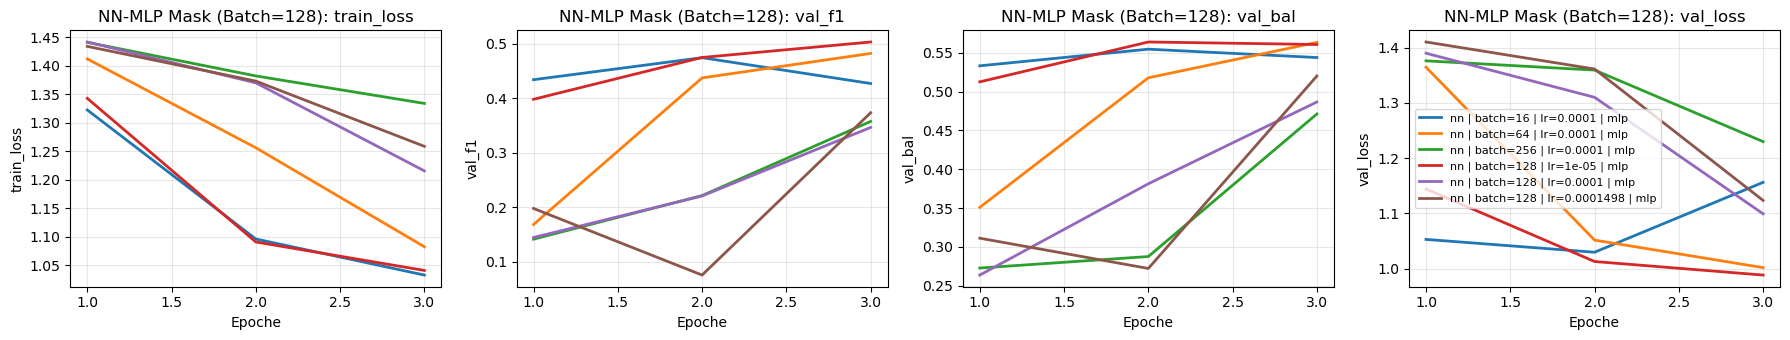


=== MODELLVERGLEICH (ROC micro) ===
nn | batch=16 | lr=0.0001 | mlp (AUC=0.767)
nn | batch=64 | lr=0.0001 | mlp (AUC=0.791)
nn | batch=256 | lr=0.0001 | mlp (AUC=0.705)
nn | batch=128 | lr=1e-05 | mlp (AUC=0.821)
nn | batch=128 | lr=0.0001 | mlp (AUC=0.659)
nn | batch=128 | lr=0.0001498 | mlp (AUC=0.711)

=== MODELLVERGLEICH (ROC COVID) ===
nn | batch=16 | lr=0.0001 | mlp (AUC=0.638)
nn | batch=64 | lr=0.0001 | mlp (AUC=0.618)
nn | batch=256 | lr=0.0001 | mlp (AUC=0.576)
nn | batch=128 | lr=1e-05 | mlp (AUC=0.656)
nn | batch=128 | lr=0.0001 | mlp (AUC=0.571)
nn | batch=128 | lr=0.0001498 | mlp (AUC=0.536)

=== MODELLVERGLEICH (ROC Lung Opacity) ===
nn | batch=16 | lr=0.0001 | mlp (AUC=0.758)
nn | batch=64 | lr=0.0001 | mlp (AUC=0.763)
nn | batch=256 | lr=0.0001 | mlp (AUC=0.690)
nn | batch=128 | lr=1e-05 | mlp (AUC=0.770)
nn | batch=128 | lr=0.0001 | mlp (AUC=0.742)
nn | batch=128 | lr=0.0001498 | mlp (AUC=0.719)

=== MODELLVERGLEICH (ROC Viral Pneumonia) ===
nn | batch=16 | lr=0.0001

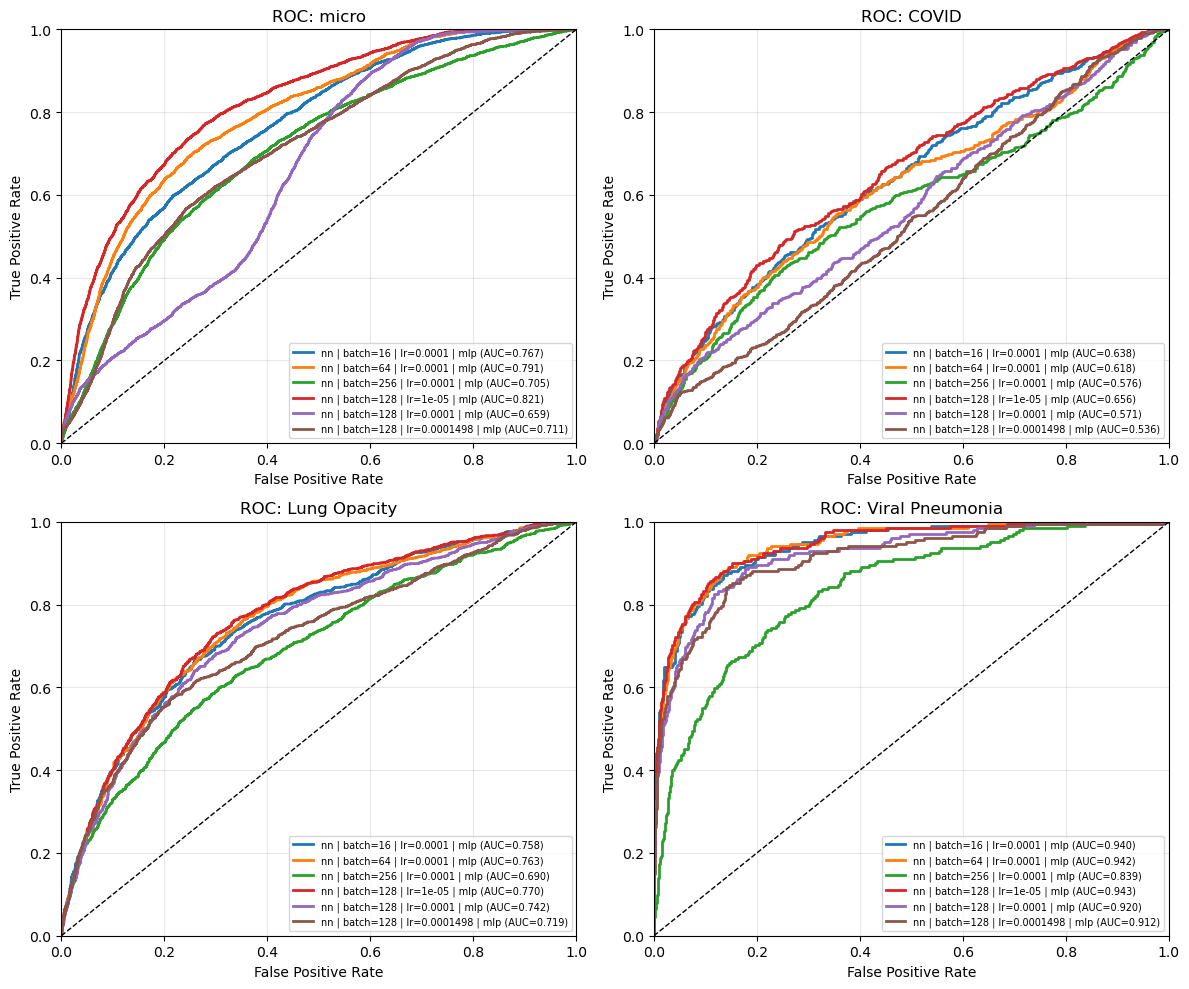


=== SWEEP RUN: model=nn_mlp | mode=mask | batch=256 | lr=0.0001 ===

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=256 | LR=0.0001 | Epochen=3 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.3966 | val_loss=1.3148 | val_f1=0.364 | val_bal=0.378 | 44.67s


Epoche 02: train_loss=1.2222 | val_loss=1.0740 | val_f1=0.434 | val_bal=0.545 | 44.88s


Epoche 03: train_loss=1.0665 | val_loss=1.0485 | val_f1=0.394 | val_bal=0.533 | 44.79s
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_30_1351_batch-256_lr-00001
[TEST-START] Model=nn_mlp | Modus=mask | Batch=256
Pfad=nn_mlp_mask_2025_08_30_1351_batch-256_lr-00001.pt


[test] F1(macro)=0.426 | BalAcc=0.534 | Zeit=7.98s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_30_1351_batch-256_lr-00001_test
[SWEEP] Modell=nn_mlp_mask_2025_08_30_1351_batch-256_lr-00001 | F1=0.426 | BalAcc=0.534

=== SWEEP RUN: model=nn_mlp | mode=mask | batch=256 | lr=0.001 ===

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=256 | LR=0.001 | Epochen=3 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.4499 | val_loss=1.3768 | val_f1=0.253 | val_bal=0.331 | 43.50s


Epoche 02: train_loss=1.3740 | val_loss=1.3524 | val_f1=0.336 | val_bal=0.353 | 44.00s


Epoche 03: train_loss=1.3161 | val_loss=1.2237 | val_f1=0.264 | val_bal=0.408 | 43.56s
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_30_1354_batch-256_lr-0001
[TEST-START] Model=nn_mlp | Modus=mask | Batch=256
Pfad=nn_mlp_mask_2025_08_30_1354_batch-256_lr-0001.pt


[test] F1(macro)=0.316 | BalAcc=0.336 | Zeit=8.31s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_30_1354_batch-256_lr-0001_test
[SWEEP] Modell=nn_mlp_mask_2025_08_30_1354_batch-256_lr-0001 | F1=0.316 | BalAcc=0.336

=== SWEEP RUN: model=nn_mlp | mode=mask | batch=256 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.1582 @idx=149 → vorgeschlagene LR=1.977e-03
[lr-finder] gewählte Start-LR: 1.977e-03

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=256 | LR=0.0019769918093251373 | Epochen=3 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.5188 | val_loss=1.3883 | val_f1=0.078 | val_bal=0.269 | 46.58s


Epoche 02: train_loss=1.3927 | val_loss=1.3771 | val_f1=0.057 | val_bal=0.259 | 43.95s


Epoche 03: train_loss=1.3761 | val_loss=1.3398 | val_f1=0.187 | val_bal=0.359 | 43.65s
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_30_1356_batch-256_lr-00019769918093251373
[TEST-START] Model=nn_mlp | Modus=mask | Batch=256
Pfad=nn_mlp_mask_2025_08_30_1356_batch-256_lr-00019769918093251373.pt


[test] F1(macro)=0.185 | BalAcc=0.361 | Zeit=7.95s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_30_1356_batch-256_lr-00019769918093251373_test
[SWEEP] Modell=nn_mlp_mask_2025_08_30_1356_batch-256_lr-00019769918093251373 | F1=0.185 | BalAcc=0.361

=== MODELLVERGLEICH (Train) ===
nn | batch=128 | lr=0.0001 | mlp | train_loss max=1.4414
nn | batch=128 | lr=0.0001 | mlp | val_bal max=0.4867
nn | batch=128 | lr=0.0001 | mlp | val_f1 max=0.3460
nn | batch=128 | lr=0.0001 | mlp | val_loss max=1.3898
nn | batch=128 | lr=0.0001498 | mlp | train_loss max=1.4337
nn | batch=128 | lr=0.0001498 | mlp | val_bal max=0.5203
nn | batch=128 | lr=0.0001498 | mlp | val_f1 max=0.3730
nn | batch=128 | lr=0.0001498 | mlp | val_loss max=1.4101
nn | batch=128 | lr=1e-05 | mlp | train_loss max=1.3426
nn | batch=128 | lr=1e-05 | mlp | val_bal max=0.5641
nn | batch=128 | lr=1e-05 | mlp | val_f1 max=0.5028
nn | batch=128 | lr=1e-05 | mlp | val_loss max=1.1440
nn | batch=16 | lr=0.0001 | mlp | train_loss max=1.32

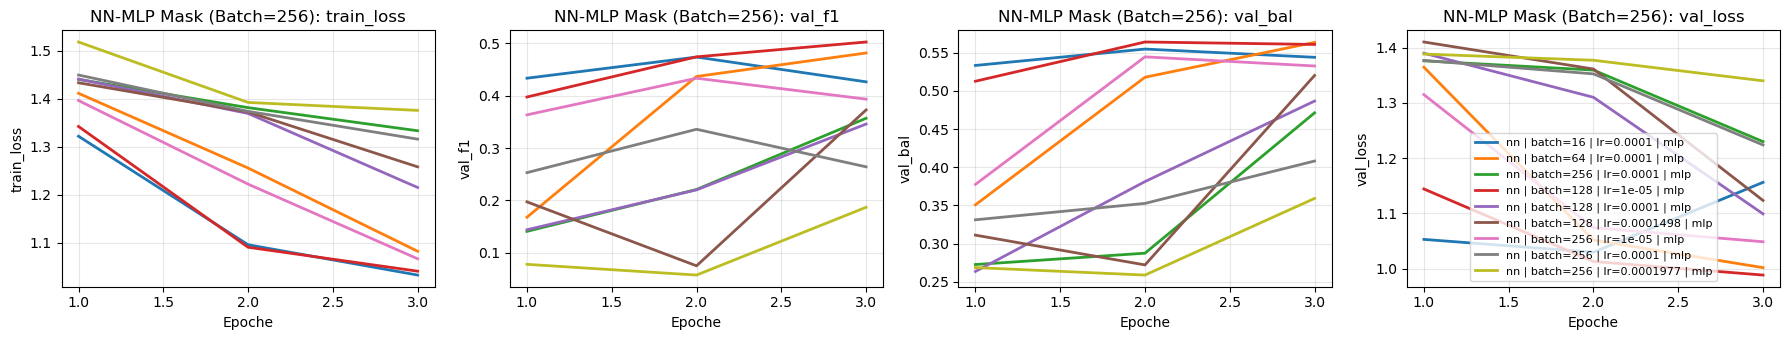


=== MODELLVERGLEICH (ROC micro) ===
nn | batch=16 | lr=0.0001 | mlp (AUC=0.767)
nn | batch=64 | lr=0.0001 | mlp (AUC=0.791)
nn | batch=256 | lr=0.0001 | mlp (AUC=0.705)
nn | batch=128 | lr=1e-05 | mlp (AUC=0.821)
nn | batch=128 | lr=0.0001 | mlp (AUC=0.659)
nn | batch=128 | lr=0.0001498 | mlp (AUC=0.711)
nn | batch=256 | lr=1e-05 | mlp (AUC=0.707)
nn | batch=256 | lr=0.0001 | mlp (AUC=0.764)
nn | batch=256 | lr=0.0001977 | mlp (AUC=0.659)

=== MODELLVERGLEICH (ROC COVID) ===
nn | batch=16 | lr=0.0001 | mlp (AUC=0.638)
nn | batch=64 | lr=0.0001 | mlp (AUC=0.618)
nn | batch=256 | lr=0.0001 | mlp (AUC=0.576)
nn | batch=128 | lr=1e-05 | mlp (AUC=0.656)
nn | batch=128 | lr=0.0001 | mlp (AUC=0.571)
nn | batch=128 | lr=0.0001498 | mlp (AUC=0.536)
nn | batch=256 | lr=1e-05 | mlp (AUC=0.583)
nn | batch=256 | lr=0.0001 | mlp (AUC=0.542)
nn | batch=256 | lr=0.0001977 | mlp (AUC=0.538)

=== MODELLVERGLEICH (ROC Lung Opacity) ===
nn | batch=16 | lr=0.0001 | mlp (AUC=0.758)
nn | batch=64 | lr=0.000

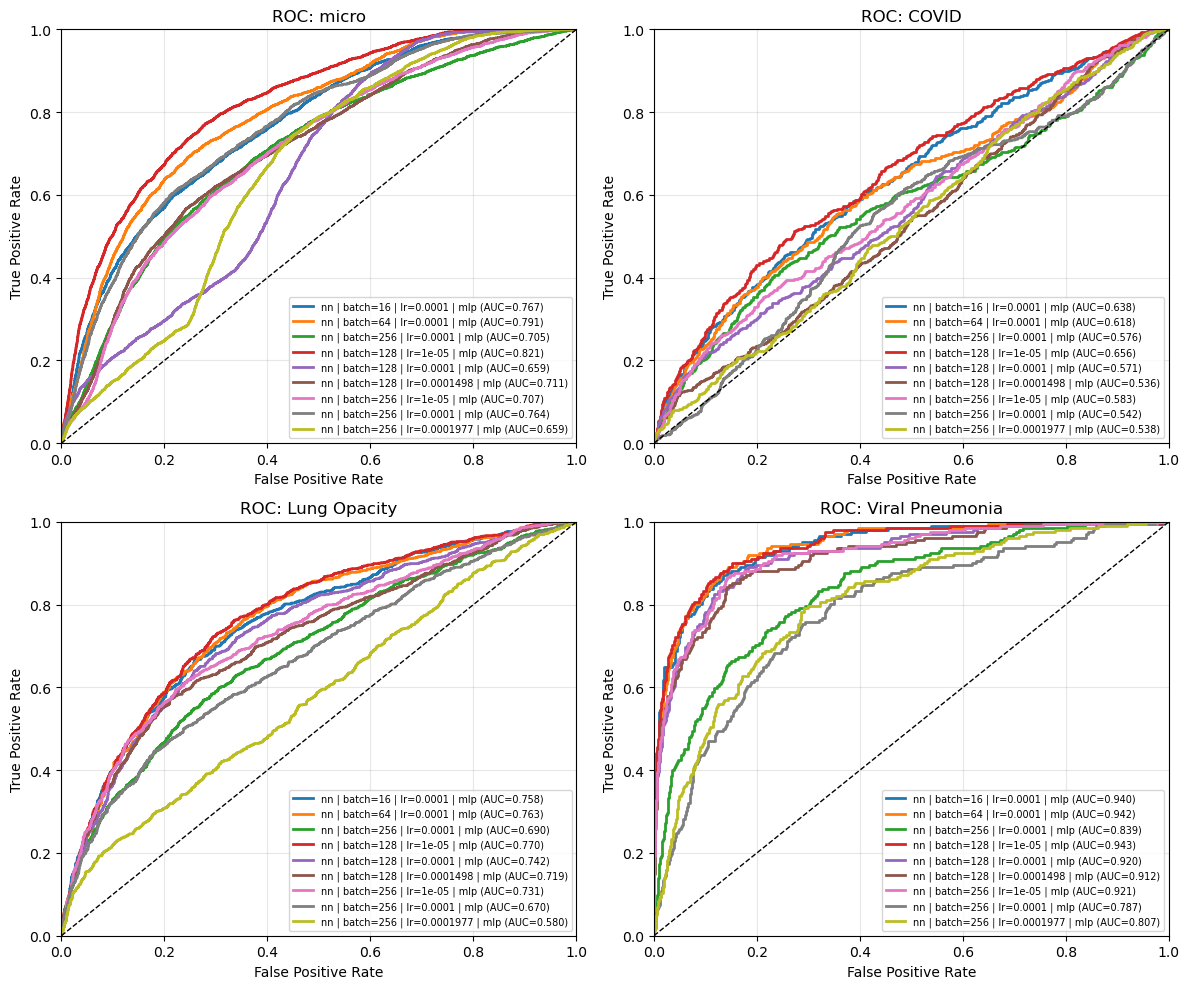


=== SWEEP RUN: model=nn_mlp | mode=mask | batch=512 | lr=0.0001 ===

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=512 | LR=0.0001 | Epochen=3 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.5055 | val_loss=1.3641 | val_f1=0.250 | val_bal=0.300 | 46.48s


Epoche 02: train_loss=1.3699 | val_loss=1.3470 | val_f1=0.233 | val_bal=0.332 | 46.23s


Epoche 03: train_loss=1.3362 | val_loss=1.2848 | val_f1=0.278 | val_bal=0.442 | 45.37s
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_30_1401_batch-512_lr-00001
[TEST-START] Model=nn_mlp | Modus=mask | Batch=512
Pfad=nn_mlp_mask_2025_08_30_1401_batch-512_lr-00001.pt


[test] F1(macro)=0.267 | BalAcc=0.429 | Zeit=8.07s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_30_1401_batch-512_lr-00001_test
[SWEEP] Modell=nn_mlp_mask_2025_08_30_1401_batch-512_lr-00001 | F1=0.267 | BalAcc=0.429

=== SWEEP RUN: model=nn_mlp | mode=mask | batch=512 | lr=0.001 ===

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=512 | LR=0.001 | Epochen=3 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.5493 | val_loss=1.3945 | val_f1=0.163 | val_bal=0.250 | 46.19s


Epoche 02: train_loss=1.3961 | val_loss=1.3805 | val_f1=0.163 | val_bal=0.250 | 46.70s


Epoche 03: train_loss=1.3872 | val_loss=1.3757 | val_f1=0.166 | val_bal=0.287 | 46.20s
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_30_1403_batch-512_lr-0001
[TEST-START] Model=nn_mlp | Modus=mask | Batch=512
Pfad=nn_mlp_mask_2025_08_30_1403_batch-512_lr-0001.pt


[test] F1(macro)=0.166 | BalAcc=0.287 | Zeit=8.29s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_30_1403_batch-512_lr-0001_test
[SWEEP] Modell=nn_mlp_mask_2025_08_30_1403_batch-512_lr-0001 | F1=0.166 | BalAcc=0.287

=== SWEEP RUN: model=nn_mlp | mode=mask | batch=512 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.1234 @idx=108 → vorgeschlagene LR=2.964e-04
[lr-finder] gewählte Start-LR: 2.964e-04

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=512 | LR=0.0002964041411597741 | Epochen=3 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.4633 | val_loss=1.3863 | val_f1=0.040 | val_bal=0.254 | 49.92s


Epoche 02: train_loss=1.3706 | val_loss=1.3403 | val_f1=0.320 | val_bal=0.416 | 45.18s


KeyboardInterrupt: 

In [23]:

# --- zweiter Teil: LR-Sweeps ---
for b in [128, 256, 512]:
    t, tt = run_sweep_train_test(
        "mask",
        lrs=[1e-4, 1e-3, "auto"],
        fixed_batch=b,
        epochs=3,
        model_kind="nn_mlp"
    )
    train_dirs_nnmlp_mask += t
    test_dirs_nnmlp_mask  += tt

    # Sofortige Analyse der LR-Sweeps:
    plot_train_overlays_multi(
        train_dirs_nnmlp_mask,
        metrics=("train_loss","val_f1","val_bal","val_loss"),
        title_prefix=f"NN-MLP Mask (Batch={b})"
    )

    plot_test_roc_overlays_grid(
        test_dirs_nnmlp_mask,
        class_order=["micro","COVID","Lung Opacity","Viral Pneumonia"]
    )


In [ ]:
# ========== CNN (MASK) ==========

# --- Batch-Sweep (mask)
train_dirs_cnn_mask_batch, test_dirs_cnn_mask_batch = run_sweep_train_test(
    "mask",
    batches=[16, 64, 256],
    fixed_lr=1e-3,
    epochs=3,
    model_kind="cnn"
)

# Optional: sofortige Übersicht nach dem Batch-Sweep
plot_train_overlays_grid(
    train_dirs_cnn_mask_batch,
    metrics=("train_loss", "val_f1", "val_bal", "val_loss"),
    title_prefix="CNN Mask — Batch Sweep"
)
plot_test_roc_overlays_grid(
    test_dirs_cnn_mask_batch,
    class_order=["micro","COVID","Lung Opacity","Viral Pneumonia"]
)


In [32]:
# Sammeln
train_dirs_cnn_nomask = []
test_dirs_cnn_nomask  = []
for b in [128, 256, 512]:
    t, tt = run_sweep_train_test(
        "nomask",
        lrs=[1e-4, 1e-3, "auto"],
        fixed_batch=b,
        epochs=50,
        model_kind="cnn"
    )
    train_dirs_cnn_mask += t
    test_dirs_cnn_mask  += tt

# Gruppieren & plotten (pro Batch ein Plot)
train_groups = _group_runs_by_batch(train_dirs_cnn_nomask)
test_groups  = _group_runs_by_batch(test_dirs_cnn_nomask)

for b, t in train_groups.items():
    plot_train_overlays_grid(
        t,
        metrics=("train_loss", "val_f1", "val_bal", "val_loss"),
        title_prefix=f"CNN Nomask — LR Sweep @ batch={b}"
    )

for b, tt in test_groups.items():
    plot_test_roc_overlays_grid(
        tt,
        class_order=["micro","COVID","Lung Opacity","Viral Pneumonia"]
    )



=== SWEEP RUN: model=cnn | mode=nomask | batch=128 | lr=0.0001 ===

[TRAIN-START] Model=cnn | Modus=nomask | Batch=128 | LR=0.0001 | Epochen=50 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.2310 | val_loss=1.1352 | val_f1=0.476 | val_bal=0.586 | 28.51s


Epoche 02: train_loss=1.0850 | val_loss=1.0360 | val_f1=0.556 | val_bal=0.638 | 27.86s


Epoche 03: train_loss=1.0084 | val_loss=0.9773 | val_f1=0.620 | val_bal=0.654 | 27.99s


Epoche 04: train_loss=0.9542 | val_loss=0.9241 | val_f1=0.589 | val_bal=0.662 | 27.67s


Epoche 05: train_loss=0.9187 | val_loss=0.8951 | val_f1=0.588 | val_bal=0.675 | 27.64s


Epoche 06: train_loss=0.8881 | val_loss=0.8681 | val_f1=0.609 | val_bal=0.686 | 27.23s


Epoche 07: train_loss=0.8599 | val_loss=0.8538 | val_f1=0.658 | val_bal=0.705 | 27.69s


Epoche 08: train_loss=0.8428 | val_loss=0.8685 | val_f1=0.563 | val_bal=0.672 | 27.71s


Epoche 09: train_loss=0.8163 | val_loss=0.7902 | val_f1=0.639 | val_bal=0.715 | 27.54s


Epoche 10: train_loss=0.8015 | val_loss=0.8068 | val_f1=0.649 | val_bal=0.694 | 27.68s


Epoche 11: train_loss=0.7880 | val_loss=0.7636 | val_f1=0.643 | val_bal=0.723 | 27.62s


Epoche 12: train_loss=0.7718 | val_loss=0.7391 | val_f1=0.658 | val_bal=0.731 | 27.91s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_30_1704_batch-128_lr-00001
[TEST-START] Model=cnn | Modus=nomask | Batch=128
Pfad=cnn_nomask_2025_08_30_1704_batch-128_lr-00001.pt


[test] F1(macro)=0.653 | BalAcc=0.700 | Zeit=5.10s | /home/lupan001/ML/results/cnn_nomask_2025_08_30_1704_batch-128_lr-00001_test
[SWEEP] Modell=cnn_nomask_2025_08_30_1704_batch-128_lr-00001 | F1=0.653 | BalAcc=0.700

=== SWEEP RUN: model=cnn | mode=nomask | batch=128 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=nomask | Batch=128 | LR=0.001 | Epochen=50 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.0339 | val_loss=1.0771 | val_f1=0.415 | val_bal=0.536 | 28.43s


Epoche 02: train_loss=0.8464 | val_loss=0.9168 | val_f1=0.534 | val_bal=0.635 | 27.77s


Epoche 03: train_loss=0.7818 | val_loss=0.7418 | val_f1=0.609 | val_bal=0.712 | 27.27s


Epoche 04: train_loss=0.7260 | val_loss=0.9472 | val_f1=0.672 | val_bal=0.635 | 28.11s


Epoche 05: train_loss=0.6924 | val_loss=0.7955 | val_f1=0.706 | val_bal=0.680 | 28.20s


Epoche 06: train_loss=0.6804 | val_loss=1.0270 | val_f1=0.461 | val_bal=0.570 | 28.46s


Epoche 07: train_loss=0.6552 | val_loss=0.7129 | val_f1=0.637 | val_bal=0.731 | 28.24s


Epoche 08: train_loss=0.6215 | val_loss=0.7986 | val_f1=0.709 | val_bal=0.688 | 28.47s


Epoche 09: train_loss=0.6011 | val_loss=0.6201 | val_f1=0.683 | val_bal=0.769 | 28.50s


Epoche 10: train_loss=0.5976 | val_loss=0.5310 | val_f1=0.744 | val_bal=0.797 | 28.30s


Epoche 11: train_loss=0.5638 | val_loss=0.6038 | val_f1=0.739 | val_bal=0.757 | 28.52s


Epoche 12: train_loss=0.5440 | val_loss=0.8882 | val_f1=0.689 | val_bal=0.652 | 28.49s


Epoche 13: train_loss=0.5387 | val_loss=1.3825 | val_f1=0.367 | val_bal=0.544 | 28.80s


Epoche 14: train_loss=0.5173 | val_loss=0.4297 | val_f1=0.821 | val_bal=0.857 | 28.05s


Epoche 15: train_loss=0.5232 | val_loss=0.6129 | val_f1=0.658 | val_bal=0.776 | 28.24s


Epoche 16: train_loss=0.5039 | val_loss=1.1166 | val_f1=0.502 | val_bal=0.607 | 28.51s


Epoche 17: train_loss=0.4747 | val_loss=0.4680 | val_f1=0.813 | val_bal=0.832 | 28.27s


Epoche 18: train_loss=0.4699 | val_loss=0.4749 | val_f1=0.718 | val_bal=0.824 | 28.37s


Epoche 19: train_loss=0.4669 | val_loss=0.8354 | val_f1=0.735 | val_bal=0.692 | 28.28s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_30_1710_batch-128_lr-0001
[TEST-START] Model=cnn | Modus=nomask | Batch=128
Pfad=cnn_nomask_2025_08_30_1710_batch-128_lr-0001.pt


[test] F1(macro)=0.806 | BalAcc=0.845 | Zeit=5.26s | /home/lupan001/ML/results/cnn_nomask_2025_08_30_1710_batch-128_lr-0001_test
[SWEEP] Modell=cnn_nomask_2025_08_30_1710_batch-128_lr-0001 | F1=0.806 | BalAcc=0.845

=== SWEEP RUN: model=cnn | mode=nomask | batch=128 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.0837 @idx=184 → vorgeschlagene LR=9.989e-03
[lr-finder] gewählte Start-LR: 9.989e-03

[TRAIN-START] Model=cnn | Modus=nomask | Batch=128 | LR=0.009989010231710404 | Epochen=50 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.0638 | val_loss=1.4530 | val_f1=0.225 | val_bal=0.407 | 29.32s


Epoche 02: train_loss=0.8604 | val_loss=1.0138 | val_f1=0.382 | val_bal=0.564 | 28.63s


Epoche 03: train_loss=0.7891 | val_loss=0.8448 | val_f1=0.680 | val_bal=0.691 | 28.44s


Epoche 04: train_loss=0.7289 | val_loss=0.7721 | val_f1=0.648 | val_bal=0.696 | 28.38s


Epoche 05: train_loss=0.6863 | val_loss=1.1747 | val_f1=0.438 | val_bal=0.609 | 28.48s


Epoche 06: train_loss=0.6630 | val_loss=0.6946 | val_f1=0.653 | val_bal=0.719 | 28.34s


Epoche 07: train_loss=0.6330 | val_loss=0.6036 | val_f1=0.695 | val_bal=0.787 | 28.16s


Epoche 08: train_loss=0.6079 | val_loss=0.7377 | val_f1=0.566 | val_bal=0.713 | 28.09s


Epoche 09: train_loss=0.5716 | val_loss=0.8089 | val_f1=0.722 | val_bal=0.694 | 27.84s


Epoche 10: train_loss=0.5580 | val_loss=0.5109 | val_f1=0.766 | val_bal=0.801 | 28.46s


Epoche 11: train_loss=0.5332 | val_loss=0.8200 | val_f1=0.655 | val_bal=0.722 | 28.20s


Epoche 12: train_loss=0.5346 | val_loss=0.5125 | val_f1=0.777 | val_bal=0.805 | 28.29s


Epoche 13: train_loss=0.4966 | val_loss=0.5774 | val_f1=0.758 | val_bal=0.782 | 28.62s


Epoche 14: train_loss=0.5041 | val_loss=0.7138 | val_f1=0.738 | val_bal=0.730 | 27.80s


Epoche 15: train_loss=0.4796 | val_loss=0.7099 | val_f1=0.655 | val_bal=0.719 | 28.09s


Epoche 16: train_loss=0.4673 | val_loss=0.4945 | val_f1=0.719 | val_bal=0.817 | 28.39s


Epoche 17: train_loss=0.4521 | val_loss=0.5510 | val_f1=0.790 | val_bal=0.785 | 28.19s


Epoche 18: train_loss=0.4310 | val_loss=0.6067 | val_f1=0.667 | val_bal=0.754 | 28.19s


Epoche 19: train_loss=0.4472 | val_loss=0.4266 | val_f1=0.834 | val_bal=0.843 | 28.68s


Epoche 20: train_loss=0.4194 | val_loss=0.6142 | val_f1=0.727 | val_bal=0.777 | 28.63s


Epoche 21: train_loss=0.4160 | val_loss=0.6251 | val_f1=0.745 | val_bal=0.797 | 28.30s


Epoche 22: train_loss=0.4082 | val_loss=0.4669 | val_f1=0.796 | val_bal=0.823 | 28.56s


Epoche 23: train_loss=0.3899 | val_loss=0.4022 | val_f1=0.859 | val_bal=0.851 | 28.26s


Epoche 24: train_loss=0.3853 | val_loss=0.4068 | val_f1=0.842 | val_bal=0.855 | 28.39s


Epoche 25: train_loss=0.3848 | val_loss=0.5804 | val_f1=0.799 | val_bal=0.795 | 28.45s


Epoche 26: train_loss=0.3725 | val_loss=0.3338 | val_f1=0.881 | val_bal=0.876 | 28.62s


Epoche 27: train_loss=0.3621 | val_loss=0.4205 | val_f1=0.877 | val_bal=0.853 | 28.28s


Epoche 28: train_loss=0.3567 | val_loss=0.4026 | val_f1=0.853 | val_bal=0.853 | 28.25s


Epoche 29: train_loss=0.3589 | val_loss=0.3141 | val_f1=0.855 | val_bal=0.886 | 28.02s


Epoche 30: train_loss=0.3470 | val_loss=1.1576 | val_f1=0.638 | val_bal=0.710 | 28.33s


Epoche 31: train_loss=0.3426 | val_loss=0.3934 | val_f1=0.787 | val_bal=0.849 | 28.58s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_30_1719_batch-128_lr-0009989010231710404
[TEST-START] Model=cnn | Modus=nomask | Batch=128
Pfad=cnn_nomask_2025_08_30_1719_batch-128_lr-0009989010231710404.pt


[test] F1(macro)=0.868 | BalAcc=0.867 | Zeit=5.21s | /home/lupan001/ML/results/cnn_nomask_2025_08_30_1719_batch-128_lr-0009989010231710404_test
[SWEEP] Modell=cnn_nomask_2025_08_30_1719_batch-128_lr-0009989010231710404 | F1=0.868 | BalAcc=0.867

=== SWEEP RUN: model=cnn | mode=nomask | batch=256 | lr=0.0001 ===

[TRAIN-START] Model=cnn | Modus=nomask | Batch=256 | LR=0.0001 | Epochen=50 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.2769 | val_loss=1.2273 | val_f1=0.368 | val_bal=0.506 | 28.94s


Epoche 02: train_loss=1.1598 | val_loss=1.1232 | val_f1=0.489 | val_bal=0.591 | 28.24s


Epoche 03: train_loss=1.0891 | val_loss=1.0581 | val_f1=0.532 | val_bal=0.620 | 27.97s


Epoche 04: train_loss=1.0372 | val_loss=1.0276 | val_f1=0.512 | val_bal=0.626 | 28.20s


Epoche 05: train_loss=0.9944 | val_loss=0.9867 | val_f1=0.554 | val_bal=0.637 | 28.65s


Epoche 06: train_loss=0.9591 | val_loss=0.9923 | val_f1=0.598 | val_bal=0.618 | 28.42s


Epoche 07: train_loss=0.9326 | val_loss=0.9198 | val_f1=0.592 | val_bal=0.671 | 28.23s


Epoche 08: train_loss=0.9080 | val_loss=0.9028 | val_f1=0.572 | val_bal=0.665 | 28.80s


Epoche 09: train_loss=0.8927 | val_loss=0.9007 | val_f1=0.603 | val_bal=0.674 | 28.73s


Epoche 10: train_loss=0.8699 | val_loss=0.9045 | val_f1=0.545 | val_bal=0.656 | 28.53s


Epoche 11: train_loss=0.8609 | val_loss=0.8704 | val_f1=0.614 | val_bal=0.680 | 28.43s


Epoche 12: train_loss=0.8462 | val_loss=0.8253 | val_f1=0.627 | val_bal=0.709 | 28.45s


Epoche 13: train_loss=0.8346 | val_loss=0.8232 | val_f1=0.658 | val_bal=0.709 | 28.34s


Epoche 14: train_loss=0.8206 | val_loss=0.8946 | val_f1=0.525 | val_bal=0.637 | 28.82s


Epoche 15: train_loss=0.8143 | val_loss=0.7892 | val_f1=0.658 | val_bal=0.725 | 28.43s


Epoche 17: train_loss=0.7951 | val_loss=0.7833 | val_f1=0.627 | val_bal=0.700 | 28.40s


Epoche 18: train_loss=0.7826 | val_loss=0.7814 | val_f1=0.692 | val_bal=0.723 | 28.43s


Epoche 19: train_loss=0.7720 | val_loss=0.7585 | val_f1=0.662 | val_bal=0.723 | 29.02s


Epoche 20: train_loss=0.7665 | val_loss=0.7710 | val_f1=0.629 | val_bal=0.703 | 28.83s


Epoche 21: train_loss=0.7586 | val_loss=0.7263 | val_f1=0.679 | val_bal=0.746 | 28.07s


Epoche 22: train_loss=0.7554 | val_loss=0.7720 | val_f1=0.635 | val_bal=0.700 | 28.37s


Epoche 23: train_loss=0.7493 | val_loss=0.7340 | val_f1=0.667 | val_bal=0.745 | 28.60s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_30_1735_batch-256_lr-00001
[TEST-START] Model=cnn | Modus=nomask | Batch=256
Pfad=cnn_nomask_2025_08_30_1735_batch-256_lr-00001.pt


[test] F1(macro)=0.688 | BalAcc=0.718 | Zeit=5.22s | /home/lupan001/ML/results/cnn_nomask_2025_08_30_1735_batch-256_lr-00001_test
[SWEEP] Modell=cnn_nomask_2025_08_30_1735_batch-256_lr-00001 | F1=0.688 | BalAcc=0.718

=== SWEEP RUN: model=cnn | mode=nomask | batch=256 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=nomask | Batch=256 | LR=0.001 | Epochen=50 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.1322 | val_loss=1.1287 | val_f1=0.568 | val_bal=0.568 | 28.79s


Epoche 02: train_loss=0.9343 | val_loss=0.8954 | val_f1=0.553 | val_bal=0.644 | 28.24s


Epoche 03: train_loss=0.8387 | val_loss=0.8218 | val_f1=0.612 | val_bal=0.706 | 28.32s


Epoche 04: train_loss=0.7717 | val_loss=0.8218 | val_f1=0.543 | val_bal=0.682 | 28.10s


Epoche 05: train_loss=0.7669 | val_loss=0.8325 | val_f1=0.561 | val_bal=0.650 | 27.79s


Epoche 06: train_loss=0.7184 | val_loss=0.7057 | val_f1=0.712 | val_bal=0.741 | 28.22s


Epoche 07: train_loss=0.6998 | val_loss=0.9432 | val_f1=0.521 | val_bal=0.626 | 28.16s


Epoche 08: train_loss=0.6760 | val_loss=0.7661 | val_f1=0.659 | val_bal=0.706 | 28.22s


Epoche 09: train_loss=0.6355 | val_loss=1.2224 | val_f1=0.506 | val_bal=0.527 | 28.19s


Epoche 10: train_loss=0.6214 | val_loss=1.2087 | val_f1=0.540 | val_bal=0.580 | 28.65s


KeyboardInterrupt: 

In [33]:
# ========== CNN (MASK) ==========

# --- Batch-Sweep (mask)
train_dirs_cnn_nomask_batch, test_dirs_cnn_nomask_batch = run_sweep_train_test(
    "nomask",
    batches=[16, 64, 256],
    fixed_lr=1e-3,
    epochs=3,
    model_kind="cnn"
)


=== SWEEP RUN: model=cnn | mode=mask | batch=16 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=mask | Batch=16 | LR=0.001 | Epochen=3 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.1467 | val_loss=1.0762 | val_f1=0.515 | val_bal=0.491 | 45.21s


Epoche 02: train_loss=0.9242 | val_loss=3.9992 | val_f1=0.135 | val_bal=0.341 | 44.35s


Epoche 03: train_loss=0.8481 | val_loss=1.7568 | val_f1=0.294 | val_bal=0.476 | 43.95s
[train] fertig → /home/lupan001/ML/results/cnn_mask_2025_08_30_1752_batch-16_lr-0001
[TEST-START] Model=cnn | Modus=mask | Batch=16
Pfad=cnn_mask_2025_08_30_1752_batch-16_lr-0001.pt


[test] F1(macro)=0.518 | BalAcc=0.496 | Zeit=7.94s | /home/lupan001/ML/results/cnn_mask_2025_08_30_1752_batch-16_lr-0001_test
[SWEEP] Modell=cnn_mask_2025_08_30_1752_batch-16_lr-0001 | F1=0.518 | BalAcc=0.496

=== SWEEP RUN: model=cnn | mode=mask | batch=64 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=mask | Batch=64 | LR=0.001 | Epochen=3 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.1911 | val_loss=1.1030 | val_f1=0.373 | val_bal=0.536 | 44.19s


Epoche 02: train_loss=0.9671 | val_loss=1.5666 | val_f1=0.299 | val_bal=0.383 | 43.88s


Epoche 03: train_loss=0.8599 | val_loss=0.9115 | val_f1=0.505 | val_bal=0.584 | 44.77s
[train] fertig → /home/lupan001/ML/results/cnn_mask_2025_08_30_1754_batch-64_lr-0001
[TEST-START] Model=cnn | Modus=mask | Batch=64
Pfad=cnn_mask_2025_08_30_1754_batch-64_lr-0001.pt


[test] F1(macro)=0.498 | BalAcc=0.571 | Zeit=8.12s | /home/lupan001/ML/results/cnn_mask_2025_08_30_1754_batch-64_lr-0001_test
[SWEEP] Modell=cnn_mask_2025_08_30_1754_batch-64_lr-0001 | F1=0.498 | BalAcc=0.571

=== SWEEP RUN: model=cnn | mode=mask | batch=256 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=mask | Batch=256 | LR=0.001 | Epochen=3 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.2615 | val_loss=1.6452 | val_f1=0.219 | val_bal=0.277 | 45.90s


Epoche 02: train_loss=1.0706 | val_loss=2.3121 | val_f1=0.165 | val_bal=0.251 | 44.47s


Epoche 03: train_loss=0.9211 | val_loss=1.1985 | val_f1=0.323 | val_bal=0.477 | 45.01s
[train] fertig → /home/lupan001/ML/results/cnn_mask_2025_08_30_1756_batch-256_lr-0001
[TEST-START] Model=cnn | Modus=mask | Batch=256
Pfad=cnn_mask_2025_08_30_1756_batch-256_lr-0001.pt


[test] F1(macro)=0.334 | BalAcc=0.482 | Zeit=8.24s | /home/lupan001/ML/results/cnn_mask_2025_08_30_1756_batch-256_lr-0001_test
[SWEEP] Modell=cnn_mask_2025_08_30_1756_batch-256_lr-0001 | F1=0.334 | BalAcc=0.482



=== MODELLVERGLEICH (Train train_loss) ===
cnn | batch=16 | lr=0.0001 | mask | train_loss max=1.1467
cnn | batch=256 | lr=0.0001 | mask | train_loss max=1.2615
cnn | batch=64 | lr=0.0001 | mask | train_loss max=1.1911

=== MODELLVERGLEICH (Train val_f1) ===
cnn | batch=16 | lr=0.0001 | mask | val_f1 max=0.5146
cnn | batch=256 | lr=0.0001 | mask | val_f1 max=0.3234
cnn | batch=64 | lr=0.0001 | mask | val_f1 max=0.5047

=== MODELLVERGLEICH (Train val_bal) ===
cnn | batch=16 | lr=0.0001 | mask | val_bal max=0.4913
cnn | batch=256 | lr=0.0001 | mask | val_bal max=0.4769
cnn | batch=64 | lr=0.0001 | mask | val_bal max=0.5840

=== MODELLVERGLEICH (Train val_loss) ===
cnn | batch=16 | lr=0.0001 | mask | val_loss max=3.9992
cnn | batch=256 | lr=0.0001 | mask | val_loss max=2.3121
cnn | batch=64 | lr=0.0001 | mask | val_loss max=1.5666


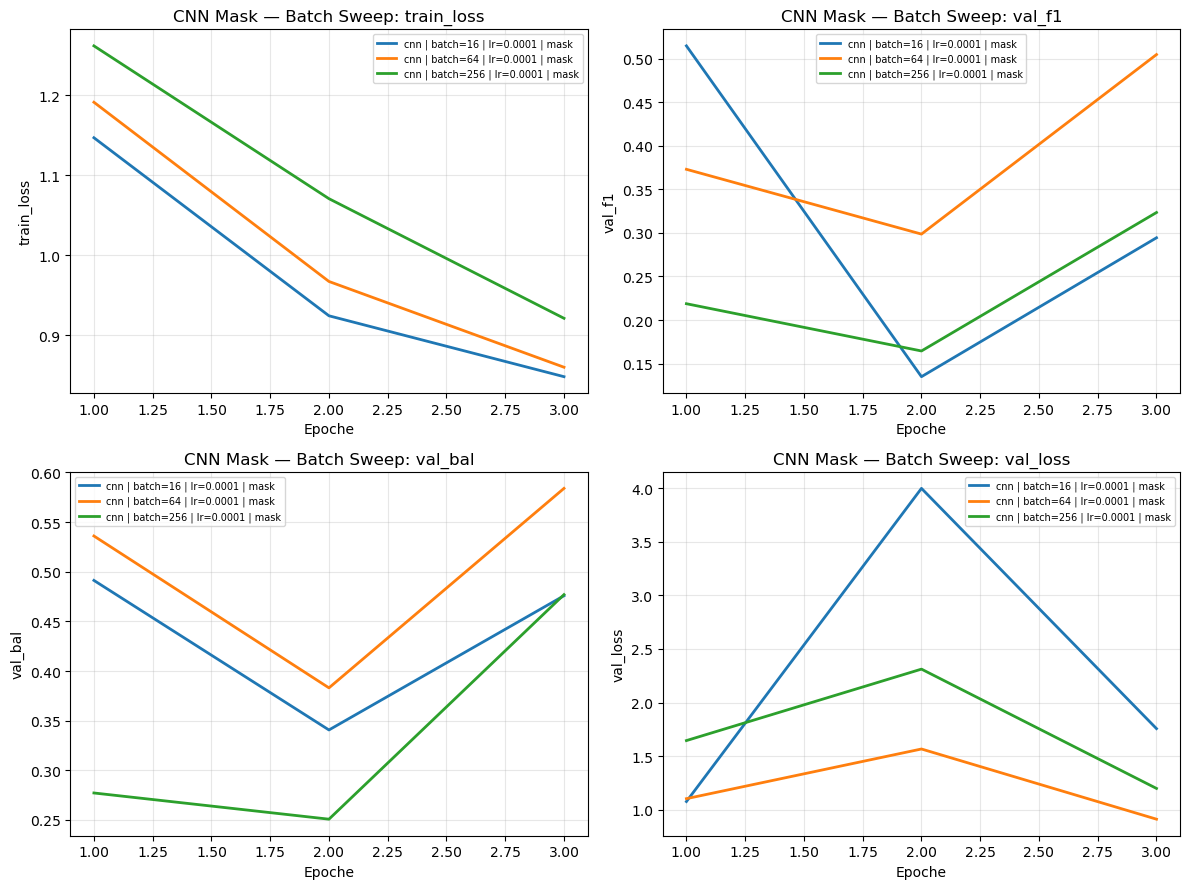


=== MODELLVERGLEICH (ROC micro) ===
cnn | batch=16 | lr=0.0001 | mask (AUC=0.852)
cnn | batch=64 | lr=0.0001 | mask (AUC=0.806)
cnn | batch=256 | lr=0.0001 | mask (AUC=0.780)

=== MODELLVERGLEICH (ROC COVID) ===
cnn | batch=16 | lr=0.0001 | mask (AUC=0.686)
cnn | batch=64 | lr=0.0001 | mask (AUC=0.658)
cnn | batch=256 | lr=0.0001 | mask (AUC=0.690)

=== MODELLVERGLEICH (ROC Lung Opacity) ===
cnn | batch=16 | lr=0.0001 | mask (AUC=0.865)
cnn | batch=64 | lr=0.0001 | mask (AUC=0.886)
cnn | batch=256 | lr=0.0001 | mask (AUC=0.869)

=== MODELLVERGLEICH (ROC Viral Pneumonia) ===
cnn | batch=16 | lr=0.0001 | mask (AUC=0.953)
cnn | batch=64 | lr=0.0001 | mask (AUC=0.966)
cnn | batch=256 | lr=0.0001 | mask (AUC=0.969)


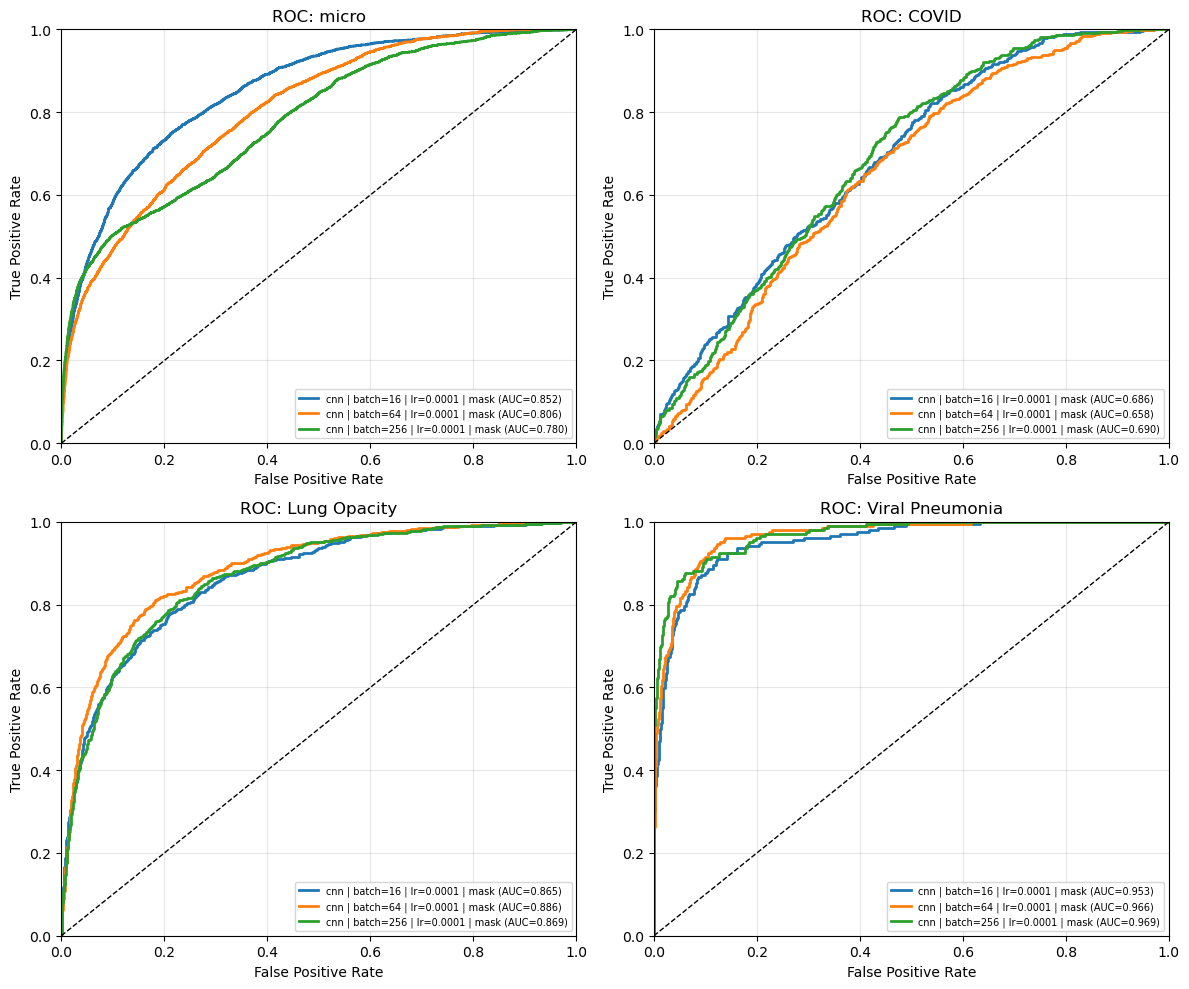

In [34]:
plot_train_overlays_grid(
    train_dirs_cnn_mask_batch,
    metrics=("train_loss", "val_f1", "val_bal", "val_loss"),
    title_prefix="CNN Mask — Batch Sweep"
)
plot_test_roc_overlays_grid(
    test_dirs_cnn_mask_batch,
    class_order=["micro","COVID","Lung Opacity","Viral Pneumonia"]
)


=== SWEEP RUN: model=cnn | mode=nomask | batch=64 | lr=0.0001 ===

[TRAIN-START] Model=cnn | Modus=nomask | Batch=64 | LR=0.0001 | Epochen=2 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.2086 | val_loss=1.1215 | val_f1=0.443 | val_bal=0.562 | 28.71s


Epoche 02: train_loss=1.0512 | val_loss=1.0288 | val_f1=0.499 | val_bal=0.602 | 28.27s
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_30_1804_batch-64_lr-00001
[TEST-START] Model=cnn | Modus=nomask | Batch=64
Pfad=cnn_nomask_2025_08_30_1804_batch-64_lr-00001.pt


[test] F1(macro)=0.479 | BalAcc=0.581 | Zeit=5.07s | /home/lupan001/ML/results/cnn_nomask_2025_08_30_1804_batch-64_lr-00001_test
[SWEEP] Modell=cnn_nomask_2025_08_30_1804_batch-64_lr-00001 | F1=0.479 | BalAcc=0.581

=== SWEEP RUN: model=cnn | mode=nomask | batch=64 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=nomask | Batch=64 | LR=0.001 | Epochen=2 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.0328 | val_loss=0.8968 | val_f1=0.580 | val_bal=0.668 | 29.08s


Epoche 02: train_loss=0.8522 | val_loss=0.8927 | val_f1=0.543 | val_bal=0.640 | 28.13s
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_30_1805_batch-64_lr-0001
[TEST-START] Model=cnn | Modus=nomask | Batch=64
Pfad=cnn_nomask_2025_08_30_1805_batch-64_lr-0001.pt


[test] F1(macro)=0.580 | BalAcc=0.668 | Zeit=5.19s | /home/lupan001/ML/results/cnn_nomask_2025_08_30_1805_batch-64_lr-0001_test
[SWEEP] Modell=cnn_nomask_2025_08_30_1805_batch-64_lr-0001 | F1=0.580 | BalAcc=0.668

=== SWEEP RUN: model=cnn | mode=nomask | batch=64 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.1268 @idx=178 → vorgeschlagene LR=7.567e-03
[lr-finder] gewählte Start-LR: 7.567e-03

[TRAIN-START] Model=cnn | Modus=nomask | Batch=64 | LR=0.007566925234263951 | Epochen=2 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.1117 | val_loss=1.0088 | val_f1=0.416 | val_bal=0.547 | 28.61s


Epoche 02: train_loss=0.8753 | val_loss=1.2119 | val_f1=0.380 | val_bal=0.483 | 28.41s
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_30_1806_batch-64_lr-0007566925234263951
[TEST-START] Model=cnn | Modus=nomask | Batch=64
Pfad=cnn_nomask_2025_08_30_1806_batch-64_lr-0007566925234263951.pt


[test] F1(macro)=0.417 | BalAcc=0.544 | Zeit=5.12s | /home/lupan001/ML/results/cnn_nomask_2025_08_30_1806_batch-64_lr-0007566925234263951_test
[SWEEP] Modell=cnn_nomask_2025_08_30_1806_batch-64_lr-0007566925234263951 | F1=0.417 | BalAcc=0.544

=== SWEEP RUN: model=cnn | mode=nomask | batch=128 | lr=0.0001 ===

[TRAIN-START] Model=cnn | Modus=nomask | Batch=128 | LR=0.0001 | Epochen=2 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.2422 | val_loss=1.1557 | val_f1=0.491 | val_bal=0.589 | 28.88s


Epoche 02: train_loss=1.1049 | val_loss=1.0854 | val_f1=0.454 | val_bal=0.587 | 28.35s
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_30_1808_batch-128_lr-00001
[TEST-START] Model=cnn | Modus=nomask | Batch=128
Pfad=cnn_nomask_2025_08_30_1808_batch-128_lr-00001.pt


[test] F1(macro)=0.489 | BalAcc=0.581 | Zeit=5.16s | /home/lupan001/ML/results/cnn_nomask_2025_08_30_1808_batch-128_lr-00001_test
[SWEEP] Modell=cnn_nomask_2025_08_30_1808_batch-128_lr-00001 | F1=0.489 | BalAcc=0.581

=== SWEEP RUN: model=cnn | mode=nomask | batch=128 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=nomask | Batch=128 | LR=0.001 | Epochen=2 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.0764 | val_loss=0.9684 | val_f1=0.535 | val_bal=0.607 | 29.04s


Epoche 02: train_loss=0.8840 | val_loss=0.9085 | val_f1=0.536 | val_bal=0.650 | 28.44s
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_30_1809_batch-128_lr-0001
[TEST-START] Model=cnn | Modus=nomask | Batch=128
Pfad=cnn_nomask_2025_08_30_1809_batch-128_lr-0001.pt


[test] F1(macro)=0.529 | BalAcc=0.641 | Zeit=5.16s | /home/lupan001/ML/results/cnn_nomask_2025_08_30_1809_batch-128_lr-0001_test
[SWEEP] Modell=cnn_nomask_2025_08_30_1809_batch-128_lr-0001 | F1=0.529 | BalAcc=0.641

=== SWEEP RUN: model=cnn | mode=nomask | batch=128 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.0488 @idx=185 → vorgeschlagene LR=1.046e-02
[lr-finder] gewählte Start-LR: 1.046e-02

[TRAIN-START] Model=cnn | Modus=nomask | Batch=128 | LR=0.010462198616112655 | Epochen=2 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.1367 | val_loss=2.2852 | val_f1=0.122 | val_bal=0.301 | 29.72s


Epoche 02: train_loss=0.8984 | val_loss=1.1640 | val_f1=0.355 | val_bal=0.455 | 28.21s
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_30_1810_batch-128_lr-0010462198616112655
[TEST-START] Model=cnn | Modus=nomask | Batch=128
Pfad=cnn_nomask_2025_08_30_1810_batch-128_lr-0010462198616112655.pt


[test] F1(macro)=0.377 | BalAcc=0.477 | Zeit=5.20s | /home/lupan001/ML/results/cnn_nomask_2025_08_30_1810_batch-128_lr-0010462198616112655_test
[SWEEP] Modell=cnn_nomask_2025_08_30_1810_batch-128_lr-0010462198616112655 | F1=0.377 | BalAcc=0.477

=== SWEEP RUN: model=cnn | mode=nomask | batch=256 | lr=0.0001 ===

[TRAIN-START] Model=cnn | Modus=nomask | Batch=256 | LR=0.0001 | Epochen=2 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.3025 | val_loss=1.2951 | val_f1=0.227 | val_bal=0.341 | 28.68s


Epoche 02: train_loss=1.1822 | val_loss=1.1547 | val_f1=0.505 | val_bal=0.584 | 28.18s
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_30_1812_batch-256_lr-00001
[TEST-START] Model=cnn | Modus=nomask | Batch=256
Pfad=cnn_nomask_2025_08_30_1812_batch-256_lr-00001.pt


[test] F1(macro)=0.495 | BalAcc=0.571 | Zeit=5.15s | /home/lupan001/ML/results/cnn_nomask_2025_08_30_1812_batch-256_lr-00001_test
[SWEEP] Modell=cnn_nomask_2025_08_30_1812_batch-256_lr-00001 | F1=0.495 | BalAcc=0.571

=== SWEEP RUN: model=cnn | mode=nomask | batch=256 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=nomask | Batch=256 | LR=0.001 | Epochen=2 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.1050 | val_loss=1.1690 | val_f1=0.349 | val_bal=0.399 | 28.89s


Epoche 02: train_loss=0.8957 | val_loss=1.2502 | val_f1=0.476 | val_bal=0.452 | 28.16s
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_30_1813_batch-256_lr-0001
[TEST-START] Model=cnn | Modus=nomask | Batch=256
Pfad=cnn_nomask_2025_08_30_1813_batch-256_lr-0001.pt


[test] F1(macro)=0.450 | BalAcc=0.435 | Zeit=5.17s | /home/lupan001/ML/results/cnn_nomask_2025_08_30_1813_batch-256_lr-0001_test
[SWEEP] Modell=cnn_nomask_2025_08_30_1813_batch-256_lr-0001 | F1=0.450 | BalAcc=0.435

=== SWEEP RUN: model=cnn | mode=nomask | batch=256 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.0279 @idx=199 → vorgeschlagene LR=2.000e-02
[lr-finder] gewählte Start-LR: 2.000e-02

[TRAIN-START] Model=cnn | Modus=nomask | Batch=256 | LR=0.020000000000000268 | Epochen=2 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.2299 | val_loss=1.3479 | val_f1=0.261 | val_bal=0.411 | 29.69s


Epoche 02: train_loss=0.9962 | val_loss=1.0625 | val_f1=0.432 | val_bal=0.564 | 28.00s
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_30_1814_batch-256_lr-0020000000000000268
[TEST-START] Model=cnn | Modus=nomask | Batch=256
Pfad=cnn_nomask_2025_08_30_1814_batch-256_lr-0020000000000000268.pt


[test] F1(macro)=0.433 | BalAcc=0.564 | Zeit=5.28s | /home/lupan001/ML/results/cnn_nomask_2025_08_30_1814_batch-256_lr-0020000000000000268_test
[SWEEP] Modell=cnn_nomask_2025_08_30_1814_batch-256_lr-0020000000000000268 | F1=0.433 | BalAcc=0.564

=== MODELLVERGLEICH (Train train_loss) ===
cnn | batch=128 | lr=0.0001 | nomask | train_loss max=1.0764
cnn | batch=128 | lr=0.001046 | nomask | train_loss max=1.1367
cnn | batch=128 | lr=1e-05 | nomask | train_loss max=1.2422
cnn | batch=256 | lr=0.0001 | nomask | train_loss max=1.1050
cnn | batch=256 | lr=0.002 | nomask | train_loss max=1.2299
cnn | batch=256 | lr=1e-05 | nomask | train_loss max=1.3025
cnn | batch=64 | lr=0.0001 | nomask | train_loss max=1.0328
cnn | batch=64 | lr=0.0007567 | nomask | train_loss max=1.1117
cnn | batch=64 | lr=1e-05 | nomask | train_loss max=1.2086

=== MODELLVERGLEICH (Train val_loss) ===
cnn | batch=128 | lr=0.0001 | nomask | val_loss max=0.9684
cnn | batch=128 | lr=0.001046 | nomask | val_loss max=2.2852
cn

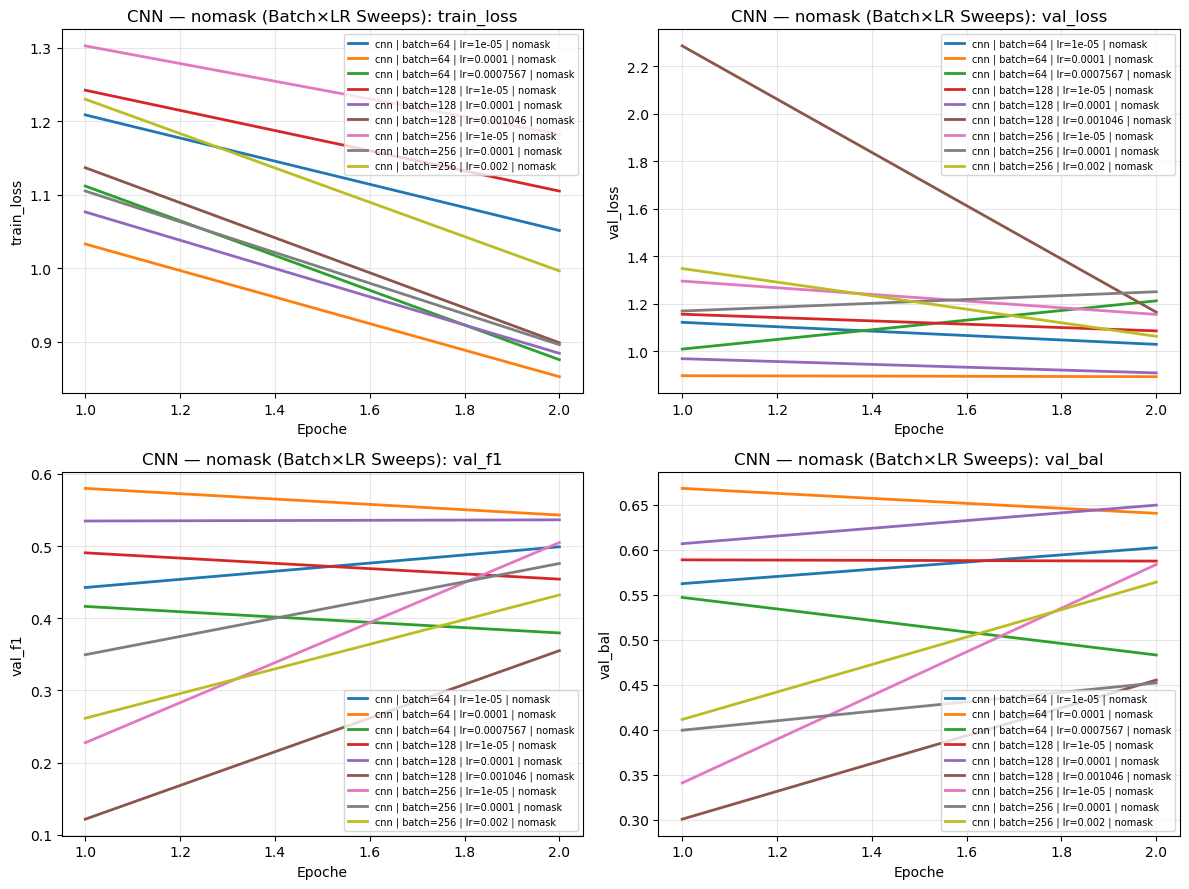


=== MODELLVERGLEICH (ROC micro) ===
cnn | batch=64 | lr=1e-05 | nomask (AUC=0.773)
cnn | batch=64 | lr=0.0001 | nomask (AUC=0.821)
cnn | batch=64 | lr=0.0007567 | nomask (AUC=0.731)
cnn | batch=128 | lr=1e-05 | nomask (AUC=0.742)
cnn | batch=128 | lr=0.0001 | nomask (AUC=0.784)
cnn | batch=128 | lr=0.001046 | nomask (AUC=0.705)
cnn | batch=256 | lr=1e-05 | nomask (AUC=0.766)
cnn | batch=256 | lr=0.0001 | nomask (AUC=0.857)
cnn | batch=256 | lr=0.002 | nomask (AUC=0.739)

=== MODELLVERGLEICH (ROC COVID) ===
cnn | batch=64 | lr=1e-05 | nomask (AUC=0.700)
cnn | batch=64 | lr=0.0001 | nomask (AUC=0.748)
cnn | batch=64 | lr=0.0007567 | nomask (AUC=0.685)
cnn | batch=128 | lr=1e-05 | nomask (AUC=0.698)
cnn | batch=128 | lr=0.0001 | nomask (AUC=0.696)
cnn | batch=128 | lr=0.001046 | nomask (AUC=0.689)
cnn | batch=256 | lr=1e-05 | nomask (AUC=0.685)
cnn | batch=256 | lr=0.0001 | nomask (AUC=0.747)
cnn | batch=256 | lr=0.002 | nomask (AUC=0.694)

=== MODELLVERGLEICH (ROC Lung Opacity) ===
cnn 

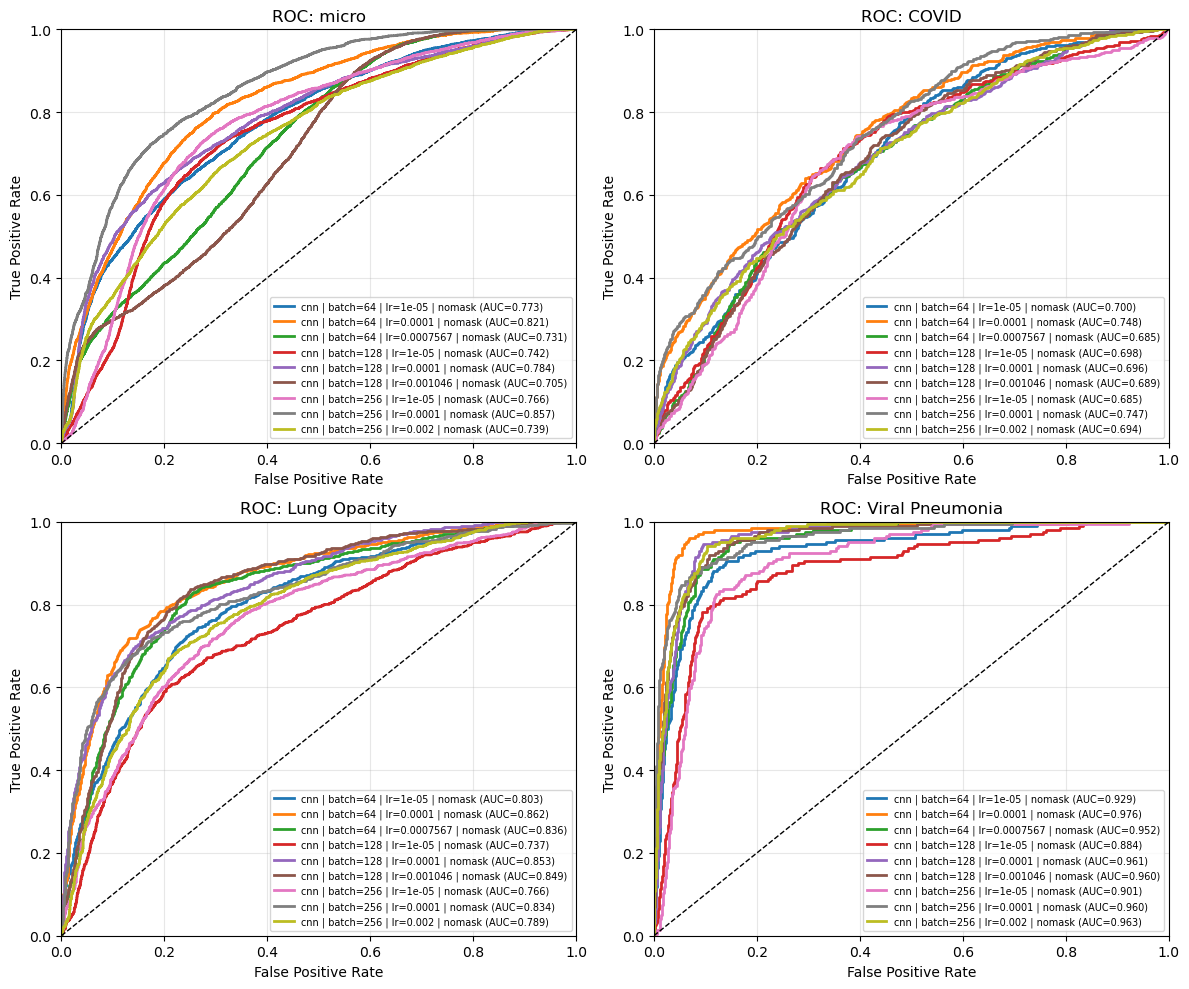

In [35]:
# sammeln
train_dirs_cnn_nomask = []
test_dirs_cnn_nomask  = []

for b in [64, 128, 256]:
    t, tt = run_sweep_train_test(
        "nomask",
        lrs=[1e-4, 1e-3, "auto"],
        fixed_batch=b,
        epochs=2,
        model_kind="cnn"
    )
    # FIX: in die _nomask-Listen schreiben, nicht _mask
    train_dirs_cnn_nomask += t   # alt: train_dirs_cnn_mask += t
    test_dirs_cnn_nomask  += tt  # alt: test_dirs_cnn_mask  += tt

# --- EINMAL danach plotten ---

# einfache Deduplizierung ohne neue Funktion (preserves order)
train_unique = [Path(p) for p in dict.fromkeys(map(str, train_dirs_cnn_nomask))]
test_unique  = [Path(p) for p in dict.fromkeys(map(str, test_dirs_cnn_nomask))]

# 1 Figure mit 4 Trainings-Metriken (2×2)
plot_train_overlays_grid(
    train_unique,
    metrics=("train_loss", "val_loss", "val_f1", "val_bal"),
    title_prefix="CNN — nomask"
)

# 1 Figure mit 4 ROC-Plots (2×2)
plot_test_roc_overlays_grid(
    test_unique,
    class_order=["micro","COVID","Lung Opacity","Viral Pneumonia"]
)


In [ ]:
# Sammeln
train_dirs_cnn_mask = []
test_dirs_cnn_mask  = []
for b in [64, 128, 256]:
    t, tt = run_sweep_train_test(
        "nomask",
        lrs=[1e-4, 1e-3, "auto"],
        fixed_batch=b,
        epochs=50,
        model_kind="cnn"
    )
    train_dirs_cnn_mask += t
    test_dirs_cnn_mask  += tt

In [47]:
from pathlib import Path
import random, torch, numpy as np, pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

def _list_available_models(prefix: str | None = None) -> list[Path]:
    """Listet alle verfügbaren Modelle für ein gegebenes Präfix auf."""
    pats = [f"{prefix}_*.pt"] if prefix else ["*.pt"]
    cands = []
    for pat in pats:
        cands.extend(sorted((MODELS_DIR).glob(pat)))
    return cands


def predict_random_image(
    *,
    data_csv: Path,
    img_size: int = 224,
    # Variante A: best_entry aus analyze_best_per_model_kind(...)
    best_entry: dict | None = None,
    # Variante B: expliziter Modellpfad + Zusatzinfos
    model_path: Path | None = None,
    model_kind: str | None = None,
    mode: str | None = None,
    seed: int | None = None,
):
    """
    Einfache Vorhersage-Funktion für EIN zufälliges Bild.
    - Entweder mit 'best_entry' (aus analyze_best_per_model_kind)
    - oder mit explizitem 'model_path' UND (model_kind, mode)
    Wendet bei mode='mask' automatisch die passende Maske an.
    """

    # --- Parameter prüfen ---
    assert (best_entry is not None) ^ (model_path is not None), \
        "Entweder 'best_entry' ODER 'model_path' angeben."

    # --- Entry vorbereiten ---
    if model_path is not None:
        assert model_kind is not None and mode is not None, \
            "Für 'model_path' bitte auch 'model_kind' und 'mode' angeben."
        entry = {
            "model_kind": model_kind,
            "mode": mode,
            "batch": "?",
            "lr": "?",
            "model_path": Path(model_path),
        }
    else:
        entry = dict(best_entry)  # Kopie, um Änderungen zu vermeiden

    # --- Prüfen, ob Modell existiert, sonst Fallback ---
    mp = Path(entry["model_path"])
    if not mp.exists():
        print(f"[warn] Modell nicht gefunden: {mp.name}")
        try:
            # Fallback: neuestes Modell gleicher Art & Modus
            mp = _latest_model_path_by_kind(entry["model_kind"], entry["mode"])
            print(f"[fallback] Nutze neuestes Modell: {mp.name}")
        except FileNotFoundError:
            # Kandidaten anzeigen
            pref = {"cnn": "cnn", "nn_simple": "nn", "nn_mlp": "nn_mlp"}[entry["model_kind"]]
            cand = _list_available_models(prefix=f"{pref}_{entry['mode']}")
            if cand:
                print("[info] Verfügbare Modelle:")
                for p in cand[-10:]:
                    print("   ", p.name)
            raise FileNotFoundError(f"Kein passendes Modell gefunden für "
                                    f"{entry['model_kind']=}, {entry['mode']=}")
    entry["model_path"] = mp

    # --- CSV laden & zufälliges Bild wählen ---
    df = pd.read_csv(data_csv)
    if df.empty:
        print(f"[predict] CSV leer: {data_csv}")
        return
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    row = df.sample(1).iloc[0]
    img_path = Path(row["path"])
    true_label = str(row["label"])

    # --- Bild laden ---
    img = Image.open(img_path).convert("L").resize((img_size, img_size), Image.BILINEAR)
    x_np = np.asarray(img, dtype=np.float32) / 255.0

    # --- Falls Modus = mask: Maske anwenden ---
    if entry["mode"] == "mask":
        mask_path = img_path.parent.parent / "masks" / img_path.name
        if mask_path.exists():
            mask = Image.open(mask_path).convert("L").resize((img_size, img_size), Image.NEAREST)
            mask_np = (np.asarray(mask, dtype=np.float32) / 255.0 > 0.5).astype(np.float32)
            x_np = x_np * mask_np
        else:
            print(f"[warn] Maske nicht gefunden für {img_path.name}")

    # --- Preprocessing wie beim Training ---
    x_np = (x_np - 0.5) / 0.5
    x = torch.from_numpy(x_np).unsqueeze(0).unsqueeze(0).to(device)

    # --- Modell laden ---
    num_classes = len(CLASS_NAMES)
    model = _build_model(entry["model_kind"], num_classes=num_classes, img_size=img_size).to(device)
    try:
        state = torch.load(entry["model_path"], map_location=device, weights_only=True)
    except TypeError:
        state = torch.load(entry["model_path"], map_location=device)
    model.load_state_dict(state)
    model.eval()

    # --- Vorhersage ---
    with torch.no_grad():
        probs = torch.softmax(model(x), dim=1).cpu().numpy()[0]
    pred_idx = int(np.argmax(probs))
    pred_label = CLASS_NAMES[pred_idx]
    pred_prob = probs[pred_idx] * 100.0

    # --- Plot ---
    plt.figure(figsize=(5, 5))
    plt.imshow((x_np * 0.5 + 0.5), cmap="gray")
    plt.axis("off")
    title = (
        f"Pred: {pred_label} ({pred_prob:.1f}%) | True: {true_label}\n"
        f"Model: {entry['model_kind']} | mode={entry['mode']} | "
        f"batch={entry.get('batch', '?')} | lr={entry.get('lr', '?')}\n"
        f"{Path(entry['model_path']).name}"
    )
    plt.title(title, fontsize=9)
    plt.tight_layout()
    plt.show()

    return {
        "img_path": str(img_path),
        "true_label": true_label,
        "pred_label": pred_label,
        "pred_prob": float(pred_prob),
        "model_path": str(entry["model_path"]),
        "model_kind": entry["model_kind"],
        "mode": entry["mode"],
    }


==================== TOP 1–3 (beste je Modellart, nach Val-F1 sortiert) ====================

Platz 1:
  Modellart:    cnn
  Modus:        nomask
  Batchsize:    128
  LR:           0.009989010231710404
  Tag:          cnn_nomask_2025_08_30_1719_batch-128_lr-0009989010231710404
  Modellpfad:   /home/lupan001/ML/models/cnn_nomask_2025_08_30_1719_batch-128_lr-0009989010231710404.pt
  Val-F1:       0.881
  Test-F1:      0.868
  Test-BalAcc:  0.867
  Test-Ordner:  /home/lupan001/ML/results/cnn_nomask_2025_08_30_1719_batch-128_lr-0009989010231710404_test

Platz 2:
  Modellart:    nn_simple
  Modus:        nomask
  Batchsize:    64
  LR:           0.001
  Tag:          nn_nomask_2025_08_30_1215_batch-64_lr-0001
  Modellpfad:   /home/lupan001/ML/models/nn_nomask_2025_08_30_1215_batch-64_lr-0001.pt
  Val-F1:       0.782

Platz 3:
  Modellart:    nn_mlp
  Modus:        mask
  Batchsize:    128
  LR:           0.0001
  Tag:          nn_mlp_mask_2025_08_30_1343_batch-128_lr-00001
  Modellpfad:  

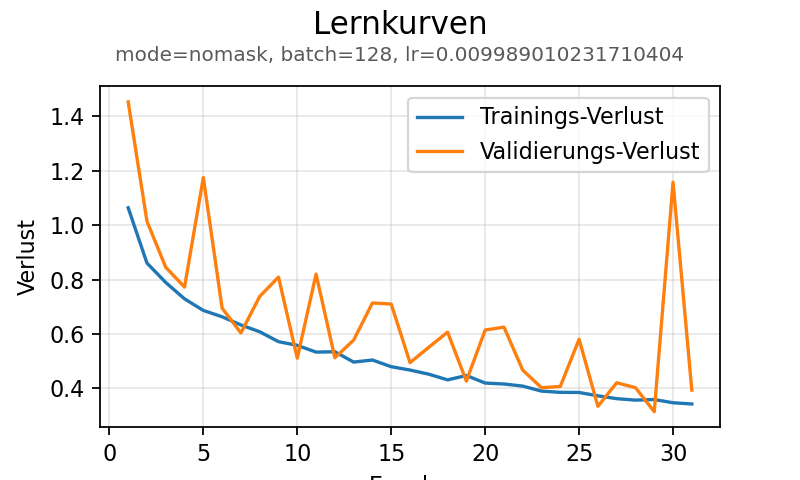

Validierungsmetriken (F1/Balance)


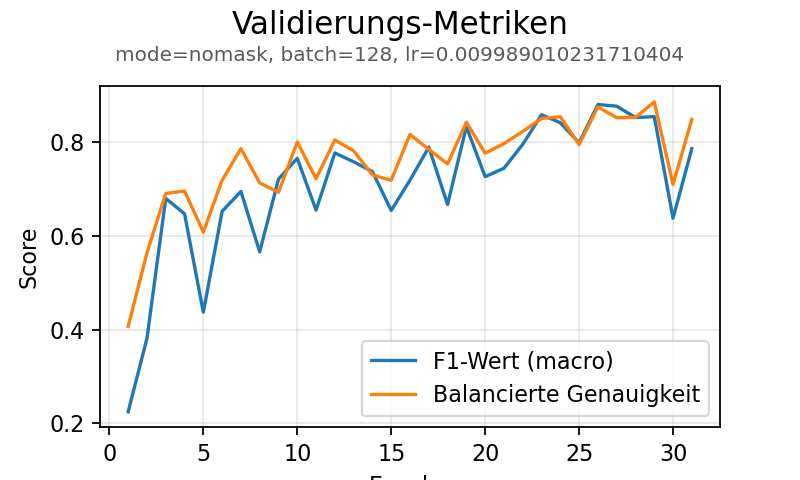

Konfusionsmatrix (Test)


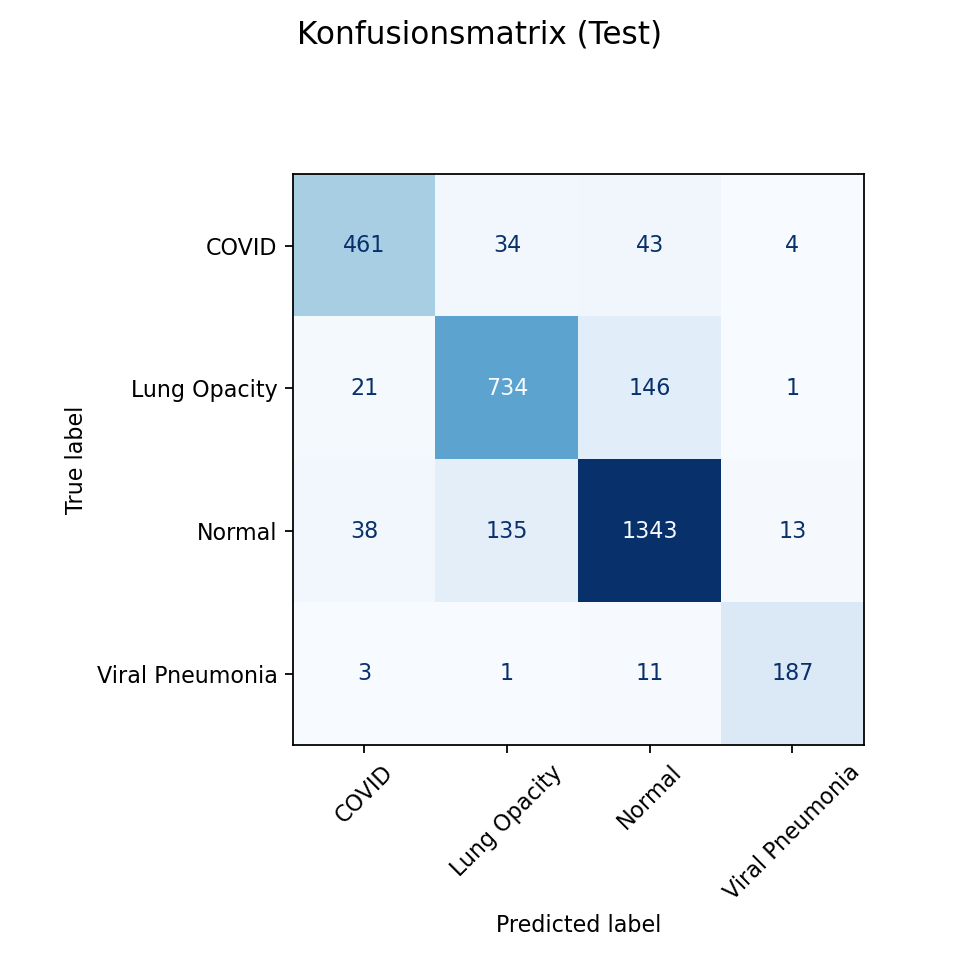

ROC-Kurven (Test)


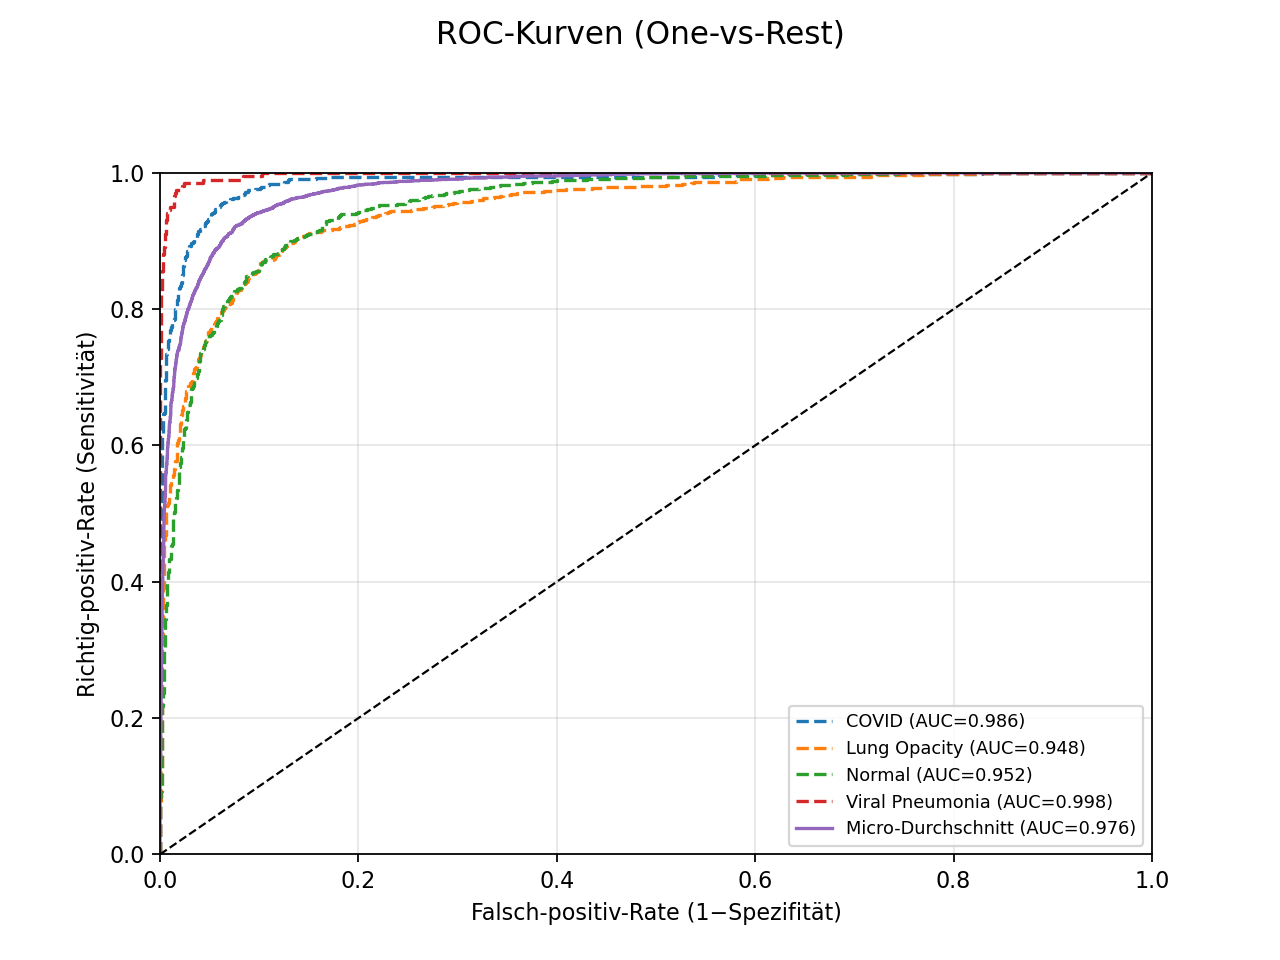

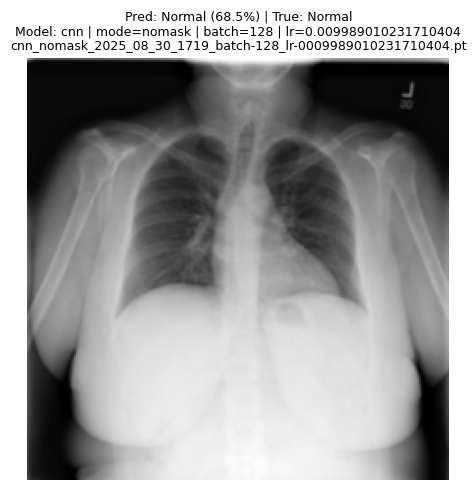

In [48]:
out = analyze_best_per_model_kind(
    results_dir=RESULTS_DIR,
    models_dir=MODELS_DIR,
    data_csv=DATA_DIR / "all_images.csv",
    img_size=224
)
# out["best"] enthält das beste Model

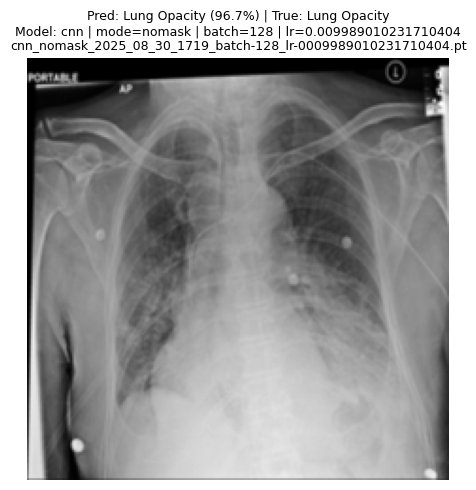

{'img_path': '/home/lupan001/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-5420.png',
 'true_label': 'Lung Opacity',
 'pred_label': 'Lung Opacity',
 'pred_prob': 96.73103094100952,
 'model_path': '/home/lupan001/ML/models/cnn_nomask_2025_08_30_1719_batch-128_lr-0009989010231710404.pt',
 'model_kind': 'cnn',
 'mode': 'nomask'}

In [54]:
predict_random_image(
    data_csv=DATA_DIR / "all_images.csv",
    img_size=224,
    best_entry=out["best"]       # direkt wiederverwenden
)

[warn] Modell nicht gefunden: cnn_mask_2025_08_31_1015_batch-128_lr-0.001.pt
[fallback] Nutze neuestes Modell: cnn_mask_2025_08_30_1756_batch-256_lr-0001.pt


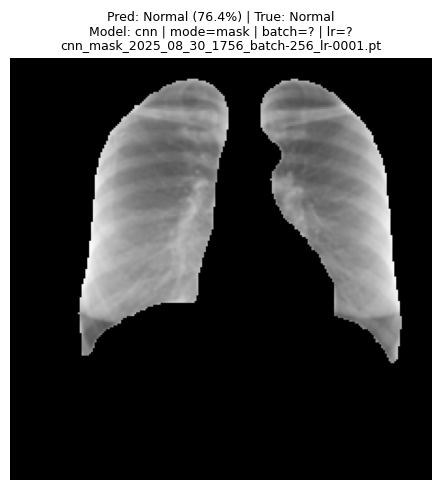

{'img_path': '/home/lupan001/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/Normal/images/Normal-5290.png',
 'true_label': 'Normal',
 'pred_label': 'Normal',
 'pred_prob': 76.38684511184692,
 'model_path': '/home/lupan001/ML/models/cnn_mask_2025_08_30_1756_batch-256_lr-0001.pt',
 'model_kind': 'cnn',
 'mode': 'mask'}

In [51]:
predict_random_image(
    data_csv=DATA_DIR / "all_images.csv",
    img_size=224,
    model_path=MODELS_DIR / "cnn_mask_2025_08_31_1015_batch-128_lr-0.001.pt",
    model_kind="cnn",
    mode="mask"
)
